### Import Package

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from stockstats import StockDataFrame

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from math import floor

import pandas_datareader.data as web
import pickle
import time

# Backtesting Setting

In [ ]:
start_date = []
num_period = 10
period_year = 1

start = 2022-(num_period+period_year-1)
for i in range(num_period):
    start_date.append((start+i)*10000+101)


date_range_list={}
for i in start_date:
    date_range_list[i] = (i-101)+(period_year-1)*10000+1231

print(date_range_list)

stock_list = {"BlockChain":["COIN","NVDA","FB"],
              "Airline":["BA","GD","LMT",],
              "Traveling":["UBER","ABNB","MAR","BKNG"],
              "Semiconductors":["INTC","NVDA","QCOM","MU","AMD"],
              "Cloud Computing":["IBM", "AMZN","GOOG","CRM"],
              "Social Media":["TWTR","SNAP","PINS","FB"],
              "Entertainment":["DIS","NFLX","FB"],
              "Retail":["WMT","COST","TGT","BBY","HD"],
              "Franchise":["MCD", "YUM", "SBUX", "DPZ"],
              "Real Estate":["HST", "EQR", "AVB", "PLD", "SPG"],
              "Telecommunication":["T","TMUS","VZ","CMCSA","CHTR"],
              "Energy & Resources":["DOW", "DD"],
              "Luxury goods":["RACE","EL","PVH"]
                            }

start_date = "2000-01-01"
end_date = "2022-12-31"


do_nth_name = "Buy&Hold"
model_name = "WithModel"

backtest_col = ["Sector","Stock",
                "Range_Start","Range_End",
                do_nth_name+"_Profit",model_name+"_Profit",
                do_nth_name+"_CAGR(in %)",model_name+"_CAGR(in %)",
                "CAGR_Performance(in %)",
                do_nth_name+"_MDD(in %)",model_name+"_MDD(in %)",
                "MDD_Performance(in %)"]

{20120101: 20121231, 20130101: 20131231, 20140101: 20141231, 20150101: 20151231, 20160101: 20161231, 20170101: 20171231, 20180101: 20181231, 20190101: 20191231, 20200101: 20201231, 20210101: 20211231}


# Backtesting

In [ ]:
################### Input ##########################
# For hist_price_data: index=["date"], columns = ["Open"]
# For pred_action: index=["date"], columns = ["Action"] (Buy/Sell)
################### Output #########################
# 1. trading record
# 2. total profit
class backtest:
    hpd = ""
    pred_action=pd.DataFrame()
    trade_record=pd.DataFrame(index=[],
                              columns=["Action","Price","Position","Cash","Pos_Bal","Cash_Bal","Cum_Profit","Total_Bal"],
                             )
    capital = 0
    cash_balance = 0
    profit = 0
    handle_fee = 0
    position = 0
    last_price = 0
    do_nth_profit = 0
    num_year = 0
    _tested = False
    
    _stock_trough = 0
    _stock_peak = 0
    _stock_all_time_low = 0
    _stock_all_time_high = 0
    
    _portfolio_trough = 0
    _portfolio_peak = 0
    _portfolio_all_time_low = 0
    _portfolio_all_time_high = 0
    
    def __init__(self,hist_price_data,pred_action,capital,handling_fee,num_year=1):
        self.hpd = hist_price_data
        self.pred_action = pred_action
        self.capital = capital
        self.cash_balance = capital
        self._portfolio_trough = capital
        self._portfolio_peak = capital
        self._portfolio_all_time_low = capital
        self._portfolio_all_time_high = capital
        self.handle_fee = handling_fee
        self.num_year = num_year  
        
    def clear_trade_record(self,sec):
        self.trade_record=pd.DataFrame(index=[],
                                       columns=["Action","Price","Position","Cash","Pos_Bal","Cash_Bal","Cum_Profit","Total_Bal"],
                                       )
        print("Clearing trade_record...")
        time.sleep(sec)
        
    def start_test(self): 
        if not self._tested:
            status = "sell"
            self._tested = True
            print("Start Backtesting...")  
            self._stock_all_time_low = self.hpd.iloc[0,0]
            self._stock_all_time_high = self.hpd.iloc[0,0]
            self._stock_trough = self.hpd.iloc[0,0]
            self._stock_peak = self.hpd.iloc[0,0]
            # For loop to iterate the data
            for ind in self.pred_action.index:
                # Update latest price
                self.last_price = self.hpd.loc[ind,"Open"]
                
                # Mark All Time Low,High , Trough and Peak for MDD of stock price (using "Buy&Hold")
                if self.last_price > self._stock_all_time_high:
                    self._stock_all_time_high = self.last_price
                if self.last_price < self._stock_all_time_low:
                    self._stock_all_time_low = self.last_price
                if self.last_price > self._stock_all_time_low and self._stock_trough != self._stock_all_time_low:
                    self._stock_trough = self._stock_all_time_low
                if self.last_price < self._stock_all_time_high and self._stock_peak != self._stock_all_time_high:
                    self._stock_peak = self._stock_all_time_high
                
                # Do the action
                if self.pred_action.loc[ind,"Action"].lower() == "buy" and status == "sell":
                    self._buy(ind,self.last_price)
                    status = "buy"
                elif self.pred_action.loc[ind,"Action"].lower() == "sell" and status == "buy":
                    self._sell(ind,self.last_price)
                    status = "sell"
                else:
                    #print("Did not buy at " + str(ind))
                    pass
                
                curr_portfolio_val = self.get_capital()+self.get_profit()
                
                # Mark All Time Low,High , Trough and Peak for MDD of our portfolio balance (using our model)
                if curr_portfolio_val > self._portfolio_all_time_high:
                    self._portfolio_all_time_high = curr_portfolio_val
                if curr_portfolio_val < self._portfolio_all_time_low:
                    self._portfolio_all_time_low = curr_portfolio_val
                if curr_portfolio_val > self._portfolio_all_time_low and self._portfolio_trough != self._portfolio_all_time_low:
                    self._portfolio_trough = self._portfolio_all_time_low
                if curr_portfolio_val < self._portfolio_all_time_high and self._portfolio_peak != self._portfolio_all_time_high:
                    self._portfolio_peak = self._portfolio_all_time_high
                            
            # =================================================
            self._run_do_nothing() # Calculate do nothing profit
        else:
            print("Backtesting has been completed...")
              
                
        
    def _mark_down_record(self,date,action,price,pos_delta,cash_delta):
        self.trade_record.loc[date] = [action,price,pos_delta,cash_delta,
                                       round(self.position,4),round(self.cash_balance,3),
                                       round(self.get_profit(),3),round(self.get_amount(),3)]
        
    def _buy(self,date,price):
        # Assume use all money to buy all
        buy_pos = floor(self.cash_balance / price)
        for i in range(buy_pos+1):
            act_buy_pos = buy_pos - i
            if act_buy_pos == 0:
                #print("You do not have enough money to buy!")
                return
            total_amt = act_buy_pos*price*(1+self.handle_fee)
            if self.cash_balance > total_amt:
                self.position += act_buy_pos
                self.cash_balance -= total_amt
                self._mark_down_record(date,
                                       "Buy",
                                       price,
                                       act_buy_pos,
                                       -total_amt)
                print("Bought at",date,"with price =", price, "\tPos:", act_buy_pos)
                return
        
    
    def _sell(self,date,price):
        # Assume sell all position
        sell_pos = self.position
        total_amt = sell_pos*price*(1-self.handle_fee)
        if self.position >= 1:
            self.position -= sell_pos
            self.cash_balance += total_amt
            self._mark_down_record(date,
                                   "Sell",
                                   price,
                                   -sell_pos,
                                   total_amt)
            print("Sold at",date,"with price =", price, "\tPos:", sell_pos)
            
            return

    def _run_do_nothing(self):
        balance = self.capital
        first_day_price = self.hpd.iloc[0,0]
        last_day_price = self.hpd.iloc[-1,0]
        buy_pos = floor(self.capital / first_day_price) # Calculate how many position can buy
        total_amt = buy_pos*first_day_price*(1+self.handle_fee) # Check if okay to buy (including fee)
        while self.capital < total_amt: # If not enough, reduce buy_pos by 1
            buy_pos -= 1
            total_amt = buy_pos*first_day_price*(1+self.handle_fee)
        position = buy_pos # Buy in 
        balance -= total_amt
        self.do_nth_profit = last_day_price*position+balance-self.capital

    def get_performance(self):
        if self._tested:
            model_profit = self.get_profit()
            do_nth_profit = self.get_do_nothing()
            perf = (model_profit-do_nth_profit)/abs(do_nth_profit)
            return perf
        else:
            print("No Backtesting Record.")

    def get_do_nothing(self):
        if self._tested:
            return self.do_nth_profit
        else:
            print("No Backtesting Record.")

    def get_profit(self):
        if self._tested:
            return self.get_cash_balance()+self.get_last_price()*self.get_position()-self.get_capital()
        else:
            print("No Backtesting Record.")

    def get_last_price(self):
        if self._tested:
            return self.last_price
        else:
            print("No Backtesting Record.")
    
    def get_position(self):
        if self._tested:
            return self.position
        else:
            print("No Backtesting Record.")
    
    def get_do_nothing_CAGR(self):
        if self._tested:
            start_bal = self.get_capital()
            end_bal = self.get_do_nothing()+self.get_capital()
            num_year = self.get_num_year()
            return pow(end_bal/start_bal,1/num_year)-1
        else:
            print("No Backtesting Record.")
            
    def get_model_CAGR(self):
        if self._tested:
            start_bal = self.get_capital()
            end_bal = self.get_profit()+self.get_capital()
            num_year = self.get_num_year()
            return pow(end_bal/start_bal,1/num_year)-1
        else:
            print("No Backtesting Record.")
            
    def get_diff_in_CAGR(self):
        if self._tested:
            return self.get_model_CAGR() - self.get_do_nothing_CAGR()
        else:
            print("No Backtesting Record.")
    
    def get_do_nothing_MDD(self):
        if self._tested:
            return (self._stock_trough-self._stock_peak)/self._stock_peak
        else:
            print("No Backtesting Record.")
            
    def get_model_MDD(self):
        if self._tested:
            return (self._portfolio_trough-self._portfolio_peak)/self._portfolio_peak
        else:
            print("No Backtesting Record.")
            
    def get_diff_in_MDD(self):
        if self._tested:
            return self.get_model_MDD() - self.get_do_nothing_MDD()
        else:
            print("No Backtesting Record.")
    
    def get_num_year(self):
        return self.num_year
    
    def get_cash_balance(self):
        return self.cash_balance
    
    def get_capital(self):
        return self.capital
    
    def get_amount(self):
        return self.get_capital()+self.get_profit()

    def print_do_nothing(self):
        if self._tested:
            print("If buy at", self.hpd.index[0],"with price =",self.hpd.iloc[0,0])
            print("and do nothing")
            print("Current Profit:",self.get_do_nothing())
        else:
            print("No Backtesting Record.")
            
    def print_performance(self):
        if self._tested:
            print("Performance:", str(round(self.get_performance()*100,2))+"%")
        else:
            print("No Backtesting Record.")
            
    def print_CAGR_performance(self):
        if self._tested:
            print("CAGR Performance:", str(round(self.get_diff_in_CAGR()*100,2))+"%")
        else:
            print("No Backtesting Record.")
    
    def print_trade_record(self):
        if self._tested:
            print(self.trade_record)
        else:
            print("No Backtesting Record.")
            print(self.trade_record)
    
    def print_profit(self):
        if self._tested:
            print("Current Profit with model:",self.get_profit())
        else:
            print("No Backtesting Record.")
    
    def export_trade_record(self,stock,add_msg = ""):
        if self._tested:
            # Save the trade record to the path
            if not add_msg == "":
                add_msg = "_" + add_msg
            self.trade_record = self.trade_record.sort_index()
            self.trade_record.to_csv("trade_record/"+stock+add_msg+".csv")
            print("Trade record exported.")
        else:
            print("No Backtesting Record.")

### Set the data source path

### Load the stock data

In [ ]:
start_date = "2000-01-01"
end_date = "2022-12-31"
stock_data = web.DataReader('AAPL', 'stooq',start=start_date, end=end_date)
stock_data.columns = ["open","high","low","close","volume"]

In [ ]:
# Use online package to generate additional features
x = StockDataFrame(stock_data)
data = x[['open','high','low','close','volume',
          'boll', 'boll_ub', 'boll_lb',
          'macd', 'macdh', 'macds',
          'rsi_11', 'rsi_14', 'rsi_21']]
data.index = [int(str(ind)[0:4]+str(ind)[5:7]+str(ind)[8:10]) for ind in data.index]
data = data.sort_index()

In [ ]:
data

,open,high,low,close,volume,boll,boll_ub,boll_lb,macd,macdh,macds,rsi_11,rsi_14,rsi_21
20000103,0.8018,0.8598,0.7773,0.8556,625730360,0.790195,0.899643,0.680747,-0.018213,0.010005,-0.028218,58.454990,55.714618,52.465305
20000104,0.8276,0.8458,0.7737,0.7835,598380207,0.785730,0.891155,0.680305,-0.027121,0.003597,-0.030719,49.559922,48.305491,47.209098
20000105,0.7932,0.8452,0.7874,0.7950,908962929,0.784320,0.890621,0.678019,-0.030756,0.000862,-0.031618,51.147838,49.532868,48.015623
20000106,0.8114,0.8181,0.7263,0.7263,896877125,0.784065,0.890283,0.677847,-0.036119,-0.004286,-0.031833,40.856547,41.252600,42.418792
20000107,0.7376,0.7721,0.7303,0.7610,538068726,0.789045,0.893179,0.684911,-0.035444,-0.004682,-0.030762,45.231876,44.691751,44.735690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220401,174.0300,174.8800,171.9400,174.3100,78751328,174.356000,179.691552,169.020448,0.175436,0.046053,0.129383,56.824510,57.500705,58.301124
20220404,174.5700,178.4900,174.4400,178.4400,76545983,174.367500,180.528179,168.206821,0.255784,0.145902,0.109882,96.102002,95.978445,95.826574
20220405,177.5000,178.3000,174.4150,175.0600,73401786,173.010000,176.574211,169.445789,0.091300,0.056162,0.035138,91.975149,91.817259,91.625017
20220406,172.3600,173.6300,170.1300,171.8300,89058782,171.985000,172.423406,171.546594,-0.006955,-0.003091,-0.003864,0.000000,0.000000,0.000000


In [ ]:
# Split the train and test data

def custom_split(data,start,end):
    train = (data.index >= start) & (data.index <= end)
    train_X = data[train]
    
    return train_X

# CNN_LSTM (Price Prediction)

In [ ]:
train_X = custom_split(data,start = 20130101,end = 20171031)
valid_X = custom_split(data,start = 20171101,end = 20181231)
test_X = custom_split(data,start = 20190101,end = 20201231)

### Label the target result

In [ ]:
# Assume we use 10 days price data to predict opening price of the 11th day
num_day_to_predict = 10


In [ ]:
def produce_result_target_price(X,num_day,result_col_name = "result_price"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    for i in range(len(X)-num_day):
        y.iloc[i+num_day_to_predict,0] = X.iloc[i+num_day,0]
    return y

In [ ]:
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)

### Transform the X, y data into tensor

In [ ]:
def transform_data_to_tensor(X,y,num_day):
    # Initiate tensor for X
    x_first = X.iloc[0:num_day,:]
    x_mean = x_first.mean(axis=0) # Get the mean of the 10-day frame
    x_std = x_first.std(axis=0) # Get the std of the 10-day frame
    x_first = x_first.sub(x_mean, axis=1).div(x_std, axis=1) # Normalize the 10-day frame here
    
    # Initiate tensor for y
    x_open = X.iloc[0:num_day,0]
    y_val = y.iloc[num_day,:] # Get the corresponding y
    y_val = y_val.sub(x_open.mean(axis=0)).div(x_open.std(axis=0)) # Normalize the y
    
    x_tf_data = [tf.convert_to_tensor(np.array(x_first),dtype = tf.float32)]
    y_tf_data = [tf.convert_to_tensor(np.array(y_val),dtype = tf.float32)]
    
    for i in range(1,len(X)-num_day):   
        x_window = X.iloc[i:i+num_day,:] # Set the window as a 10-day frame 
        x_mean = x_window.mean(axis=0) # Get the mean of the 10-day frame
        x_std = x_window.std(axis=0) # Get the std of the 10-day frame
        x_window = x_window.sub(x_mean, axis=1).div(x_std, axis=1) # Normalize the 10-day frame here
        
        x_open = X.iloc[i:i+num_day,0] # Get the opening price of the 10-day frame
        y_val = y.iloc[i+num_day,:] # Get the corresponding y
        y_val = y_val.sub(x_open.mean(axis=0)).div(x_open.std(axis=0)) # Normalize the y
        
        x_next_tf = tf.convert_to_tensor(np.array(x_window),dtype = tf.float32)
        x_tf_data = tf.concat([x_tf_data, [x_next_tf]], 0)
        
        y_next_tf = tf.convert_to_tensor(np.array(y_val),dtype = tf.float32)
        y_tf_data = tf.concat([y_tf_data, [y_next_tf]], 0)
    return (tf.reshape(x_tf_data,(-1,10,14,1)),y_tf_data)


In [ ]:
tf_train_X,tf_train_y = transform_data_to_tensor(train_X,train_y,num_day_to_predict)
tf_valid_X,tf_valid_y = transform_data_to_tensor(valid_X,valid_y,num_day_to_predict)
tf_test_X,tf_test_y = transform_data_to_tensor(test_X,test_y,num_day_to_predict)


2022-04-04 16:50:05.673756: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-04 16:50:05.674867: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


### Build the Model

In [ ]:

def myModel(input_shape,
            encoder_unit = 100,
            repeat_vector_n = 10):
    
    inputs = layers.Input(input_shape)
    
    print("Input: ",inputs.shape)
    
    # First Convolution + MaxPooling + Dropout
    x = layers.Conv2D(filters = 64,kernel_size=(3,3), strides = (1,1), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(2,1), padding='valid')(x)
    x = layers.Dropout(rate = 0.01)(x)
    print("1 Cov: ",x.shape)
    
    # Second Convolution + MaxPooling + Dropout
    x = layers.Conv2D(filters = 16,kernel_size=(3,3), strides = (1,1), activation='relu', padding='valid')(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(2,1), padding='valid')(x)
    x = layers.Dropout(rate = 0.01)(x)
    print("2 Cov: ",x.shape)
    
    # Flatten Layer
    x = layers.Flatten()(x)
    print("Flatten: ",x.shape)
    
    # Repeat Vector Layer
    x = layers.RepeatVector(n = repeat_vector_n)(x)
    print("RepeatVector: ",x.shape)
    
    # Connect to LSTM
    x = layers.LSTM(units = encoder_unit, input_shape=(5,1))(x)
    print("LSTM: ",x.shape)
    
    # Add the Dense Layer with relu activation
    x = layers.Dense(units = 50,activation = "relu")(x)
    print("1 Dense: ",x.shape)
    
    # Add the last Dense Layer with sigmoid activation
    outputs = layers.Dense(units = 1,activation = "sigmoid")(x)
    print("Output: ",outputs.shape)
    
    return keras.Model(inputs=inputs, outputs=outputs)


### Model Training and Fitting and Validation


In [ ]:
loss_list = ["MAE"]
optimizer_list = ["Adam"]
epoch_list = [30,50,100]
batch_list = [50]
encoder_list = [50,100]
lr_list = [0.001,0.005,0.01]
train_df = pd.DataFrame(columns = ["Epoch","Batch","Optimizer","LR","Encoder Unit","Loss","Metrics","Validation"])
best_model = ""
best_valid = 99999
metrics = [keras.metrics.MeanSquaredError()]

for los in loss_list:
    for opti in optimizer_list:
        for epochs in epoch_list:
            for batchs in batch_list:
                for lr in lr_list:
                    for encoder_u in encoder_list:

                        model = myModel(input_shape=(num_day_to_predict,train_X.shape[1],1),
                                        encoder_unit = encoder_u,
                                        repeat_vector_n = 50
                                       )

                        if opti == "Adam":
                            optimizer = keras.optimizers.Adam(learning_rate=lr)

                        if los == "MAE":
                            loss = keras.losses.MeanAbsoluteError()
                        elif los == "MSE":
                            loss = keras.losses.MeanSquaredError()

                        model.compile(
                            optimizer=optimizer,
                            loss=loss,
                            metrics=metrics,
                        )

                        history = model.fit(
                                tf_train_X,
                                tf_train_y,
                                epochs = epochs,
                                steps_per_epoch = batchs,
                            )

                        results = model.evaluate(tf_valid_X, tf_valid_y, batch_size=batchs)
                        print(results)
                        print("===== Summary =====")
                        print("Epoch: ",epochs)
                        print("Batch Size: ",batchs)
                        print("Optimizer: ",opti)
                        print("Learning Rate: ",lr)
                        print("Encoder Units: ",encoder_u)
                        print("Loss Function: ", los)
                        print("Metrics: ", metrics)
                        print("Validation: ",results)
                        if results[0] < best_valid:
                            best_valid = results[0]
                            best_model = model
                        train_df = train_df.append({"Epoch": epochs,
                                                    "Batch": batchs,
                                                    "Optimizer": opti,
                                                    "LR": lr,
                                                    "Encoder Unit": encoder_u,
                                                    "Loss": los,
                                                    "Metrics": metrics,
                                                    "Validation":results}, ignore_index=True)
best_model.save("model/cnn_lstm_best")

2022-04-04 19:56:14.582802: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-04 19:56:14.583205: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


NameError: name 'train_X' is not defined

### Model Testing

In [ ]:
def getMeanAndStd(X,num_day):
    mean_list = []
    std_list = []
    for i in range(0,len(X)-num_day): 
        x_open = X.iloc[i:i+num_day,0]
        mean_list.append(x_open.mean(axis=0))
        std_list.append(x_open.std(axis=0))
    mean_df = pd.DataFrame(mean_list, columns = ["mean"])
    std_df = pd.DataFrame(std_list, columns = ["std"])
    return (mean_df,std_df)

In [ ]:
loaded_cnn_lstm_model = keras.models.load_model('model/cnn_lstm_best')

In [ ]:


#predictions = loaded_model.predict(tf_test_X)

In [ ]:
#test_mean, test_std = getMeanAndStd(test_X, num_day_to_predict)

#final_test_y = test_y.iloc[num_day_to_predict: , :]

#final_pred = np.array(predictions*np.array(test_std) + np.array(test_mean))

### Backtest Result of CNN_LSTM (Price)

In [ ]:
def get_last_n_day_mean(df,n):
    series = df["open"]
    windows = series.rolling(n)
    n_days_averages = windows.mean()
    n_days_list = n_days_averages.tolist()
    final_list = n_days_list[n:]
    new_df = pd.DataFrame(final_list,columns=["mean_"+str(n)],index=df.index[n:])
    return new_df

In [ ]:
#### CNN_LSTM_REGRESSION
backtest_summary = pd.DataFrame(columns=backtest_col)
num_day_to_predict = 10
for sector, stocks in stock_list.items():
    for stock in stocks:
        print("Runninng stock: "+ stock)
        stock_data_1 = web.DataReader(stock, "stooq",start=start_date, end=end_date)
        stock_data_1.columns = ["open","high","low","close","volume"]
        x_1 = StockDataFrame(stock_data_1)
        data_1 = x_1[['open','high','low','close','volume',
                      'boll', 'boll_ub', 'boll_lb',
                      'macd', 'macdh', 'macds',
                      'rsi_11', 'rsi_14', 'rsi_21']]
        data_1.index = [int(str(ind)[0:4]+str(ind)[5:7]+str(ind)[8:10]) for ind in data_1.index]
        data_1 = data_1.sort_index()
        print(stock + " Data loaded...")
        for k,v in date_range_list.items():
            
            print("Getting Data... - " + stock + " from " + str(k))
            if (data_1.index[0]>v):
                print("No data for this testing period... - " + stock + " from " + str(k))
                continue
            test_X_1 = custom_split(data_1,start = k,end = v)
            test_y_1 = produce_result_target_price(test_X_1,num_day_to_predict)
            if len(test_X_1) <= 10:
                print("No enoguh data for testing... - " + stock + " from " + str(k))
                continue
                
            print("Transforming Data... - " + stock + " from " + str(k))
            tf_test_X_1,tf_test_y_1 = transform_data_to_tensor(test_X_1,test_y_1,num_day_to_predict)
            
            print("Predicting... - " + stock + " from " + str(k))
            predictions_1 = loaded_cnn_lstm_model.predict(tf_test_X_1)
            
            print("Converting... - " + stock + " from " + str(k))
            test_mean_1, test_std_1 = getMeanAndStd(test_X_1, num_day_to_predict)
            final_test_y_1 = test_y_1.iloc[num_day_to_predict: , :]
            backtestdata_1 = final_test_y_1.rename(columns={"result_price":"Open"})
            
            final_pred_1 = np.array(predictions_1*np.array(test_std_1) + np.array(test_mean_1))
            compare_to_n_day_mean = 5
            df = get_last_n_day_mean(test_X_1,compare_to_n_day_mean)[(10-compare_to_n_day_mean):]
            df["pred"] = final_pred_1
            
            df["Action"] = df.apply(lambda row: "Buy" if row["pred"] > row["mean_"+str(compare_to_n_day_mean)] else "Sell", axis=1)
            final_pred_df_1 = df.drop(columns=["mean_"+str(compare_to_n_day_mean),"pred"])
            final_pred_df_1 = final_pred_df_1.sort_index()
            
            print("Backtesting... - " + stock + " from " + str(k))
            back1 = backtest(backtestdata_1,final_pred_df_1,10000,0.0005,period_year)
            back1.clear_trade_record(3)
            
            print("Start Iteration... - " + stock + " from " + str(k))
            back1.start_test()
            
            print("======= from "+ str(k) + " to " + str(v)+" =========")
            back1.print_performance()
            back1.export_trade_record("CNN_LSTM_REG_"+sector+"-"+stock,str(k)+"-to-"+str(v)+"("+str(round(back1.get_performance()*100,2))+"%)")
            backtest_summary = backtest_summary.append({"Sector":sector,
                                                        "Stock":stock,
                                                        "Range_Start":str(k),
                                                        "Range_End":str(v),
                                                        do_nth_name+"_Profit":round(back1.get_do_nothing(),2),
                                                        model_name+"_Profit":round(back1.get_profit(),2),
                                                        do_nth_name+"_CAGR(in %)":round(back1.get_do_nothing_CAGR()*100,2),
                                                        model_name+"_CAGR(in %)":round(back1.get_model_CAGR()*100,2),
                                                        "CAGR_Performance(in %)":round(back1.get_diff_in_CAGR()*100,2),
                                                        do_nth_name+"_MDD(in %)":round(back1.get_do_nothing_MDD()*100,2),
                                                        model_name+"_MDD(in %)":round(back1.get_model_MDD()*100,2),
                                                        "MDD_Performance(in %)":round(back1.get_diff_in_MDD()*100,2)}, ignore_index=True)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

print("Backtesting Completed...")
backtest_summary.to_csv("backtest_summary_CNN_LSTM_REG.csv")
            


Runninng stock: COIN
COIN Data loaded...
Getting Data... - COIN from 20120101
No data for this testing period... - COIN from 20120101
Getting Data... - COIN from 20130101
No data for this testing period... - COIN from 20130101
Getting Data... - COIN from 20140101
No data for this testing period... - COIN from 20140101
Getting Data... - COIN from 20150101
No data for this testing period... - COIN from 20150101
Getting Data... - COIN from 20160101
No data for this testing period... - COIN from 20160101
Getting Data... - COIN from 20170101
No data for this testing period... - COIN from 20170101
Getting Data... - COIN from 20180101
No data for this testing period... - COIN from 20180101
Getting Data... - COIN from 20190101
No data for this testing period... - COIN from 20190101
Getting Data... - COIN from 20200101
No data for this testing period... - COIN from 20200101
Getting Data... - COIN from 20210101
Transforming Data... - COIN from 20210101
Predicting... - COIN from 20210101
Converti

Transforming Data... - NVDA from 20140101
Predicting... - NVDA from 20140101
Converting... - NVDA from 20140101
Backtesting... - NVDA from 20140101
Clearing trade_record...
Start Iteration... - NVDA from 20140101
Start Backtesting...
Bought at 20140116 with price = 3.7813 	Pos: 2643
Sold at 20140122 with price = 3.7981 	Pos: 2643
Bought at 20140123 with price = 3.7741 	Pos: 2657
Sold at 20140127 with price = 3.6746 	Pos: 2657
Bought at 20140128 with price = 3.6444 	Pos: 2676
Sold at 20140207 with price = 3.7034 	Pos: 2676
Bought at 20140210 with price = 3.7433 	Pos: 2645
Sold at 20140212 with price = 3.8492 	Pos: 2645
Bought at 20140226 with price = 4.4361 	Pos: 2293
Sold at 20140228 with price = 4.3648 	Pos: 2293
Bought at 20140305 with price = 4.3792 	Pos: 2283
Sold at 20140327 with price = 4.2677 	Pos: 2283
Bought at 20140331 with price = 4.2578 	Pos: 2286
Sold at 20140414 with price = 4.33 	Pos: 2286
Bought at 20140415 with price = 4.3505 	Pos: 2273
Sold at 20140425 with price = 4.

Bought at 20160822 with price = 15.354 	Pos: 1053
Sold at 20160826 with price = 15.196 	Pos: 1053
Bought at 20160830 with price = 15.25 	Pos: 1049
Sold at 20160907 with price = 15.499 	Pos: 1049
Bought at 20160912 with price = 14.468 	Pos: 1122
Sold at 20160922 with price = 16.07 	Pos: 1122
Bought at 20160926 with price = 15.816 	Pos: 1139
Sold at 20161003 with price = 16.88 	Pos: 1139
Bought at 20161006 with price = 16.605 	Pos: 1157
Sold at 20161007 with price = 16.699 	Pos: 1157
Bought at 20161012 with price = 16.223 	Pos: 1190
Sold at 20161025 with price = 17.389 	Pos: 1190
Bought at 20161104 with price = 16.63 	Pos: 1243
Sold at 20161111 with price = 19.588 	Pos: 1243
Bought at 20161115 with price = 20.762 	Pos: 1171
Sold at 20161116 with price = 21.514 	Pos: 1171
Bought at 20161122 with price = 22.984 	Pos: 1095
Sold at 20161129 with price = 23.191 	Pos: 1095
Bought at 20161130 with price = 23.092 	Pos: 1099
Sold at 20161201 with price = 22.722 	Pos: 1099
Bought at 20161202 with 

Sold at 20190820 with price = 42.451 	Pos: 270
Bought at 20190826 with price = 41.22 	Pos: 278
Sold at 20190910 with price = 44.644 	Pos: 278
Bought at 20190913 with price = 45.246 	Pos: 274
Sold at 20190917 with price = 44.968 	Pos: 274
Bought at 20190918 with price = 45.046 	Pos: 273
Sold at 20190919 with price = 44.904 	Pos: 273
Bought at 20190920 with price = 44.074 	Pos: 278
Sold at 20191010 with price = 45.003 	Pos: 278
Bought at 20191014 with price = 46.225 	Pos: 270
Sold at 20191016 with price = 48.581 	Pos: 270
Bought at 20191023 with price = 47.912 	Pos: 274
Sold at 20191028 with price = 51.402 	Pos: 274
Bought at 20191029 with price = 51.384 	Pos: 273
Sold at 20191031 with price = 50.366 	Pos: 273
Bought at 20191105 with price = 52.442 	Pos: 262
Sold at 20191111 with price = 51.764 	Pos: 262
Bought at 20191113 with price = 51.914 	Pos: 261
Sold at 20191121 with price = 52.569 	Pos: 261
Bought at 20191205 with price = 52.434 	Pos: 262
Sold at 20191216 with price = 56.32 	Pos:

Predicting... - FB from 20130101
Converting... - FB from 20130101
Backtesting... - FB from 20130101
Clearing trade_record...
Start Iteration... - FB from 20130101
Start Backtesting...
Bought at 20130116 with price = 30.21 	Pos: 330
Sold at 20130117 with price = 30.08 	Pos: 330
Bought at 20130122 with price = 29.75 	Pos: 334
Sold at 20130130 with price = 30.98 	Pos: 334
Bought at 20130131 with price = 29.15 	Pos: 354
Sold at 20130201 with price = 31.01 	Pos: 354
Bought at 20130204 with price = 29.06 	Pos: 378
Sold at 20130307 with price = 27.57 	Pos: 378
Bought at 20130311 with price = 28.0 	Pos: 372
Sold at 20130313 with price = 27.62 	Pos: 372
Bought at 20130315 with price = 27.03 	Pos: 379
Sold at 20130408 with price = 27.19 	Pos: 379
Bought at 20130409 with price = 26.58 	Pos: 388
Sold at 20130410 with price = 27.0 	Pos: 388
Bought at 20130419 with price = 25.62 	Pos: 408
Sold at 20130501 with price = 27.85 	Pos: 408
Bought at 20130510 with price = 27.14 	Pos: 418
Sold at 20130614 w

Predicting... - FB from 20160101
Converting... - FB from 20160101
Backtesting... - FB from 20160101
Clearing trade_record...
Start Iteration... - FB from 20160101
Start Backtesting...
Bought at 20160119 with price = 96.53 	Pos: 103
Sold at 20160128 with price = 107.2 	Pos: 103
Bought at 20160205 with price = 109.51 	Pos: 101
Sold at 20160208 with price = 100.41 	Pos: 101
Bought at 20160209 with price = 97.14 	Pos: 104
Sold at 20160226 with price = 108.7 	Pos: 104
Bought at 20160229 with price = 107.6 	Pos: 105
Sold at 20160302 with price = 109.68 	Pos: 105
Bought at 20160310 with price = 107.91 	Pos: 107
Sold at 20160323 with price = 112.01 	Pos: 107
Bought at 20160324 with price = 112.13 	Pos: 106
Sold at 20160330 with price = 116.73 	Pos: 106
Bought at 20160331 with price = 114.7 	Pos: 108
Sold at 20160401 with price = 113.75 	Pos: 108
Bought at 20160404 with price = 114.07 	Pos: 108
Sold at 20160405 with price = 112.11 	Pos: 108
Bought at 20160407 with price = 113.79 	Pos: 106
Sold 

Bought at 20180611 with price = 188.81 	Pos: 52
Sold at 20180620 with price = 199.1 	Pos: 52
Bought at 20180622 with price = 201.16 	Pos: 52
Sold at 20180626 with price = 197.6 	Pos: 52
Bought at 20180629 with price = 197.32 	Pos: 52
Sold at 20180712 with price = 203.43 	Pos: 52
Bought at 20180716 with price = 207.5 	Pos: 51
Sold at 20180724 with price = 215.11 	Pos: 51
Bought at 20180726 with price = 174.89 	Pos: 62
Sold at 20180809 with price = 185.849 	Pos: 62
Bought at 20180810 with price = 182.04 	Pos: 64
Sold at 20180813 with price = 180.1 	Pos: 64
Bought at 20180816 with price = 180.42 	Pos: 63
Sold at 20180830 with price = 175.9 	Pos: 63
Bought at 20180905 with price = 169.49 	Pos: 66
Sold at 20181001 with price = 163.03 	Pos: 66
Bought at 20181004 with price = 161.46 	Pos: 66
Sold at 20181018 with price = 158.51 	Pos: 66
Bought at 20181024 with price = 154.28 	Pos: 68
Sold at 20181106 with price = 149.31 	Pos: 68
Bought at 20181109 with price = 146.75 	Pos: 69
Sold at 20181207

Bought at 20210729 with price = 361.0 	Pos: 45
Sold at 20210730 with price = 354.0 	Pos: 45
Bought at 20210804 with price = 352.42 	Pos: 45
Sold at 20210830 with price = 372.56 	Pos: 45
Bought at 20210903 with price = 374.75 	Pos: 44
Sold at 20210907 with price = 375.88 	Pos: 44
Bought at 20210916 with price = 372.79 	Pos: 45
Sold at 20211025 with price = 320.3 	Pos: 45
Bought at 20211027 with price = 314.19 	Pos: 46
Sold at 20211105 with price = 340.31 	Pos: 46
Bought at 20211109 with price = 340.0 	Pos: 46
Sold at 20211110 with price = 332.49 	Pos: 46
Bought at 20211115 with price = 344.34 	Pos: 44
Sold at 20211119 with price = 342.2 	Pos: 44
Bought at 20211129 with price = 336.89 	Pos: 45
Sold at 20211216 with price = 338.98 	Pos: 45
Bought at 20211217 with price = 332.795 	Pos: 45
Sold at 20211221 with price = 326.41 	Pos: 45
Bought at 20211223 with price = 330.1 	Pos: 45
Sold at 20211227 with price = 338.845 	Pos: 45
Bought at 20211228 with price = 346.63 	Pos: 44
======= from 202

Sold at 20140716 with price = 111.97 	Pos: 91
Bought at 20140722 with price = 111.48 	Pos: 91
Sold at 20140814 with price = 106.25 	Pos: 91
Bought at 20140818 with price = 107.44 	Pos: 90
Sold at 20140819 with price = 108.88 	Pos: 90
Bought at 20140828 with price = 110.72 	Pos: 89
Sold at 20140829 with price = 110.73 	Pos: 89
Bought at 20140903 with price = 109.07 	Pos: 90
Sold at 20140915 with price = 110.35 	Pos: 90
Bought at 20140918 with price = 111.31 	Pos: 89
Sold at 20140925 with price = 111.56 	Pos: 89
Bought at 20140929 with price = 110.59 	Pos: 90
Sold at 20141023 with price = 105.46 	Pos: 90
Bought at 20141029 with price = 107.93 	Pos: 88
Sold at 20141107 with price = 109.25 	Pos: 88
Bought at 20141111 with price = 108.96 	Pos: 88
Sold at 20141114 with price = 112.44 	Pos: 88
Bought at 20141117 with price = 112.57 	Pos: 88
Sold at 20141119 with price = 114.22 	Pos: 88
Bought at 20141205 with price = 115.2 	Pos: 87
Sold at 20141226 with price = 114.82 	Pos: 87
======= from 20

Sold at 20170929 with price = 240.61 	Pos: 50
Bought at 20171002 with price = 241.37 	Pos: 50
Sold at 20171009 with price = 245.5 	Pos: 50
Bought at 20171017 with price = 243.11 	Pos: 51
Sold at 20171018 with price = 245.0 	Pos: 51
Bought at 20171020 with price = 246.79 	Pos: 50
Sold at 20171026 with price = 246.17 	Pos: 50
Bought at 20171030 with price = 242.13 	Pos: 51
Sold at 20171109 with price = 252.54 	Pos: 51
Bought at 20171117 with price = 250.45 	Pos: 51
Sold at 20171127 with price = 252.91 	Pos: 51
Bought at 20171130 with price = 257.21 	Pos: 50
Sold at 20171201 with price = 264.46 	Pos: 50
Bought at 20171206 with price = 261.93 	Pos: 51
Sold at 20171207 with price = 265.37 	Pos: 51
Bought at 20171212 with price = 274.59 	Pos: 49
Sold at 20171213 with price = 276.83 	Pos: 49
Bought at 20171221 with price = 284.03 	Pos: 48
Sold at 20171222 with price = 282.38 	Pos: 48
Bought at 20171229 with price = 282.96 	Pos: 48
======= from 20170101 to 20171231 =========
Performance: -61.3

Bought at 20201119 with price = 200.45 	Pos: 39
Sold at 20201124 with price = 219.43 	Pos: 39
Bought at 20201125 with price = 217.71 	Pos: 39
Sold at 20201209 with price = 238.64 	Pos: 39
Bought at 20201210 with price = 228.1 	Pos: 41
Sold at 20201214 with price = 235.0 	Pos: 41
Bought at 20201216 with price = 229.33 	Pos: 42
======= from 20200101 to 20201231 =========
Performance: 77.13%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - BA from 20210101
Transforming Data... - BA from 20210101
Predicting... - BA from 20210101
Converting... - BA from 20210101
Backtesting... - BA from 20210101
Clearing trade_record...
Start Iteration... - BA from 20210101
Start Backtesting...
Bought at 20210119 with price = 206.99 	Pos: 48
Sold at 20210120 with price = 213.24 	Pos: 48
Bought at 20210122 with price = 205.55 	Pos: 50
Sold at 20210126 with price = 205.34 	Pos: 50
Bought at 20210127 with price = 196.9 	Pos: 52
Sold at 20210209 with price = 2

Sold at 20130607 with price = 64.063 	Pos: 176
Bought at 20130610 with price = 64.651 	Pos: 174
Sold at 20130612 with price = 64.357 	Pos: 174
Bought at 20130618 with price = 64.294 	Pos: 174
Sold at 20130705 with price = 65.13 	Pos: 174
Bought at 20130723 with price = 69.591 	Pos: 163
Sold at 20130725 with price = 70.372 	Pos: 163
Bought at 20130729 with price = 69.877 	Pos: 164
Sold at 20130730 with price = 70.182 	Pos: 164
Bought at 20130731 with price = 70.451 	Pos: 163
Sold at 20130801 with price = 70.7 	Pos: 163
Bought at 20130814 with price = 70.89 	Pos: 162
Sold at 20130911 with price = 71.108 	Pos: 162
Bought at 20130923 with price = 72.562 	Pos: 159
Sold at 20130924 with price = 72.39 	Pos: 159
Bought at 20130927 with price = 72.429 	Pos: 159
Sold at 20131017 with price = 72.555 	Pos: 159
Bought at 20131021 with price = 73.489 	Pos: 157
Sold at 20131024 with price = 71.503 	Pos: 157
Bought at 20131028 with price = 73.086 	Pos: 153
Sold at 20131120 with price = 74.571 	Pos: 15

Sold at 20160811 with price = 133.1 	Pos: 95
Bought at 20160812 with price = 132.53 	Pos: 95
Sold at 20160815 with price = 133.15 	Pos: 95
Bought at 20160819 with price = 133.62 	Pos: 95
Sold at 20160822 with price = 134.01 	Pos: 95
Bought at 20160829 with price = 133.2 	Pos: 95
Sold at 20160901 with price = 134.19 	Pos: 95
Bought at 20160906 with price = 135.19 	Pos: 95
Sold at 20160907 with price = 135.87 	Pos: 95
Bought at 20160912 with price = 131.14 	Pos: 98
Sold at 20160926 with price = 134.94 	Pos: 98
Bought at 20160929 with price = 136.43 	Pos: 97
Sold at 20160930 with price = 137.51 	Pos: 97
Bought at 20161007 with price = 134.16 	Pos: 99
Sold at 20161020 with price = 133.89 	Pos: 99
Bought at 20161021 with price = 132.17 	Pos: 100
Sold at 20161025 with price = 133.64 	Pos: 100
Bought at 20161026 with price = 132.24 	Pos: 101
Sold at 20161109 with price = 139.34 	Pos: 101
Bought at 20161117 with price = 146.52 	Pos: 96
Sold at 20161129 with price = 152.84 	Pos: 96
Bought at 20

Sold at 20190703 with price = 170.16 	Pos: 69
Bought at 20190705 with price = 169.25 	Pos: 69
Sold at 20190708 with price = 168.71 	Pos: 69
Bought at 20190709 with price = 167.71 	Pos: 69
Sold at 20190716 with price = 174.0 	Pos: 69
Bought at 20190717 with price = 172.91 	Pos: 70
Sold at 20190719 with price = 171.4 	Pos: 70
Bought at 20190725 with price = 174.45 	Pos: 68
Sold at 20190729 with price = 176.63 	Pos: 68
Bought at 20190730 with price = 176.06 	Pos: 68
Sold at 20190731 with price = 175.96 	Pos: 68
Bought at 20190805 with price = 167.55 	Pos: 72
Sold at 20190822 with price = 175.99 	Pos: 72
Bought at 20190829 with price = 173.87 	Pos: 73
Sold at 20190906 with price = 179.77 	Pos: 73
Bought at 20190913 with price = 177.03 	Pos: 74
Sold at 20190918 with price = 177.86 	Pos: 74
Bought at 20190919 with price = 176.07 	Pos: 74
Sold at 20191016 with price = 167.09 	Pos: 74
Bought at 20191022 with price = 164.17 	Pos: 76
Sold at 20191104 with price = 169.64 	Pos: 76
Bought at 201911

Bought at 20120802 with price = 65.707 	Pos: 161
Sold at 20120803 with price = 66.217 	Pos: 161
Bought at 20120806 with price = 66.35 	Pos: 160
Sold at 20120813 with price = 67.164 	Pos: 160
Bought at 20120830 with price = 68.143 	Pos: 158
Sold at 20120912 with price = 69.234 	Pos: 158
Bought at 20120914 with price = 69.72 	Pos: 156
Sold at 20120917 with price = 69.085 	Pos: 156
Bought at 20120920 with price = 68.666 	Pos: 157
Sold at 20121002 with price = 70.027 	Pos: 157
Bought at 20121008 with price = 70.516 	Pos: 156
Sold at 20121010 with price = 70.231 	Pos: 156
Bought at 20121015 with price = 69.431 	Pos: 158
Sold at 20121025 with price = 70.756 	Pos: 158
Bought at 20121026 with price = 69.515 	Pos: 160
Sold at 20121031 with price = 70.702 	Pos: 160
Bought at 20121105 with price = 69.983 	Pos: 162
Sold at 20121127 with price = 69.707 	Pos: 162
Bought at 20121128 with price = 69.279 	Pos: 163
Sold at 20121129 with price = 69.905 	Pos: 163
Bought at 20121204 with price = 69.239 	Po

Bought at 20150729 with price = 169.84 	Pos: 59
Sold at 20150804 with price = 172.93 	Pos: 59
Bought at 20150807 with price = 173.32 	Pos: 58
Sold at 20150810 with price = 174.2 	Pos: 58
Bought at 20150811 with price = 173.36 	Pos: 59
Sold at 20150812 with price = 172.11 	Pos: 59
Bought at 20150817 with price = 174.88 	Pos: 58
Sold at 20150820 with price = 174.98 	Pos: 58
Bought at 20150824 with price = 157.58 	Pos: 64
Sold at 20150915 with price = 172.42 	Pos: 64
Bought at 20150916 with price = 173.44 	Pos: 63
Sold at 20150918 with price = 172.09 	Pos: 63
Bought at 20150922 with price = 169.12 	Pos: 65
Sold at 20151006 with price = 176.86 	Pos: 65
Bought at 20151007 with price = 176.94 	Pos: 64
Sold at 20151009 with price = 179.11 	Pos: 64
Bought at 20151013 with price = 178.11 	Pos: 65
Sold at 20151014 with price = 177.14 	Pos: 65
Bought at 20151019 with price = 174.78 	Pos: 66
Sold at 20151028 with price = 185.66 	Pos: 66
Bought at 20151030 with price = 182.96 	Pos: 66
Sold at 20151

Bought at 20180828 with price = 291.65 	Pos: 33
Sold at 20180913 with price = 295.36 	Pos: 33
Bought at 20180914 with price = 299.51 	Pos: 33
Sold at 20180918 with price = 307.35 	Pos: 33
Bought at 20180921 with price = 301.99 	Pos: 33
Sold at 20180924 with price = 304.46 	Pos: 33
Bought at 20180926 with price = 310.07 	Pos: 33
Sold at 20181002 with price = 315.13 	Pos: 33
Bought at 20181004 with price = 313.54 	Pos: 33
Sold at 20181008 with price = 313.59 	Pos: 33
Bought at 20181011 with price = 294.93 	Pos: 35
Sold at 20181113 with price = 275.54 	Pos: 35
Bought at 20181119 with price = 272.19 	Pos: 35
Sold at 20181204 with price = 269.28 	Pos: 35
Bought at 20181207 with price = 259.89 	Pos: 37
======= from 20180101 to 20181231 =========
Performance: 39.39%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - LMT from 20190101
Transforming Data... - LMT from 20190101
Predicting... - LMT from 20190101
Converting... - LMT from 20190101
Ba

Sold at 20210902 with price = 351.46 	Pos: 28
Bought at 20210907 with price = 349.4 	Pos: 28
Sold at 20210930 with price = 346.27 	Pos: 28
Bought at 20211007 with price = 344.93 	Pos: 28
Sold at 20211013 with price = 354.23 	Pos: 28
Bought at 20211026 with price = 343.11 	Pos: 29
Sold at 20211111 with price = 332.08 	Pos: 29
Bought at 20211116 with price = 336.76 	Pos: 29
Sold at 20211124 with price = 339.69 	Pos: 29
Bought at 20211126 with price = 334.21 	Pos: 29
Sold at 20211129 with price = 338.85 	Pos: 29
Bought at 20211201 with price = 332.71 	Pos: 30
Sold at 20211216 with price = 343.31 	Pos: 30
Bought at 20211220 with price = 338.67 	Pos: 30
Sold at 20211221 with price = 336.45 	Pos: 30
Bought at 20211222 with price = 338.83 	Pos: 30
Sold at 20211230 with price = 352.57 	Pos: 30
======= from 20210101 to 20211231 =========
Performance: 100.85%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Runninng stock: UBER
UBER Data loaded...
Getting Data..

Bought at 20211004 with price = 46.4699 	Pos: 228
Sold at 20211007 with price = 47.64 	Pos: 228
Bought at 20211011 with price = 47.7 	Pos: 228
Sold at 20211012 with price = 46.33 	Pos: 228
Bought at 20211018 with price = 47.68 	Pos: 221
Sold at 20211020 with price = 47.15 	Pos: 221
Bought at 20211021 with price = 45.97 	Pos: 227
Sold at 20211110 with price = 44.9 	Pos: 227
Bought at 20211112 with price = 43.57 	Pos: 233
Sold at 20211222 with price = 41.95 	Pos: 233
Bought at 20211230 with price = 42.29 	Pos: 231
Sold at 20211231 with price = 42.53 	Pos: 231
======= from 20210101 to 20211231 =========
Performance: 94.13%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Runninng stock: ABNB
ABNB Data loaded...
Getting Data... - ABNB from 20120101
No data for this testing period... - ABNB from 20120101
Getting Data... - ABNB from 20130101
No data for this testing period... - ABNB from 20130101
Getting Data... - ABNB from 20140101
No data for this testing 

Bought at 20131108 with price = 41.609 	Pos: 315
Sold at 20131112 with price = 43.094 	Pos: 315
Bought at 20131113 with price = 42.419 	Pos: 319
Sold at 20131118 with price = 43.134 	Pos: 319
Bought at 20131119 with price = 43.075 	Pos: 319
Sold at 20131120 with price = 42.782 	Pos: 319
Bought at 20131126 with price = 42.728 	Pos: 320
Sold at 20131219 with price = 43.777 	Pos: 320
Bought at 20131230 with price = 45.138 	Pos: 310
======= from 20130101 to 20131231 =========
Performance: 43.94%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - MAR from 20140101
Transforming Data... - MAR from 20140101
Predicting... - MAR from 20140101
Converting... - MAR from 20140101
Backtesting... - MAR from 20140101
Clearing trade_record...
Start Iteration... - MAR from 20140101
Start Backtesting...
Bought at 20140123 with price = 46.544 	Pos: 214
Sold at 20140127 with price = 45.752 	Pos: 214
Bought at 20140129 with price = 45.497 	Pos: 215
Sold at 20

Transforming Data... - MAR from 20170101
Predicting... - MAR from 20170101
Converting... - MAR from 20170101
Backtesting... - MAR from 20170101
Clearing trade_record...
Start Iteration... - MAR from 20170101
Start Backtesting...
Bought at 20170118 with price = 78.953 	Pos: 126
Sold at 20170119 with price = 80.21 	Pos: 126
Bought at 20170123 with price = 80.623 	Pos: 125
Sold at 20170124 with price = 80.811 	Pos: 125
Bought at 20170130 with price = 82.229 	Pos: 123
Sold at 20170131 with price = 81.665 	Pos: 123
Bought at 20170203 with price = 81.214 	Pos: 124
Sold at 20170214 with price = 83.648 	Pos: 124
Bought at 20170221 with price = 84.827 	Pos: 122
Sold at 20170222 with price = 84.311 	Pos: 122
Bought at 20170227 with price = 83.608 	Pos: 123
Sold at 20170320 with price = 84.927 	Pos: 123
Bought at 20170331 with price = 90.943 	Pos: 114
Sold at 20170404 with price = 89.089 	Pos: 114
Bought at 20170406 with price = 88.347 	Pos: 115
Sold at 20170419 with price = 88.53 	Pos: 115
Bough

Predicting... - MAR from 20200101
Converting... - MAR from 20200101
Backtesting... - MAR from 20200101
Clearing trade_record...
Start Iteration... - MAR from 20200101
Start Backtesting...
Bought at 20200116 with price = 147.39 	Pos: 67
Sold at 20200122 with price = 144.42 	Pos: 67
Bought at 20200123 with price = 141.86 	Pos: 68
Sold at 20200211 with price = 145.29 	Pos: 68
Bought at 20200213 with price = 148.85 	Pos: 67
Sold at 20200218 with price = 143.76 	Pos: 67
Bought at 20200221 with price = 144.8 	Pos: 66
Sold at 20200331 with price = 74.98 	Pos: 66
Bought at 20200402 with price = 69.29 	Pos: 72
Sold at 20200417 with price = 85.2952 	Pos: 72
Bought at 20200420 with price = 81.61 	Pos: 75
Sold at 20200422 with price = 81.43 	Pos: 75
Bought at 20200424 with price = 81.25 	Pos: 75
Sold at 20200430 with price = 93.6 	Pos: 75
Bought at 20200501 with price = 87.09 	Pos: 81
Sold at 20200504 with price = 81.79 	Pos: 81
Bought at 20200507 with price = 83.35 	Pos: 79
Sold at 20200526 with 

Transforming Data... - BKNG from 20130101
Predicting... - BKNG from 20130101
Converting... - BKNG from 20130101
Backtesting... - BKNG from 20130101
Clearing trade_record...
Start Iteration... - BKNG from 20130101
Start Backtesting...
Bought at 20130116 with price = 661.1 	Pos: 15
Sold at 20130117 with price = 670.73 	Pos: 15
Bought at 20130129 with price = 703.16 	Pos: 14
Sold at 20130131 with price = 675.96 	Pos: 14
Bought at 20130205 with price = 683.89 	Pos: 14
Sold at 20130215 with price = 704.2 	Pos: 14
Bought at 20130222 with price = 688.5 	Pos: 14
Sold at 20130311 with price = 722.5 	Pos: 14
Bought at 20130318 with price = 706.43 	Pos: 14
Sold at 20130405 with price = 693.22 	Pos: 14
Bought at 20130411 with price = 720.91 	Pos: 14
Sold at 20130415 with price = 733.45 	Pos: 14
Bought at 20130422 with price = 685.01 	Pos: 15
Sold at 20130502 with price = 693.75 	Pos: 15
Bought at 20130503 with price = 717.43 	Pos: 14
Sold at 20130509 with price = 735.0 	Pos: 14
Bought at 20130522 

Bought at 20161103 with price = 1449.35 	Pos: 10
Sold at 20161114 with price = 1540.46 	Pos: 10
Bought at 20161117 with price = 1502.54 	Pos: 10
Sold at 20161128 with price = 1517.3 	Pos: 10
Bought at 20161202 with price = 1481.48 	Pos: 10
Sold at 20161214 with price = 1542.74 	Pos: 10
Bought at 20161219 with price = 1484.27 	Pos: 10
======= from 20160101 to 20161231 =========
Performance: 77.27%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - BKNG from 20170101
Transforming Data... - BKNG from 20170101
Predicting... - BKNG from 20170101
Converting... - BKNG from 20170101
Backtesting... - BKNG from 20170101
Clearing trade_record...
Start Iteration... - BKNG from 20170101
Start Backtesting...
Bought at 20170118 with price = 1545.22 	Pos: 6
Sold at 20170124 with price = 1558.38 	Pos: 6
Bought at 20170208 with price = 1595.18 	Pos: 6
Sold at 20170213 with price = 1652.0 	Pos: 6
Bought at 20170215 with price = 1631.3 	Pos: 6
Sold at 2017

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - BKNG from 20200101
Transforming Data... - BKNG from 20200101
Predicting... - BKNG from 20200101
Converting... - BKNG from 20200101
Backtesting... - BKNG from 20200101
Clearing trade_record...
Start Iteration... - BKNG from 20200101
Start Backtesting...
Bought at 20200121 with price = 2006.0 	Pos: 4
Sold at 20200212 with price = 1923.95 	Pos: 4
Bought at 20200214 with price = 1998.44 	Pos: 4
Sold at 20200221 with price = 1965.0 	Pos: 4
Bought at 20200224 with price = 1830.93 	Pos: 5
Sold at 20200330 with price = 1261.27 	Pos: 5
Bought at 20200403 with price = 1244.18 	Pos: 5
Sold at 20200406 with price = 1303.28 	Pos: 5
Bought at 20200407 with price = 1412.01 	Pos: 4
Sold at 20200414 with price = 1460.09 	Pos: 4
Bought at 20200415 with price = 1407.84 	Pos: 5
Sold at 20200417 with price = 1469.0 	Pos: 5
Bought at 20200420 with price = 1462.05 	Pos: 5
Sold at 20200421 with price = 1382.81 	Pos: 5
Bought at 2020

Predicting... - INTC from 20130101
Converting... - INTC from 20130101
Backtesting... - INTC from 20130101
Clearing trade_record...
Start Iteration... - INTC from 20130101
Start Backtesting...
Bought at 20130118 with price = 16.341 	Pos: 611
Sold at 20130122 with price = 16.287 	Pos: 611
Bought at 20130123 with price = 16.219 	Pos: 613
Sold at 20130208 with price = 16.166 	Pos: 613
Bought at 20130212 with price = 16.267 	Pos: 609
Sold at 20130215 with price = 16.397 	Pos: 609
Bought at 20130221 with price = 16.049 	Pos: 621
Sold at 20130306 with price = 16.649 	Pos: 621
Bought at 20130311 with price = 16.649 	Pos: 621
Sold at 20130313 with price = 16.672 	Pos: 621
Bought at 20130314 with price = 16.814 	Pos: 615
Sold at 20130315 with price = 16.722 	Pos: 615
Bought at 20130318 with price = 16.428 	Pos: 625
Sold at 20130401 with price = 16.761 	Pos: 625
Bought at 20130405 with price = 16.194 	Pos: 646
Sold at 20130416 with price = 16.608 	Pos: 646
Bought at 20130418 with price = 17.052 	

Bought at 20150818 with price = 24.309 	Pos: 391
Sold at 20150909 with price = 24.957 	Pos: 391
Bought at 20150910 with price = 24.504 	Pos: 398
Sold at 20150914 with price = 24.747 	Pos: 398
Bought at 20150916 with price = 24.872 	Pos: 396
Sold at 20150921 with price = 24.427 	Pos: 396
Bought at 20150922 with price = 24.074 	Pos: 401
Sold at 20151005 with price = 25.804 	Pos: 401
Bought at 20151013 with price = 26.895 	Pos: 384
Sold at 20151021 with price = 28.275 	Pos: 384
Bought at 20151027 with price = 28.896 	Pos: 376
Sold at 20151028 with price = 28.945 	Pos: 376
Bought at 20151103 with price = 28.551 	Pos: 380
Sold at 20151125 with price = 28.971 	Pos: 380
Bought at 20151130 with price = 29.218 	Pos: 377
Sold at 20151204 with price = 28.843 	Pos: 377
Bought at 20151209 with price = 29.495 	Pos: 368
Sold at 20151221 with price = 28.843 	Pos: 368
Bought at 20151223 with price = 29.556 	Pos: 359
Sold at 20151229 with price = 29.605 	Pos: 359
======= from 20150101 to 20151231 ======

Bought at 20180727 with price = 44.342 	Pos: 341
Sold at 20180813 with price = 44.761 	Pos: 341
Bought at 20180815 with price = 43.717 	Pos: 349
Sold at 20180831 with price = 43.881 	Pos: 349
Bought at 20180907 with price = 42.922 	Pos: 356
Sold at 20180926 with price = 42.125 	Pos: 356
Bought at 20180928 with price = 41.74 	Pos: 359
Sold at 20181008 with price = 42.968 	Pos: 359
Bought at 20181011 with price = 41.309 	Pos: 373
Sold at 20181102 with price = 44.036 	Pos: 373
Bought at 20181105 with price = 43.314 	Pos: 379
Sold at 20181106 with price = 44.011 	Pos: 379
Bought at 20181107 with price = 43.853 	Pos: 380
Sold at 20181112 with price = 43.928 	Pos: 380
Bought at 20181115 with price = 43.284 	Pos: 385
Sold at 20181207 with price = 44.14 	Pos: 385
Bought at 20181211 with price = 44.103 	Pos: 385
======= from 20180101 to 20181231 =========
Performance: 523.91%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - INTC from 20190101


Bought at 20210811 with price = 53.479 	Pos: 222
Sold at 20210813 with price = 52.73 	Pos: 222
Bought at 20210816 with price = 52.463 	Pos: 222
Sold at 20210830 with price = 53.479 	Pos: 222
Bought at 20210901 with price = 53.331 	Pos: 223
Sold at 20210903 with price = 52.671 	Pos: 223
Bought at 20210908 with price = 52.957 	Pos: 221
Sold at 20210917 with price = 53.804 	Pos: 221
Bought at 20210921 with price = 52.435 	Pos: 227
Sold at 20211001 with price = 52.873 	Pos: 227
Bought at 20211006 with price = 52.71 	Pos: 227
Sold at 20211012 with price = 52.799 	Pos: 227
Bought at 20211013 with price = 51.626 	Pos: 232
Sold at 20211108 with price = 51.071 	Pos: 232
Bought at 20211117 with price = 50.217 	Pos: 236
Sold at 20211207 with price = 54.247 	Pos: 236
Bought at 20211208 with price = 52.173 	Pos: 245
Sold at 20211213 with price = 50.466 	Pos: 245
Bought at 20211215 with price = 49.493 	Pos: 250
Sold at 20211229 with price = 51.418 	Pos: 250
======= from 20210101 to 20211231 ========

Bought at 20140722 with price = 4.4547 	Pos: 2341
Sold at 20140811 with price = 4.5333 	Pos: 2341
Bought at 20140812 with price = 4.5018 	Pos: 2355
Sold at 20140813 with price = 4.5116 	Pos: 2355
Bought at 20140818 with price = 4.5573 	Pos: 2329
Sold at 20140825 with price = 4.5869 	Pos: 2329
Bought at 20140827 with price = 4.6267 	Pos: 2307
Sold at 20140904 with price = 4.7032 	Pos: 2307
Bought at 20140909 with price = 4.7149 	Pos: 2299
Sold at 20140910 with price = 4.7032 	Pos: 2299
Bought at 20140915 with price = 4.5917 	Pos: 2352
Sold at 20141027 with price = 4.4207 	Pos: 2352
Bought at 20141030 with price = 4.4907 	Pos: 2313
Sold at 20141031 with price = 4.5776 	Pos: 2313
Bought at 20141110 with price = 4.7369 	Pos: 2233
Sold at 20141112 with price = 4.7175 	Pos: 2233
Bought at 20141114 with price = 4.6842 	Pos: 2247
Sold at 20141124 with price = 4.9271 	Pos: 2247
Bought at 20141202 with price = 4.9491 	Pos: 2235
Sold at 20141203 with price = 4.9784 	Pos: 2235
Bought at 20141205 w

Predicting... - NVDA from 20170101
Converting... - NVDA from 20170101
Backtesting... - NVDA from 20170101
Clearing trade_record...
Start Iteration... - NVDA from 20170101
Start Backtesting...
Bought at 20170118 with price = 24.729 	Pos: 404
Sold at 20170127 with price = 27.116 	Pos: 404
Bought at 20170131 with price = 26.876 	Pos: 407
Sold at 20170202 with price = 27.953 	Pos: 407
Bought at 20170206 with price = 28.129 	Pos: 404
Sold at 20170207 with price = 29.289 	Pos: 404
Bought at 20170215 with price = 26.863 	Pos: 440
Sold at 20170317 with price = 25.82 	Pos: 440
Bought at 20170322 with price = 26.052 	Pos: 436
Sold at 20170323 with price = 26.616 	Pos: 436
Bought at 20170327 with price = 26.077 	Pos: 444
Sold at 20170328 with price = 26.749 	Pos: 444
Bought at 20170329 with price = 26.676 	Pos: 445
Sold at 20170331 with price = 26.926 	Pos: 445
Bought at 20170403 with price = 26.911 	Pos: 445
Sold at 20170425 with price = 25.574 	Pos: 445
Bought at 20170501 with price = 25.874 	P

Predicting... - NVDA from 20200101
Converting... - NVDA from 20200101
Backtesting... - NVDA from 20200101
Clearing trade_record...
Start Iteration... - NVDA from 20200101
Start Backtesting...
Bought at 20200127 with price = 59.401 	Pos: 168
Sold at 20200211 with price = 66.652 	Pos: 168
Bought at 20200227 with price = 63.587 	Pos: 176
Sold at 20200306 with price = 66.382 	Pos: 176
Bought at 20200309 with price = 59.85 	Pos: 195
Sold at 20200330 with price = 63.703 	Pos: 195
Bought at 20200401 with price = 63.775 	Pos: 194
Sold at 20200403 with price = 63.355 	Pos: 194
Bought at 20200408 with price = 65.714 	Pos: 187
Sold at 20200422 with price = 69.162 	Pos: 187
Bought at 20200428 with price = 75.593 	Pos: 171
Sold at 20200504 with price = 70.073 	Pos: 171
Bought at 20200505 with price = 73.713 	Pos: 162
Sold at 20200512 with price = 81.063 	Pos: 162
Bought at 20200514 with price = 78.253 	Pos: 168
Sold at 20200518 with price = 87.424 	Pos: 168
Bought at 20200527 with price = 86.069 	P

Predicting... - QCOM from 20130101
Converting... - QCOM from 20130101
Backtesting... - QCOM from 20130101
Clearing trade_record...
Start Iteration... - QCOM from 20130101
Start Backtesting...
Bought at 20130118 with price = 49.518 	Pos: 201
Sold at 20130123 with price = 49.664 	Pos: 201
Bought at 20130124 with price = 48.918 	Pos: 204
Sold at 20130206 with price = 50.887 	Pos: 204
Bought at 20130207 with price = 51.348 	Pos: 202
Sold at 20130213 with price = 50.643 	Pos: 202
Bought at 20130214 with price = 49.817 	Pos: 205
Sold at 20130305 with price = 51.653 	Pos: 205
Bought at 20130307 with price = 51.42 	Pos: 206
Sold at 20130308 with price = 51.701 	Pos: 206
Bought at 20130318 with price = 49.456 	Pos: 215
Sold at 20130403 with price = 51.059 	Pos: 215
Bought at 20130405 with price = 49.647 	Pos: 221
Sold at 20130416 with price = 50.506 	Pos: 221
Bought at 20130418 with price = 49.9 	Pos: 224
Sold at 20130509 with price = 49.302 	Pos: 224
Bought at 20130510 with price = 49.148 	Pos

Predicting... - QCOM from 20160101
Converting... - QCOM from 20160101
Backtesting... - QCOM from 20160101
Clearing trade_record...
Start Iteration... - QCOM from 20160101
Start Backtesting...
Bought at 20160119 with price = 38.207 	Pos: 261
Sold at 20160128 with price = 37.631 	Pos: 261
Bought at 20160129 with price = 36.193 	Pos: 271
Sold at 20160219 with price = 40.293 	Pos: 271
Bought at 20160226 with price = 42.725 	Pos: 255
Sold at 20160302 with price = 43.449 	Pos: 255
Bought at 20160303 with price = 43.499 	Pos: 255
Sold at 20160308 with price = 43.864 	Pos: 255
Bought at 20160315 with price = 42.92 	Pos: 260
Sold at 20160415 with price = 43.068 	Pos: 260
Bought at 20160418 with price = 42.369 	Pos: 264
Sold at 20160419 with price = 42.903 	Pos: 264
Bought at 20160420 with price = 43.068 	Pos: 263
Sold at 20160428 with price = 43.523 	Pos: 263
Bought at 20160502 with price = 42.04 	Pos: 272
Sold at 20160516 with price = 42.562 	Pos: 272
Bought at 20160517 with price = 42.912 	Po

Predicting... - QCOM from 20190101
Converting... - QCOM from 20190101
Backtesting... - QCOM from 20190101
Clearing trade_record...
Start Iteration... - QCOM from 20190101
Start Backtesting...
Bought at 20190117 with price = 50.542 	Pos: 197
Sold at 20190211 with price = 46.478 	Pos: 197
Bought at 20190214 with price = 47.351 	Pos: 193
Sold at 20190215 with price = 47.885 	Pos: 193
Bought at 20190221 with price = 48.27 	Pos: 192
Sold at 20190222 with price = 48.445 	Pos: 192
Bought at 20190226 with price = 48.804 	Pos: 190
Sold at 20190301 with price = 49.649 	Pos: 190
Bought at 20190305 with price = 49.556 	Pos: 190
Sold at 20190306 with price = 50.124 	Pos: 190
Bought at 20190308 with price = 49.717 	Pos: 192
Sold at 20190311 with price = 49.966 	Pos: 192
Bought at 20190315 with price = 51.159 	Pos: 187
Sold at 20190318 with price = 52.664 	Pos: 187
Bought at 20190325 with price = 52.626 	Pos: 187
Sold at 20190326 with price = 53.946 	Pos: 187
Bought at 20190327 with price = 53.343 	P

Sold at 20210708 with price = 135.99 	Pos: 71
Bought at 20210712 with price = 139.63 	Pos: 69
Sold at 20210719 with price = 136.59 	Pos: 69
Bought at 20210721 with price = 137.9 	Pos: 69
Sold at 20210730 with price = 147.34 	Pos: 69
Bought at 20210802 with price = 148.12 	Pos: 68
Sold at 20210804 with price = 146.17 	Pos: 68
Bought at 20210809 with price = 144.96 	Pos: 69
Sold at 20210907 with price = 143.53 	Pos: 69
Bought at 20210909 with price = 141.34 	Pos: 70
Sold at 20211021 with price = 130.95 	Pos: 70
Bought at 20211026 with price = 131.85 	Pos: 69
Sold at 20211103 with price = 134.68 	Pos: 69
Bought at 20211111 with price = 160.52 	Pos: 58
Sold at 20211118 with price = 183.77 	Pos: 58
Bought at 20211124 with price = 178.1 	Pos: 60
Sold at 20211201 with price = 180.13 	Pos: 60
Bought at 20211202 with price = 171.38 	Pos: 63
Sold at 20211216 with price = 189.51 	Pos: 63
Bought at 20211220 with price = 173.57 	Pos: 68
======= from 20210101 to 20211231 =========
Performance: 47.1%

Bought at 20141006 with price = 33.064 	Pos: 441
Sold at 20141007 with price = 32.287 	Pos: 441
Bought at 20141008 with price = 31.798 	Pos: 447
Sold at 20141027 with price = 31.837 	Pos: 447
Bought at 20141029 with price = 32.376 	Pos: 439
Sold at 20141106 with price = 33.371 	Pos: 439
Bought at 20141112 with price = 32.894 	Pos: 445
Sold at 20141125 with price = 34.598 	Pos: 445
Bought at 20141126 with price = 34.498 	Pos: 446
Sold at 20141128 with price = 35.703 	Pos: 446
Bought at 20141202 with price = 34.876 	Pos: 456
Sold at 20141209 with price = 34.717 	Pos: 456
Bought at 20141211 with price = 35.026 	Pos: 452
Sold at 20141229 with price = 35.135 	Pos: 452
Bought at 20141230 with price = 35.295 	Pos: 449
======= from 20140101 to 20141231 =========
Performance: 15.62%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - MU from 20150101
Transforming Data... - MU from 20150101
Predicting... - MU from 20150101
Converting... - MU from 

Predicting... - MU from 20180101
Converting... - MU from 20180101
Backtesting... - MU from 20180101
Clearing trade_record...
Start Iteration... - MU from 20180101
Start Backtesting...
Bought at 20180117 with price = 43.045 	Pos: 232
Sold at 20180124 with price = 43.592 	Pos: 232
Bought at 20180126 with price = 43.055 	Pos: 234
Sold at 20180129 with price = 43.085 	Pos: 234
Bought at 20180130 with price = 41.829 	Pos: 241
Sold at 20180213 with price = 41.889 	Pos: 241
Bought at 20180214 with price = 41.769 	Pos: 242
Sold at 20180221 with price = 45.197 	Pos: 242
Bought at 20180302 with price = 46.183 	Pos: 236
Sold at 20180305 with price = 48.614 	Pos: 236
Bought at 20180307 with price = 53.136 	Pos: 216
Sold at 20180309 with price = 55.547 	Pos: 216
Bought at 20180315 with price = 59.542 	Pos: 201
Sold at 20180316 with price = 59.77 	Pos: 201
Bought at 20180321 with price = 61.115 	Pos: 196
Sold at 20180323 with price = 57.469 	Pos: 196
Bought at 20180326 with price = 56.044 	Pos: 201


Transforming Data... - MU from 20210101
Predicting... - MU from 20210101
Converting... - MU from 20210101
Backtesting... - MU from 20210101
Clearing trade_record...
Start Iteration... - MU from 20210101
Start Backtesting...
Bought at 20210119 with price = 80.97 	Pos: 123
Sold at 20210120 with price = 85.602 	Pos: 123
Bought at 20210121 with price = 83.68 	Pos: 126
Sold at 20210125 with price = 82.873 	Pos: 126
Bought at 20210128 with price = 76.905 	Pos: 135
Sold at 20210211 with price = 84.077 	Pos: 135
Bought at 20210217 with price = 86.359 	Pos: 131
Sold at 20210219 with price = 89.9 	Pos: 131
Bought at 20210223 with price = 84.914 	Pos: 139
Sold at 20210303 with price = 90.225 	Pos: 139
Bought at 20210308 with price = 88.235 	Pos: 142
Sold at 20210322 with price = 91.479 	Pos: 142
Bought at 20210325 with price = 80.833 	Pos: 161
Sold at 20210408 with price = 94.637 	Pos: 161
Bought at 20210409 with price = 93.985 	Pos: 162
Sold at 20210414 with price = 91.31 	Pos: 162
Bought at 202

Predicting... - AMD from 20140101
Converting... - AMD from 20140101
Backtesting... - AMD from 20140101
Clearing trade_record...
Start Iteration... - AMD from 20140101
Start Backtesting...
Bought at 20140116 with price = 4.5 	Pos: 2221
Sold at 20140121 with price = 4.31 	Pos: 2221
Bought at 20140122 with price = 3.79 	Pos: 2523
Sold at 20140214 with price = 3.7 	Pos: 2523
Bought at 20140219 with price = 3.7 	Pos: 2520
Sold at 20140226 with price = 3.7 	Pos: 2520
Bought at 20140228 with price = 3.73 	Pos: 2498
Sold at 20140310 with price = 4.04 	Pos: 2498
Bought at 20140311 with price = 3.86 	Pos: 2611
Sold at 20140313 with price = 3.94 	Pos: 2611
Bought at 20140314 with price = 3.84 	Pos: 2677
Sold at 20140325 with price = 4.09 	Pos: 2677
Bought at 20140402 with price = 4.12 	Pos: 2655
Sold at 20140407 with price = 3.98 	Pos: 2655
Bought at 20140408 with price = 3.89 	Pos: 2713
Sold at 20140425 with price = 4.21 	Pos: 2713
Bought at 20140501 with price = 4.13 	Pos: 2763
Sold at 20140520

Transforming Data... - AMD from 20170101
Predicting... - AMD from 20170101
Converting... - AMD from 20170101
Backtesting... - AMD from 20170101
Clearing trade_record...
Start Iteration... - AMD from 20170101
Start Backtesting...
Bought at 20170118 with price = 9.54 	Pos: 1047
Sold at 20170131 with price = 10.6 	Pos: 1047
Bought at 20170201 with price = 10.9 	Pos: 1017
Sold at 20170202 with price = 11.98 	Pos: 1017
Bought at 20170213 with price = 13.7 	Pos: 889
Sold at 20170228 with price = 15.45 	Pos: 889
Bought at 20170301 with price = 15.08 	Pos: 909
Sold at 20170303 with price = 13.55 	Pos: 909
Bought at 20170307 with price = 13.07 	Pos: 942
Sold at 20170317 with price = 13.62 	Pos: 942
Bought at 20170321 with price = 14.4 	Pos: 890
Sold at 20170407 with price = 13.33 	Pos: 890
Bought at 20170410 with price = 13.52 	Pos: 877
Sold at 20170424 with price = 13.23 	Pos: 877
Bought at 20170426 with price = 13.42 	Pos: 863
Sold at 20170427 with price = 13.43 	Pos: 863
Bought at 20170501 w

Predicting... - AMD from 20200101
Converting... - AMD from 20200101
Backtesting... - AMD from 20200101
Clearing trade_record...
Start Iteration... - AMD from 20200101
Start Backtesting...
Bought at 20200117 with price = 50.2 	Pos: 199
Sold at 20200123 with price = 51.34 	Pos: 199
Bought at 20200129 with price = 47.84 	Pos: 213
Sold at 20200211 with price = 53.22 	Pos: 213
Bought at 20200213 with price = 53.43 	Pos: 212
Sold at 20200214 with price = 55.19 	Pos: 212
Bought at 20200221 with price = 56.71 	Pos: 206
Sold at 20200224 with price = 48.175 	Pos: 206
Bought at 20200226 with price = 47.7 	Pos: 208
Sold at 20200327 with price = 46.32 	Pos: 208
Bought at 20200401 with price = 44.18 	Pos: 218
Sold at 20200402 with price = 43.4 	Pos: 218
Bought at 20200406 with price = 44.3 	Pos: 213
Sold at 20200414 with price = 52.235 	Pos: 213
Bought at 20200424 with price = 55.1 	Pos: 202
Sold at 20200428 with price = 57.16 	Pos: 202
Bought at 20200430 with price = 53.43 	Pos: 216
Sold at 2020051

Predicting... - IBM from 20130101
Converting... - IBM from 20130101
Backtesting... - IBM from 20130101
Clearing trade_record...
Start Iteration... - IBM from 20130101
Start Backtesting...
Bought at 20130116 with price = 134.76 	Pos: 74
Sold at 20130123 with price = 142.82 	Pos: 74
Bought at 20130130 with price = 142.99 	Pos: 73
Sold at 20130205 with price = 143.39 	Pos: 73
Bought at 20130206 with price = 141.6 	Pos: 74
Sold at 20130225 with price = 142.14 	Pos: 74
Bought at 20130226 with price = 139.98 	Pos: 75
Sold at 20130305 with price = 145.07 	Pos: 75
Bought at 20130313 with price = 148.16 	Pos: 74
Sold at 20130314 with price = 149.52 	Pos: 74
Bought at 20130318 with price = 150.06 	Pos: 73
Sold at 20130319 with price = 150.93 	Pos: 73
Bought at 20130327 with price = 148.68 	Pos: 74
Sold at 20130404 with price = 149.97 	Pos: 74
Bought at 20130408 with price = 147.24 	Pos: 76
Sold at 20130503 with price = 143.71 	Pos: 76
Bought at 20130508 with price = 143.7 	Pos: 76
Sold at 201305

Sold at 20161101 with price = 119.52 	Pos: 106
Bought at 20161102 with price = 118.72 	Pos: 107
Sold at 20161103 with price = 118.75 	Pos: 107
Bought at 20161104 with price = 118.66 	Pos: 107
Sold at 20161110 with price = 123.86 	Pos: 107
Bought at 20161115 with price = 124.46 	Pos: 106
Sold at 20161116 with price = 124.5 	Pos: 106
Bought at 20161121 with price = 126.25 	Pos: 105
Sold at 20161128 with price = 128.22 	Pos: 105
Bought at 20161130 with price = 128.31 	Pos: 105
Sold at 20161201 with price = 127.24 	Pos: 105
Bought at 20161205 with price = 126.37 	Pos: 105
Sold at 20161214 with price = 132.27 	Pos: 105
Bought at 20161219 with price = 131.04 	Pos: 106
Sold at 20161220 with price = 131.58 	Pos: 106
Bought at 20161223 with price = 131.2 	Pos: 106
======= from 20160101 to 20161231 =========
Performance: 21.85%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - IBM from 20170101
Transforming Data... - IBM from 20170101
Predicting

Predicting... - IBM from 20200101
Converting... - IBM from 20200101
Backtesting... - IBM from 20200101
Clearing trade_record...
Start Iteration... - IBM from 20200101
Start Backtesting...
Bought at 20200117 with price = 122.06 	Pos: 81
Sold at 20200122 with price = 128.12 	Pos: 81
Bought at 20200124 with price = 128.17 	Pos: 81
Sold at 20200129 with price = 124.4 	Pos: 81
Bought at 20200130 with price = 122.26 	Pos: 83
Sold at 20200206 with price = 140.19 	Pos: 83
Bought at 20200220 with price = 136.21 	Pos: 85
Sold at 20200331 with price = 101.16 	Pos: 85
Bought at 20200401 with price = 96.062 	Pos: 90
Sold at 20200402 with price = 95.181 	Pos: 90
Bought at 20200403 with price = 98.375 	Pos: 87
Sold at 20200409 with price = 108.82 	Pos: 87
Bought at 20200415 with price = 107.58 	Pos: 87
Sold at 20200417 with price = 107.75 	Pos: 87
Bought at 20200421 with price = 102.97 	Pos: 91
Sold at 20200429 with price = 116.42 	Pos: 91
Bought at 20200501 with price = 111.27 	Pos: 95
Sold at 20200

Transforming Data... - AMZN from 20130101
Predicting... - AMZN from 20130101
Converting... - AMZN from 20130101
Backtesting... - AMZN from 20130101
Clearing trade_record...
Start Iteration... - AMZN from 20130101
Start Backtesting...
Bought at 20130116 with price = 270.53 	Pos: 36
Sold at 20130117 with price = 271.5 	Pos: 36
Bought at 20130125 with price = 275.0 	Pos: 36
Sold at 20130128 with price = 283.78 	Pos: 36
Bought at 20130129 with price = 275.35 	Pos: 37
Sold at 20130130 with price = 283.0 	Pos: 37
Bought at 20130204 with price = 262.78 	Pos: 40
Sold at 20130225 with price = 266.94 	Pos: 40
Bought at 20130227 with price = 259.4 	Pos: 41
Sold at 20130308 with price = 275.0 	Pos: 41
Bought at 20130313 with price = 275.35 	Pos: 41
Sold at 20130403 with price = 262.12 	Pos: 41
Bought at 20130408 with price = 255.92 	Pos: 42
Sold at 20130417 with price = 270.8 	Pos: 42
Bought at 20130423 with price = 264.5 	Pos: 43
Sold at 20130514 with price = 264.5 	Pos: 43
Bought at 20130524 wit

Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - AMZN from 20160101
Transforming Data... - AMZN from 20160101
Predicting... - AMZN from 20160101
Converting... - AMZN from 20160101
Backtesting... - AMZN from 20160101
Clearing trade_record...
Start Iteration... - AMZN from 20160101
Start Backtesting...
Bought at 20160119 with price = 577.09 	Pos: 17
Sold at 20160128 with price = 608.37 	Pos: 17
Bought at 20160129 with price = 571.98 	Pos: 18
Sold at 20160201 with price = 578.15 	Pos: 18
Bought at 20160202 with price = 570.0 	Pos: 18
Sold at 20160223 with price = 555.55 	Pos: 18
Bought at 20160224 with price = 545.75 	Pos: 18
Sold at 20160302 with price = 581.75 	Pos: 18
Bought at 20160303 with price = 577.96 	Pos: 19
Sold at 20160307 with price = 573.54 	Pos: 19
Bought at 20160311 with price = 566.95 	Pos: 19
Sold at 20160318 with price = 560.94 	Pos: 19
Bought at 20160321 with price = 548.91 	Pos: 19
Sold at 20160331 with price = 599.2

Predicting... - AMZN from 20190101
Converting... - AMZN from 20190101
Backtesting... - AMZN from 20190101
Clearing trade_record...
Start Iteration... - AMZN from 20190101
Start Backtesting...
Bought at 20190116 with price = 1684.22 	Pos: 5
Sold at 20190122 with price = 1681.0 	Pos: 5
Bought at 20190128 with price = 1643.59 	Pos: 6
Sold at 20190206 with price = 1670.75 	Pos: 6
Bought at 20190207 with price = 1625.0 	Pos: 6
Sold at 20190220 with price = 1630.0 	Pos: 6
Bought at 20190221 with price = 1619.85 	Pos: 6
Sold at 20190222 with price = 1623.5 	Pos: 6
Bought at 20190225 with price = 1641.45 	Pos: 6
Sold at 20190301 with price = 1655.13 	Pos: 6
Bought at 20190312 with price = 1669.0 	Pos: 6
Sold at 20190320 with price = 1769.94 	Pos: 6
Bought at 20190325 with price = 1757.79 	Pos: 6
Sold at 20190326 with price = 1793.0 	Pos: 6
Bought at 20190327 with price = 1784.13 	Pos: 6
Sold at 20190328 with price = 1770.0 	Pos: 6
Bought at 20190401 with price = 1800.11 	Pos: 6
Sold at 2019040

GOOG Data loaded...
Getting Data... - GOOG from 20120101
No data for this testing period... - GOOG from 20120101
Getting Data... - GOOG from 20130101
No data for this testing period... - GOOG from 20130101
Getting Data... - GOOG from 20140101
Transforming Data... - GOOG from 20140101
Predicting... - GOOG from 20140101
Converting... - GOOG from 20140101
Backtesting... - GOOG from 20140101
Clearing trade_record...
Start Iteration... - GOOG from 20140101
Start Backtesting...
Bought at 20140410 with price = 564.99 	Pos: 17
Sold at 20140506 with price = 525.23 	Pos: 17
Bought at 20140507 with price = 515.79 	Pos: 18
Sold at 20140516 with price = 521.39 	Pos: 18
Bought at 20140519 with price = 519.7 	Pos: 18
Sold at 20140520 with price = 529.74 	Pos: 18
Bought at 20140521 with price = 532.9 	Pos: 17
Sold at 20140527 with price = 556.0 	Pos: 17
Bought at 20140605 with price = 545.62 	Pos: 18
Sold at 20140612 with price = 557.63 	Pos: 18
Bought at 20140617 with price = 544.2 	Pos: 18
Sold at 2

Predicting... - GOOG from 20170101
Converting... - GOOG from 20170101
Backtesting... - GOOG from 20170101
Clearing trade_record...
Start Iteration... - GOOG from 20170101
Start Backtesting...
Bought at 20170118 with price = 805.81 	Pos: 12
Sold at 20170124 with price = 822.3 	Pos: 12
Bought at 20170202 with price = 793.8 	Pos: 12
Sold at 20170214 with price = 819.0 	Pos: 12
Bought at 20170224 with price = 827.73 	Pos: 12
Sold at 20170228 with price = 825.61 	Pos: 12
Bought at 20170302 with price = 833.85 	Pos: 12
Sold at 20170306 with price = 826.95 	Pos: 12
Bought at 20170309 with price = 836.0 	Pos: 12
Sold at 20170310 with price = 843.28 	Pos: 12
Bought at 20170320 with price = 850.01 	Pos: 12
Sold at 20170322 with price = 831.91 	Pos: 12
Bought at 20170323 with price = 821.0 	Pos: 12
Sold at 20170406 with price = 832.4 	Pos: 12
Bought at 20170407 with price = 827.96 	Pos: 12
Sold at 20170410 with price = 825.39 	Pos: 12
Bought at 20170412 with price = 821.93 	Pos: 12
Sold at 201704

Sold at 20191219 with price = 1351.82 	Pos: 9
Bought at 20191226 with price = 1346.17 	Pos: 9
======= from 20190101 to 20191231 =========
Performance: 27.18%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - GOOG from 20200101
Transforming Data... - GOOG from 20200101
Predicting... - GOOG from 20200101
Converting... - GOOG from 20200101
Backtesting... - GOOG from 20200101
Clearing trade_record...
Start Iteration... - GOOG from 20200101
Start Backtesting...
Bought at 20200116 with price = 1447.44 	Pos: 6
Sold at 20200122 with price = 1491.0 	Pos: 6
Bought at 20200127 with price = 1431.0 	Pos: 7
Sold at 20200128 with price = 1443.0 	Pos: 7
Bought at 20200130 with price = 1439.96 	Pos: 7
Sold at 20200210 with price = 1474.32 	Pos: 7
Bought at 20200212 with price = 1514.48 	Pos: 6
Sold at 20200213 with price = 1512.69 	Pos: 6
Bought at 20200224 with price = 1426.11 	Pos: 7
Sold at 20200326 with price = 1111.8 	Pos: 7
Bought at 20200327 wit

Bought at 20120727 with price = 31.34 	Pos: 475
Sold at 20120810 with price = 34.445 	Pos: 475
Bought at 20120815 with price = 35.705 	Pos: 458
Sold at 20120817 with price = 37.103 	Pos: 458
Bought at 20120820 with price = 36.81 	Pos: 461
Sold at 20120827 with price = 36.798 	Pos: 461
Bought at 20120828 with price = 36.733 	Pos: 461
Sold at 20120912 with price = 37.773 	Pos: 461
Bought at 20120919 with price = 38.975 	Pos: 447
Sold at 20120920 with price = 39.505 	Pos: 447
Bought at 20120926 with price = 37.765 	Pos: 467
Sold at 20121009 with price = 38.263 	Pos: 467
Bought at 20121012 with price = 38.315 	Pos: 466
Sold at 20121123 with price = 39.093 	Pos: 466
Bought at 20121130 with price = 39.545 	Pos: 460
Sold at 20121206 with price = 39.123 	Pos: 460
Bought at 20121210 with price = 39.175 	Pos: 459
Sold at 20121212 with price = 41.295 	Pos: 459
Bought at 20121213 with price = 41.578 	Pos: 455
Sold at 20121217 with price = 41.193 	Pos: 455
Bought at 20121220 with price = 42.5 	Pos:

Bought at 20150824 with price = 65.65 	Pos: 214
Sold at 20150903 with price = 68.33 	Pos: 214
Bought at 20150908 with price = 68.34 	Pos: 214
Sold at 20150915 with price = 70.63 	Pos: 214
Bought at 20150916 with price = 71.5 	Pos: 211
Sold at 20150922 with price = 71.39 	Pos: 211
Bought at 20150928 with price = 71.95 	Pos: 209
Sold at 20151009 with price = 75.23 	Pos: 209
Bought at 20151012 with price = 75.31 	Pos: 209
Sold at 20151016 with price = 78.18 	Pos: 209
Bought at 20151027 with price = 78.04 	Pos: 209
Sold at 20151028 with price = 77.88 	Pos: 209
Bought at 20151103 with price = 79.03 	Pos: 206
Sold at 20151105 with price = 78.41 	Pos: 206
Bought at 20151109 with price = 78.93 	Pos: 204
Sold at 20151110 with price = 78.2 	Pos: 204
Bought at 20151112 with price = 78.47 	Pos: 203
Sold at 20151207 with price = 81.81 	Pos: 203
Bought at 20151208 with price = 80.21 	Pos: 207
Sold at 20151209 with price = 80.83 	Pos: 207
Bought at 20151211 with price = 78.3 	Pos: 214
Sold at 2015122

Bought at 20180711 with price = 141.21 	Pos: 94
Sold at 20180712 with price = 145.8 	Pos: 94
Bought at 20180717 with price = 145.41 	Pos: 94
Sold at 20180718 with price = 147.02 	Pos: 94
Bought at 20180730 with price = 143.54 	Pos: 96
Sold at 20180814 with price = 146.18 	Pos: 96
Bought at 20180815 with price = 146.08 	Pos: 96
Sold at 20180821 with price = 146.41 	Pos: 96
Bought at 20180822 with price = 145.59 	Pos: 96
Sold at 20180824 with price = 148.5 	Pos: 96
Bought at 20180828 with price = 152.03 	Pos: 94
Sold at 20180829 with price = 153.33 	Pos: 94
Bought at 20180830 with price = 151.12 	Pos: 95
Sold at 20180831 with price = 152.14 	Pos: 95
Bought at 20180904 with price = 152.11 	Pos: 95
Sold at 20180906 with price = 148.75 	Pos: 95
Bought at 20180907 with price = 147.84 	Pos: 96
Sold at 20180919 with price = 156.37 	Pos: 96
Bought at 20180924 with price = 155.38 	Pos: 96
Sold at 20181001 with price = 160.11 	Pos: 96
Bought at 20181002 with price = 159.27 	Pos: 97
Sold at 201810

Bought at 20210831 with price = 264.77 	Pos: 48
Sold at 20210901 with price = 266.27 	Pos: 48
Bought at 20210902 with price = 269.0 	Pos: 47
Sold at 20210903 with price = 263.6 	Pos: 47
Bought at 20210909 with price = 261.82 	Pos: 48
Sold at 20210923 with price = 270.0 	Pos: 48
Bought at 20210928 with price = 275.11 	Pos: 47
Sold at 20210929 with price = 273.49 	Pos: 47
Bought at 20211005 with price = 272.11 	Pos: 47
Sold at 20211013 with price = 280.0 	Pos: 47
Bought at 20211021 with price = 289.47 	Pos: 45
Sold at 20211029 with price = 298.0 	Pos: 45
Bought at 20211110 with price = 306.57 	Pos: 44
Sold at 20211111 with price = 301.5 	Pos: 44
Bought at 20211116 with price = 304.08 	Pos: 43
Sold at 20211230 with price = 255.3 	Pos: 43
======= from 20210101 to 20211231 =========
Performance: -29.17%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Runninng stock: TWTR
TWTR Data loaded...
Getting Data... - TWTR from 20120101
No data for this testing peri

Bought at 20160926 with price = 21.79 	Pos: 777
Sold at 20160927 with price = 23.21 	Pos: 777
Bought at 20161004 with price = 23.75 	Pos: 758
Sold at 20161027 with price = 18.0 	Pos: 758
Bought at 20161101 with price = 17.84 	Pos: 765
Sold at 20161110 with price = 19.04 	Pos: 765
Bought at 20161111 with price = 18.35 	Pos: 793
Sold at 20161114 with price = 18.75 	Pos: 793
Bought at 20161123 with price = 18.45 	Pos: 805
Sold at 20161213 with price = 18.97 	Pos: 805
Bought at 20161215 with price = 18.94 	Pos: 805
======= from 20160101 to 20161231 =========
Performance: 404.95%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - TWTR from 20170101
Transforming Data... - TWTR from 20170101
Predicting... - TWTR from 20170101
Converting... - TWTR from 20170101
Backtesting... - TWTR from 20170101
Clearing trade_record...
Start Iteration... - TWTR from 20170101
Start Backtesting...
Bought at 20170119 with price = 17.09 	Pos: 584
Sold at 20170201

Bought at 20190925 with price = 41.51 	Pos: 343
Sold at 20191017 with price = 40.12 	Pos: 343
Bought at 20191018 with price = 39.76 	Pos: 345
Sold at 20191022 with price = 40.45 	Pos: 345
Bought at 20191023 with price = 38.99 	Pos: 358
Sold at 20191122 with price = 29.87 	Pos: 358
Bought at 20191206 with price = 30.35 	Pos: 352
Sold at 20191217 with price = 31.07 	Pos: 352
Bought at 20191218 with price = 30.69 	Pos: 356
Sold at 20191219 with price = 31.75 	Pos: 356
Bought at 20191230 with price = 32.49 	Pos: 347
Sold at 20191231 with price = 31.86 	Pos: 347
======= from 20190101 to 20191231 =========
Performance: 386.05%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - TWTR from 20200101
Transforming Data... - TWTR from 20200101
Predicting... - TWTR from 20200101
Converting... - TWTR from 20200101
Backtesting... - TWTR from 20200101
Clearing trade_record...
Start Iteration... - TWTR from 20200101
Start Backtesting...
Bought at 2020011

Predicting... - SNAP from 20180101
Converting... - SNAP from 20180101
Backtesting... - SNAP from 20180101
Clearing trade_record...
Start Iteration... - SNAP from 20180101
Start Backtesting...
Bought at 20180117 with price = 13.61 	Pos: 734
Sold at 20180126 with price = 13.75 	Pos: 734
Bought at 20180130 with price = 13.3 	Pos: 758
Sold at 20180207 with price = 17.15 	Pos: 758
Bought at 20180209 with price = 19.07 	Pos: 681
Sold at 20180213 with price = 18.39 	Pos: 681
Bought at 20180214 with price = 18.35 	Pos: 682
Sold at 20180221 with price = 18.9 	Pos: 682
Bought at 20180223 with price = 17.6 	Pos: 731
Sold at 20180309 with price = 17.98 	Pos: 731
Bought at 20180316 with price = 17.2 	Pos: 764
Sold at 20180419 with price = 14.65 	Pos: 764
Bought at 20180423 with price = 15.35 	Pos: 728
Sold at 20180426 with price = 14.88 	Pos: 728
Bought at 20180501 with price = 14.34 	Pos: 755
Sold at 20180531 with price = 11.17 	Pos: 755
Bought at 20180608 with price = 12.56 	Pos: 671
Sold at 2018

Predicting... - SNAP from 20210101
Converting... - SNAP from 20210101
Backtesting... - SNAP from 20210101
Clearing trade_record...
Start Iteration... - SNAP from 20210101
Start Backtesting...
Bought at 20210121 with price = 53.96 	Pos: 185
Sold at 20210126 with price = 54.12 	Pos: 185
Bought at 20210127 with price = 51.76 	Pos: 193
Sold at 20210208 with price = 63.34 	Pos: 193
Bought at 20210210 with price = 63.43 	Pos: 192
Sold at 20210216 with price = 62.28 	Pos: 192
Bought at 20210217 with price = 62.0303 	Pos: 193
Sold at 20210224 with price = 70.91 	Pos: 193
Bought at 20210225 with price = 69.4 	Pos: 197
Sold at 20210301 with price = 66.93 	Pos: 197
Bought at 20210304 with price = 60.01 	Pos: 220
Sold at 20210319 with price = 58.65 	Pos: 220
Bought at 20210323 with price = 58.1 	Pos: 221
Sold at 20210408 with price = 61.04 	Pos: 221
Bought at 20210415 with price = 62.51 	Pos: 216
Sold at 20210419 with price = 60.47 	Pos: 216
Bought at 20210421 with price = 57.65 	Pos: 226
Sold at 

Predicting... - PINS from 20210101
Converting... - PINS from 20210101
Backtesting... - PINS from 20210101
Clearing trade_record...
Start Iteration... - PINS from 20210101
Start Backtesting...
Bought at 20210125 with price = 74.46 	Pos: 134
Sold at 20210126 with price = 73.65 	Pos: 134
Bought at 20210127 with price = 65.52 	Pos: 150
Sold at 20210205 with price = 86.2 	Pos: 150
Bought at 20210208 with price = 81.43 	Pos: 159
Sold at 20210211 with price = 85.7 	Pos: 159
Bought at 20210212 with price = 86.66 	Pos: 157
Sold at 20210219 with price = 87.41 	Pos: 157
Bought at 20210223 with price = 74.35 	Pos: 184
Sold at 20210319 with price = 69.41 	Pos: 184
Bought at 20210323 with price = 72.02 	Pos: 177
Sold at 20210324 with price = 71.95 	Pos: 177
Bought at 20210325 with price = 66.375 	Pos: 192
Sold at 20210407 with price = 82.59 	Pos: 192
Bought at 20210419 with price = 75.6 	Pos: 210
Sold at 20210525 with price = 63.13 	Pos: 210
Bought at 20210602 with price = 64.39 	Pos: 205
Sold at 20

Bought at 20140826 with price = 75.0 	Pos: 225
Sold at 20140829 with price = 74.3 	Pos: 225
Bought at 20140902 with price = 75.01 	Pos: 222
Sold at 20140908 with price = 77.26 	Pos: 222
Bought at 20140910 with price = 76.53 	Pos: 224
Sold at 20140926 with price = 77.59 	Pos: 224
Bought at 20140929 with price = 78.12 	Pos: 222
Sold at 20141002 with price = 76.57 	Pos: 222
Bought at 20141007 with price = 77.05 	Pos: 221
Sold at 20141024 with price = 80.2 	Pos: 221
Bought at 20141031 with price = 74.93 	Pos: 236
Sold at 20141128 with price = 77.75 	Pos: 236
Bought at 20141201 with price = 77.16 	Pos: 238
Sold at 20141203 with price = 75.38 	Pos: 238
Bought at 20141208 with price = 76.18 	Pos: 235
Sold at 20141217 with price = 75.01 	Pos: 235
Bought at 20141219 with price = 78.75 	Pos: 224
Sold at 20141226 with price = 81.02 	Pos: 224
======= from 20140101 to 20141231 =========
Performance: 110.53%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting D

Bought at 20170912 with price = 173.76 	Pos: 72
Sold at 20170915 with price = 170.88 	Pos: 72
Bought at 20170919 with price = 170.62 	Pos: 72
Sold at 20171004 with price = 169.83 	Pos: 72
Bought at 20171005 with price = 169.18 	Pos: 72
Sold at 20171013 with price = 173.45 	Pos: 72
Bought at 20171017 with price = 174.71 	Pos: 72
Sold at 20171018 with price = 176.65 	Pos: 72
Bought at 20171019 with price = 174.93 	Pos: 72
Sold at 20171024 with price = 172.3 	Pos: 72
Bought at 20171025 with price = 171.9 	Pos: 73
Sold at 20171103 with price = 179.29 	Pos: 73
Bought at 20171106 with price = 178.56 	Pos: 73
Sold at 20171107 with price = 180.5 	Pos: 73
Bought at 20171110 with price = 178.35 	Pos: 74
Sold at 20171122 with price = 181.3 	Pos: 74
Bought at 20171124 with price = 180.4 	Pos: 74
Sold at 20171127 with price = 182.56 	Pos: 74
Bought at 20171201 with price = 176.03 	Pos: 77
Sold at 20171214 with price = 178.29 	Pos: 77
Bought at 20171218 with price = 181.01 	Pos: 75
Sold at 20171220 

Sold at 20200813 with price = 261.55 	Pos: 41
Bought at 20200817 with price = 262.5 	Pos: 41
Sold at 20200825 with price = 272.41 	Pos: 41
Bought at 20200909 with price = 275.77 	Pos: 40
Sold at 20201007 with price = 259.21 	Pos: 40
Bought at 20201009 with price = 264.52 	Pos: 40
Sold at 20201013 with price = 277.58 	Pos: 40
Bought at 20201014 with price = 277.62 	Pos: 40
Sold at 20201016 with price = 267.375 	Pos: 40
Bought at 20201021 with price = 279.56 	Pos: 38
Sold at 20201110 with price = 273.1 	Pos: 38
Bought at 20201113 with price = 277.72 	Pos: 37
Sold at 20201202 with price = 285.36 	Pos: 37
Bought at 20201204 with price = 280.3 	Pos: 38
Sold at 20201207 with price = 279.19 	Pos: 38
Bought at 20201210 with price = 275.535 	Pos: 38
======= from 20200101 to 20201231 =========
Performance: -74.95%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - FB from 20210101
Transforming Data... - FB from 20210101
Predicting... - FB from 20

Sold at 20131025 with price = 63.018 	Pos: 195
Bought at 20131030 with price = 62.928 	Pos: 195
Sold at 20131031 with price = 62.245 	Pos: 195
Bought at 20131105 with price = 62.491 	Pos: 194
Sold at 20131120 with price = 62.837 	Pos: 194
Bought at 20131125 with price = 64.127 	Pos: 190
Sold at 20131129 with price = 64.581 	Pos: 190
Bought at 20131209 with price = 64.873 	Pos: 189
Sold at 20131212 with price = 63.76 	Pos: 189
Bought at 20131213 with price = 64.331 	Pos: 187
Sold at 20131220 with price = 67.276 	Pos: 187
======= from 20130101 to 20131231 =========
Performance: -50.03%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - DIS from 20140101
Transforming Data... - DIS from 20140101
Predicting... - DIS from 20140101
Converting... - DIS from 20140101
Backtesting... - DIS from 20140101
Clearing trade_record...
Start Iteration... - DIS from 20140101
Start Backtesting...
Bought at 20140116 with price = 68.462 	Pos: 145
Sold at 2014

Sold at 20161111 with price = 92.351 	Pos: 123
Bought at 20161115 with price = 93.034 	Pos: 122
Sold at 20161116 with price = 93.442 	Pos: 122
Bought at 20161123 with price = 92.815 	Pos: 123
Sold at 20161125 with price = 93.804 	Pos: 123
Bought at 20161128 with price = 93.624 	Pos: 123
Sold at 20161208 with price = 97.173 	Pos: 123
Bought at 20161216 with price = 100.28 	Pos: 119
Sold at 20161223 with price = 100.78 	Pos: 119
Bought at 20161230 with price = 100.14 	Pos: 120
======= from 20160101 to 20161231 =========
Performance: 74.25%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - DIS from 20170101
Transforming Data... - DIS from 20170101
Predicting... - DIS from 20170101
Converting... - DIS from 20170101
Backtesting... - DIS from 20170101
Clearing trade_record...
Start Iteration... - DIS from 20170101
Start Backtesting...
Bought at 20170118 with price = 102.4 	Pos: 97
Sold at 20170130 with price = 105.2 	Pos: 97
Bought at 201702

Bought at 20190830 with price = 137.48 	Pos: 84
Sold at 20190905 with price = 138.09 	Pos: 84
Bought at 20190906 with price = 138.3 	Pos: 84
Sold at 20190910 with price = 137.3 	Pos: 84
Bought at 20190913 with price = 137.03 	Pos: 84
Sold at 20191011 with price = 129.52 	Pos: 84
Bought at 20191015 with price = 129.24 	Pos: 84
Sold at 20191017 with price = 131.74 	Pos: 84
Bought at 20191018 with price = 131.58 	Pos: 84
Sold at 20191021 with price = 130.39 	Pos: 84
Bought at 20191029 with price = 129.72 	Pos: 85
Sold at 20191108 with price = 139.38 	Pos: 85
Bought at 20191111 with price = 136.68 	Pos: 86
Sold at 20191114 with price = 147.12 	Pos: 86
Bought at 20191118 with price = 143.89 	Pos: 88
Sold at 20191119 with price = 147.3 	Pos: 88
Bought at 20191121 with price = 146.21 	Pos: 89
Sold at 20191202 with price = 152.03 	Pos: 89
Bought at 20191206 with price = 147.52 	Pos: 91
Sold at 20191219 with price = 146.18 	Pos: 91
Bought at 20191224 with price = 144.58 	Pos: 92
======= from 20

Bought at 20121109 with price = 10.873 	Pos: 1054
Sold at 20121116 with price = 11.613 	Pos: 1054
Bought at 20121126 with price = 11.786 	Pos: 1038
Sold at 20121127 with price = 11.719 	Pos: 1038
Bought at 20121203 with price = 11.693 	Pos: 1039
Sold at 20121213 with price = 12.979 	Pos: 1039
Bought at 20121214 with price = 13.239 	Pos: 1017
Sold at 20121219 with price = 13.8 	Pos: 1017
Bought at 20121220 with price = 13.476 	Pos: 1041
Sold at 20121221 with price = 13.15 	Pos: 1041
Bought at 20121227 with price = 12.971 	Pos: 1054
======= from 20120101 to 20121231 =========
Performance: 936.5%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - NFLX from 20130101
Transforming Data... - NFLX from 20130101
Predicting... - NFLX from 20130101
Converting... - NFLX from 20130101
Backtesting... - NFLX from 20130101
Clearing trade_record...
Start Iteration... - NFLX from 20130101
Start Backtesting...
Bought at 20130116 with price = 14.546 	Pos: 

Sold at 20150805 with price = 125.62 	Pos: 145
Bought at 20150814 with price = 124.96 	Pos: 146
Sold at 20150818 with price = 125.26 	Pos: 146
Bought at 20150819 with price = 123.5 	Pos: 147
Sold at 20150901 with price = 109.35 	Pos: 147
Bought at 20150904 with price = 98.05 	Pos: 165
Sold at 20150922 with price = 98.29 	Pos: 165
Bought at 20150928 with price = 101.57 	Pos: 159
Sold at 20151006 with price = 110.33 	Pos: 159
Bought at 20151007 with price = 108.84 	Pos: 161
Sold at 20151009 with price = 114.11 	Pos: 161
Bought at 20151013 with price = 112.85 	Pos: 163
Sold at 20151014 with price = 111.5 	Pos: 163
Bought at 20151016 with price = 100.21 	Pos: 181
Sold at 20151030 with price = 105.12 	Pos: 181
Bought at 20151110 with price = 108.86 	Pos: 174
Sold at 20151111 with price = 113.08 	Pos: 174
Bought at 20151112 with price = 112.52 	Pos: 175
Sold at 20151123 with price = 124.3 	Pos: 175
Bought at 20151127 with price = 123.85 	Pos: 175
Sold at 20151203 with price = 129.62 	Pos: 17

Sold at 20180918 with price = 353.67 	Pos: 44
Bought at 20180920 with price = 370.26 	Pos: 42
Sold at 20181003 with price = 378.53 	Pos: 42
Bought at 20181008 with price = 345.18 	Pos: 46
Sold at 20181022 with price = 333.1 	Pos: 46
Bought at 20181024 with price = 332.28 	Pos: 46
Sold at 20181106 with price = 314.76 	Pos: 46
Bought at 20181114 with price = 300.4 	Pos: 48
Sold at 20181207 with price = 282.48 	Pos: 48
Bought at 20181211 with price = 274.08 	Pos: 50
======= from 20180101 to 20181231 =========
Performance: 75.44%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - NFLX from 20190101
Transforming Data... - NFLX from 20190101
Predicting... - NFLX from 20190101
Converting... - NFLX from 20190101
Backtesting... - NFLX from 20190101
Clearing trade_record...
Start Iteration... - NFLX from 20190101
Start Backtesting...
Bought at 20190116 with price = 354.0 	Pos: 28
Sold at 20190122 with price = 334.89 	Pos: 28
Bought at 20190125 wi

Sold at 20210930 with price = 608.05 	Pos: 21
Bought at 20211001 with price = 604.24 	Pos: 21
Sold at 20211004 with price = 613.39 	Pos: 21
Bought at 20211005 with price = 606.94 	Pos: 22
Sold at 20211006 with price = 628.18 	Pos: 22
Bought at 20211014 with price = 632.23 	Pos: 21
Sold at 20211028 with price = 670.9493 	Pos: 21
Bought at 20211102 with price = 683.11 	Pos: 21
Sold at 20211104 with price = 685.89 	Pos: 21
Bought at 20211108 with price = 650.29 	Pos: 22
Sold at 20211119 with price = 692.35 	Pos: 22
Bought at 20211126 with price = 675.0 	Pos: 23
Sold at 20211230 with price = 612.99 	Pos: 23
Bought at 20211231 with price = 610.01 	Pos: 23
======= from 20210101 to 20211231 =========
Performance: 101.34%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Runninng stock: FB
FB Data loaded...
Getting Data... - FB from 20120101
Transforming Data... - FB from 20120101
Predicting... - FB from 20120101
Converting... - FB from 20120101
Backtesting... 

Transforming Data... - FB from 20150101
Predicting... - FB from 20150101
Converting... - FB from 20150101
Backtesting... - FB from 20150101
Clearing trade_record...
Start Iteration... - FB from 20150101
Start Backtesting...
Bought at 20150116 with price = 74.04 	Pos: 134
Sold at 20150128 with price = 76.9 	Pos: 134
Bought at 20150130 with price = 78.0 	Pos: 132
Sold at 20150202 with price = 76.11 	Pos: 132
Bought at 20150203 with price = 75.16 	Pos: 134
Sold at 20150220 with price = 79.55 	Pos: 134
Bought at 20150223 with price = 79.96 	Pos: 133
Sold at 20150226 with price = 79.98 	Pos: 133
Bought at 20150302 with price = 79.0 	Pos: 135
Sold at 20150303 with price = 79.61 	Pos: 135
Bought at 20150306 with price = 80.9 	Pos: 132
Sold at 20150309 with price = 79.68 	Pos: 132
Bought at 20150311 with price = 77.8 	Pos: 135
Sold at 20150323 with price = 83.92 	Pos: 135
Bought at 20150326 with price = 82.72 	Pos: 137
Sold at 20150327 with price = 83.38 	Pos: 137
Bought at 20150401 with price

Sold at 20171013 with price = 173.45 	Pos: 72
Bought at 20171017 with price = 174.71 	Pos: 72
Sold at 20171018 with price = 176.65 	Pos: 72
Bought at 20171019 with price = 174.93 	Pos: 72
Sold at 20171024 with price = 172.3 	Pos: 72
Bought at 20171025 with price = 171.9 	Pos: 73
Sold at 20171103 with price = 179.29 	Pos: 73
Bought at 20171106 with price = 178.56 	Pos: 73
Sold at 20171107 with price = 180.5 	Pos: 73
Bought at 20171110 with price = 178.35 	Pos: 74
Sold at 20171122 with price = 181.3 	Pos: 74
Bought at 20171124 with price = 180.4 	Pos: 74
Sold at 20171127 with price = 182.56 	Pos: 74
Bought at 20171201 with price = 176.03 	Pos: 77
Sold at 20171214 with price = 178.29 	Pos: 77
Bought at 20171218 with price = 181.01 	Pos: 75
Sold at 20171220 with price = 179.81 	Pos: 75
Bought at 20171222 with price = 177.14 	Pos: 76
======= from 20170101 to 20171231 =========
Performance: -3.36%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data

Bought at 20200810 with price = 268.04 	Pos: 41
Sold at 20200813 with price = 261.55 	Pos: 41
Bought at 20200817 with price = 262.5 	Pos: 41
Sold at 20200825 with price = 272.41 	Pos: 41
Bought at 20200909 with price = 275.77 	Pos: 40
Sold at 20201007 with price = 259.21 	Pos: 40
Bought at 20201009 with price = 264.52 	Pos: 40
Sold at 20201013 with price = 277.58 	Pos: 40
Bought at 20201014 with price = 277.62 	Pos: 40
Sold at 20201016 with price = 267.375 	Pos: 40
Bought at 20201021 with price = 279.56 	Pos: 38
Sold at 20201110 with price = 273.1 	Pos: 38
Bought at 20201113 with price = 277.72 	Pos: 37
Sold at 20201202 with price = 285.36 	Pos: 37
Bought at 20201204 with price = 280.3 	Pos: 38
Sold at 20201207 with price = 279.19 	Pos: 38
Bought at 20201210 with price = 275.535 	Pos: 38
======= from 20200101 to 20201231 =========
Performance: -74.95%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - FB from 20210101
Transforming Data.

Sold at 20130724 with price = 64.557 	Pos: 165
Bought at 20130725 with price = 64.036 	Pos: 167
Sold at 20130730 with price = 64.174 	Pos: 167
Bought at 20130802 with price = 64.203 	Pos: 166
Sold at 20130807 with price = 63.694 	Pos: 166
Bought at 20130809 with price = 63.734 	Pos: 166
Sold at 20130916 with price = 61.868 	Pos: 166
Bought at 20130923 with price = 62.183 	Pos: 165
Sold at 20130924 with price = 63.067 	Pos: 165
Bought at 20130925 with price = 62.663 	Pos: 166
Sold at 20130926 with price = 61.728 	Pos: 166
Bought at 20130927 with price = 61.399 	Pos: 167
Sold at 20131016 with price = 61.754 	Pos: 167
Bought at 20131021 with price = 62.502 	Pos: 165
Sold at 20131023 with price = 62.884 	Pos: 165
Bought at 20131024 with price = 62.757 	Pos: 165
Sold at 20131029 with price = 63.766 	Pos: 165
Bought at 20131031 with price = 63.461 	Pos: 165
Sold at 20131104 with price = 63.743 	Pos: 165
Bought at 20131105 with price = 63.402 	Pos: 166
Sold at 20131112 with price = 65.085 	Po

Sold at 20160701 with price = 64.914 	Pos: 185
Bought at 20160705 with price = 64.575 	Pos: 185
Sold at 20160707 with price = 65.445 	Pos: 185
Bought at 20160711 with price = 65.393 	Pos: 185
Sold at 20160714 with price = 65.499 	Pos: 185
Bought at 20160715 with price = 65.668 	Pos: 185
Sold at 20160718 with price = 65.365 	Pos: 185
Bought at 20160719 with price = 65.365 	Pos: 185
Sold at 20160720 with price = 65.58 	Pos: 185
Bought at 20160725 with price = 65.286 	Pos: 185
Sold at 20160808 with price = 65.685 	Pos: 185
Bought at 20160809 with price = 65.117 	Pos: 187
Sold at 20160811 with price = 66.584 	Pos: 187
Bought at 20160812 with price = 65.956 	Pos: 188
Sold at 20160816 with price = 64.875 	Pos: 188
Bought at 20160819 with price = 66.225 	Pos: 184
Sold at 20160909 with price = 63.741 	Pos: 184
Bought at 20160913 with price = 64.205 	Pos: 183
Sold at 20160921 with price = 64.509 	Pos: 183
Bought at 20160929 with price = 63.965 	Pos: 184
Sold at 20161031 with price = 62.616 	Pos

Predicting... - WMT from 20190101
Converting... - WMT from 20190101
Backtesting... - WMT from 20190101
Clearing trade_record...
Start Iteration... - WMT from 20190101
Start Backtesting...
Bought at 20190116 with price = 90.683 	Pos: 110
Sold at 20190122 with price = 91.838 	Pos: 110
Bought at 20190131 with price = 89.456 	Pos: 113
Sold at 20190214 with price = 92.339 	Pos: 113
Bought at 20190221 with price = 94.212 	Pos: 110
Sold at 20190222 with price = 94.36 	Pos: 110
Bought at 20190227 with price = 92.754 	Pos: 112
Sold at 20190318 with price = 93.425 	Pos: 112
Bought at 20190320 with price = 94.279 	Pos: 111
Sold at 20190321 with price = 93.377 	Pos: 111
Bought at 20190326 with price = 93.481 	Pos: 111
Sold at 20190411 with price = 94.755 	Pos: 111
Bought at 20190424 with price = 98.012 	Pos: 107
Sold at 20190516 with price = 98.249 	Pos: 107
Bought at 20190520 with price = 95.917 	Pos: 109
Sold at 20190521 with price = 96.987 	Pos: 109
Bought at 20190528 with price = 97.983 	Pos: 

Bought at 20211029 with price = 146.75 	Pos: 69
Sold at 20211101 with price = 148.8 	Pos: 69
Bought at 20211102 with price = 148.79 	Pos: 69
Sold at 20211105 with price = 150.81 	Pos: 69
Bought at 20211108 with price = 149.04 	Pos: 70
Sold at 20211109 with price = 148.35 	Pos: 70
Bought at 20211112 with price = 147.83 	Pos: 70
Sold at 20211215 with price = 144.65 	Pos: 70
Bought at 20211217 with price = 142.2 	Pos: 71
Sold at 20211220 with price = 137.59 	Pos: 71
Bought at 20211223 with price = 139.26 	Pos: 70
======= from 20210101 to 20211231 =========
Performance: 96.15%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Runninng stock: COST
COST Data loaded...
Getting Data... - COST from 20120101
Transforming Data... - COST from 20120101
Predicting... - COST from 20120101
Converting... - COST from 20120101
Backtesting... - COST from 20120101
Clearing trade_record...
Start Iteration... - COST from 20120101
Start Backtesting...
Bought at 20120118 with p

Bought at 20140828 with price = 102.18 	Pos: 105
Sold at 20140905 with price = 105.58 	Pos: 105
Bought at 20140915 with price = 106.02 	Pos: 105
Sold at 20140924 with price = 106.14 	Pos: 105
Bought at 20140925 with price = 107.64 	Pos: 103
Sold at 20141008 with price = 108.33 	Pos: 103
Bought at 20141009 with price = 108.25 	Pos: 103
Sold at 20141010 with price = 108.32 	Pos: 103
Bought at 20141013 with price = 108.56 	Pos: 103
Sold at 20141014 with price = 108.01 	Pos: 103
Bought at 20141016 with price = 103.6 	Pos: 107
Sold at 20141104 with price = 113.69 	Pos: 107
Bought at 20141112 with price = 115.71 	Pos: 105
Sold at 20141119 with price = 117.78 	Pos: 105
Bought at 20141124 with price = 117.87 	Pos: 105
Sold at 20141128 with price = 119.28 	Pos: 105
Bought at 20141202 with price = 120.34 	Pos: 104
Sold at 20141203 with price = 121.05 	Pos: 104
Bought at 20141208 with price = 121.12 	Pos: 104
Sold at 20141210 with price = 122.7 	Pos: 104
Bought at 20141212 with price = 118.5 	Pos

Bought at 20170614 with price = 168.63 	Pos: 61
Sold at 20170801 with price = 148.37 	Pos: 61
Bought at 20170804 with price = 147.69 	Pos: 61
Sold at 20170807 with price = 145.95 	Pos: 61
Bought at 20170810 with price = 145.64 	Pos: 61
Sold at 20170821 with price = 147.05 	Pos: 61
Bought at 20170825 with price = 142.56 	Pos: 63
Sold at 20170920 with price = 151.1 	Pos: 63
Bought at 20170927 with price = 153.86 	Pos: 61
Sold at 20170929 with price = 153.35 	Pos: 61
Bought at 20171004 with price = 154.57 	Pos: 61
Sold at 20171020 with price = 148.73 	Pos: 61
Bought at 20171023 with price = 150.47 	Pos: 60
Sold at 20171026 with price = 152.0 	Pos: 60
Bought at 20171027 with price = 150.69 	Pos: 61
Sold at 20171101 with price = 151.53 	Pos: 61
Bought at 20171102 with price = 153.2 	Pos: 60
Sold at 20171107 with price = 154.54 	Pos: 60
Bought at 20171115 with price = 158.37 	Pos: 58
Sold at 20171116 with price = 159.75 	Pos: 58
Bought at 20171120 with price = 160.57 	Pos: 58
Sold at 2017112

Sold at 20200807 with price = 330.71 	Pos: 37
Bought at 20200814 with price = 324.33 	Pos: 37
Sold at 20200824 with price = 332.61 	Pos: 37
Bought at 20200825 with price = 331.68 	Pos: 38
Sold at 20200827 with price = 333.1 	Pos: 38
Bought at 20200831 with price = 334.28 	Pos: 37
Sold at 20200902 with price = 340.8 	Pos: 37
Bought at 20200904 with price = 341.16 	Pos: 37
Sold at 20200908 with price = 331.39 	Pos: 37
Bought at 20200911 with price = 327.95 	Pos: 38
Sold at 20200928 with price = 331.31 	Pos: 38
Bought at 20200929 with price = 336.32 	Pos: 37
Sold at 20201005 with price = 342.47 	Pos: 37
Bought at 20201020 with price = 364.03 	Pos: 35
Sold at 20201021 with price = 364.84 	Pos: 35
Bought at 20201026 with price = 353.41 	Pos: 36
Sold at 20201109 with price = 374.9 	Pos: 36
Bought at 20201116 with price = 363.97 	Pos: 37
Sold at 20201201 with price = 381.0 	Pos: 37
Bought at 20201203 with price = 374.57 	Pos: 37
Sold at 20201204 with price = 371.81 	Pos: 37
Bought at 20201208

Predicting... - TGT from 20130101
Converting... - TGT from 20130101
Backtesting... - TGT from 20130101
Clearing trade_record...
Start Iteration... - TGT from 20130101
Start Backtesting...
Bought at 20130116 with price = 47.096 	Pos: 212
Sold at 20130124 with price = 47.288 	Pos: 212
Bought at 20130128 with price = 47.504 	Pos: 211
Sold at 20130129 with price = 47.194 	Pos: 211
Bought at 20130131 with price = 46.927 	Pos: 212
Sold at 20130208 with price = 47.966 	Pos: 212
Bought at 20130214 with price = 48.359 	Pos: 210
Sold at 20130219 with price = 47.948 	Pos: 210
Bought at 20130222 with price = 49.253 	Pos: 204
Sold at 20130305 with price = 51.594 	Pos: 204
Bought at 20130307 with price = 51.377 	Pos: 204
Sold at 20130308 with price = 51.292 	Pos: 204
Bought at 20130312 with price = 52.125 	Pos: 201
Sold at 20130320 with price = 51.958 	Pos: 201
Bought at 20130321 with price = 52.851 	Pos: 197
Sold at 20130325 with price = 53.328 	Pos: 197
Bought at 20130326 with price = 53.084 	Pos:

Sold at 20150929 with price = 64.621 	Pos: 163
Bought at 20151002 with price = 64.965 	Pos: 162
Sold at 20151007 with price = 65.398 	Pos: 162
Bought at 20151015 with price = 63.34 	Pos: 167
Sold at 20151103 with price = 64.388 	Pos: 167
Bought at 20151104 with price = 65.487 	Pos: 164
Sold at 20151105 with price = 64.193 	Pos: 164
Bought at 20151112 with price = 62.284 	Pos: 169
Sold at 20151203 with price = 60.392 	Pos: 169
Bought at 20151204 with price = 61.324 	Pos: 166
Sold at 20151222 with price = 60.459 	Pos: 166
Bought at 20151224 with price = 61.61 	Pos: 163
Sold at 20151229 with price = 61.618 	Pos: 163
Bought at 20151230 with price = 62.531 	Pos: 161
Sold at 20151231 with price = 61.4 	Pos: 161
======= from 20150101 to 20151231 =========
Performance: -1539.7%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - TGT from 20160101
Transforming Data... - TGT from 20160101
Predicting... - TGT from 20160101
Converting... - TGT from 

Predicting... - TGT from 20190101
Converting... - TGT from 20190101
Backtesting... - TGT from 20190101
Clearing trade_record...
Start Iteration... - TGT from 20190101
Start Backtesting...
Bought at 20190122 with price = 65.666 	Pos: 152
Sold at 20190125 with price = 66.291 	Pos: 152
Bought at 20190129 with price = 67.289 	Pos: 149
Sold at 20190130 with price = 67.457 	Pos: 149
Bought at 20190131 with price = 67.466 	Pos: 149
Sold at 20190205 with price = 67.839 	Pos: 149
Bought at 20190206 with price = 67.765 	Pos: 149
Sold at 20190207 with price = 67.214 	Pos: 149
Bought at 20190208 with price = 66.896 	Pos: 150
Sold at 20190222 with price = 67.969 	Pos: 150
Bought at 20190226 with price = 68.639 	Pos: 148
Sold at 20190305 with price = 71.999 	Pos: 148
Bought at 20190308 with price = 71.424 	Pos: 149
Sold at 20190311 with price = 71.368 	Pos: 149
Bought at 20190312 with price = 71.951 	Pos: 148
Sold at 20190313 with price = 71.782 	Pos: 148
Bought at 20190314 with price = 72.158 	Pos:

Predicting... - BBY from 20120101
Converting... - BBY from 20120101
Backtesting... - BBY from 20120101
Clearing trade_record...
Start Iteration... - BBY from 20120101
Start Backtesting...
Bought at 20120118 with price = 17.894 	Pos: 558
Sold at 20120124 with price = 18.719 	Pos: 558
Bought at 20120201 with price = 17.65 	Pos: 591
Sold at 20120214 with price = 18.472 	Pos: 591
Bought at 20120215 with price = 18.714 	Pos: 583
Sold at 20120223 with price = 18.312 	Pos: 583
Bought at 20120227 with price = 18.221 	Pos: 585
Sold at 20120322 with price = 19.739 	Pos: 585
Bought at 20120330 with price = 17.943 	Pos: 643
Sold at 20120501 with price = 16.256 	Pos: 643
Bought at 20120502 with price = 16.411 	Pos: 637
Sold at 20120503 with price = 16.346 	Pos: 637
Bought at 20120507 with price = 15.225 	Pos: 683
Sold at 20120615 with price = 14.732 	Pos: 683
Bought at 20120618 with price = 14.746 	Pos: 682
Sold at 20120619 with price = 15.112 	Pos: 682
Bought at 20120620 with price = 15.072 	Pos: 

Predicting... - BBY from 20150101
Converting... - BBY from 20150101
Backtesting... - BBY from 20150101
Clearing trade_record...
Start Iteration... - BBY from 20150101
Start Backtesting...
Bought at 20150116 with price = 27.384 	Pos: 364
Sold at 20150130 with price = 28.643 	Pos: 364
Bought at 20150202 with price = 27.98 	Pos: 373
Sold at 20150209 with price = 29.503 	Pos: 373
Bought at 20150226 with price = 30.497 	Pos: 360
Sold at 20150317 with price = 32.981 	Pos: 360
Bought at 20150326 with price = 31.755 	Pos: 374
Sold at 20150410 with price = 31.447 	Pos: 374
Bought at 20150417 with price = 29.924 	Pos: 392
Sold at 20150511 with price = 29.608 	Pos: 392
Bought at 20150518 with price = 27.767 	Pos: 418
Sold at 20150609 with price = 27.808 	Pos: 418
Bought at 20150611 with price = 27.922 	Pos: 416
Sold at 20150622 with price = 28.69 	Pos: 416
Bought at 20150629 with price = 27.497 	Pos: 433
Sold at 20150710 with price = 27.767 	Pos: 433
Bought at 20150713 with price = 28.011 	Pos: 4

Predicting... - BBY from 20180101
Converting... - BBY from 20180101
Backtesting... - BBY from 20180101
Clearing trade_record...
Start Iteration... - BBY from 20180101
Start Backtesting...
Bought at 20180117 with price = 64.097 	Pos: 155
Sold at 20180118 with price = 65.88 	Pos: 155
Bought at 20180201 with price = 64.372 	Pos: 159
Sold at 20180222 with price = 63.333 	Pos: 159
Bought at 20180227 with price = 64.778 	Pos: 155
Sold at 20180309 with price = 65.524 	Pos: 155
Bought at 20180313 with price = 64.416 	Pos: 158
Sold at 20180405 with price = 65.225 	Pos: 158
Bought at 20180406 with price = 64.01 	Pos: 161
Sold at 20180410 with price = 63.187 	Pos: 161
Bought at 20180413 with price = 64.27 	Pos: 158
Sold at 20180419 with price = 66.813 	Pos: 158
Bought at 20180420 with price = 65.975 	Pos: 160
Sold at 20180424 with price = 65.734 	Pos: 160
Bought at 20180426 with price = 66.697 	Pos: 157
Sold at 20180503 with price = 67.456 	Pos: 157
Bought at 20180508 with price = 67.287 	Pos: 15

Transforming Data... - BBY from 20210101
Predicting... - BBY from 20210101
Converting... - BBY from 20210101
Backtesting... - BBY from 20210101
Clearing trade_record...
Start Iteration... - BBY from 20210101
Start Backtesting...
Bought at 20210120 with price = 108.37 	Pos: 92
Sold at 20210121 with price = 109.27 	Pos: 92
Bought at 20210122 with price = 110.27 	Pos: 91
Sold at 20210126 with price = 110.29 	Pos: 91
Bought at 20210129 with price = 108.32 	Pos: 92
Sold at 20210210 with price = 114.77 	Pos: 92
Bought at 20210223 with price = 111.94 	Pos: 95
Sold at 20210312 with price = 105.27 	Pos: 95
Bought at 20210318 with price = 108.51 	Pos: 92
Sold at 20210319 with price = 110.67 	Pos: 92
Bought at 20210324 with price = 115.79 	Pos: 87
Sold at 20210326 with price = 113.31 	Pos: 87
Bought at 20210330 with price = 111.02 	Pos: 89
Sold at 20210401 with price = 112.72 	Pos: 89
Bought at 20210405 with price = 113.08 	Pos: 89
Sold at 20210412 with price = 118.91 	Pos: 89
Bought at 20210414 

Bought at 20130904 with price = 61.223 	Pos: 199
Sold at 20130905 with price = 61.299 	Pos: 199
Bought at 20130909 with price = 60.398 	Pos: 201
Sold at 20130918 with price = 62.704 	Pos: 201
Bought at 20130923 with price = 63.278 	Pos: 199
Sold at 20130924 with price = 62.73 	Pos: 199
Bought at 20130927 with price = 62.607 	Pos: 200
Sold at 20131016 with price = 62.431 	Pos: 200
Bought at 20131017 with price = 61.663 	Pos: 202
Sold at 20131018 with price = 62.293 	Pos: 202
Bought at 20131021 with price = 61.736 	Pos: 203
Sold at 20131030 with price = 64.154 	Pos: 203
Bought at 20131108 with price = 62.301 	Pos: 209
Sold at 20131119 with price = 68.042 	Pos: 209
Bought at 20131121 with price = 66.254 	Pos: 215
Sold at 20131125 with price = 65.628 	Pos: 215
Bought at 20131127 with price = 66.489 	Pos: 212
Sold at 20131226 with price = 67.231 	Pos: 212
======= from 20130101 to 20131231 =========
Performance: 35.81%
Trade record exported.
++++++++++++++++++++++++++++++++++++++++++++++++++

Bought at 20161115 with price = 111.89 	Pos: 108
Sold at 20161116 with price = 108.84 	Pos: 108
Bought at 20161121 with price = 112.95 	Pos: 104
Sold at 20161130 with price = 114.49 	Pos: 104
Bought at 20161205 with price = 115.33 	Pos: 103
Sold at 20161213 with price = 119.09 	Pos: 103
Bought at 20161219 with price = 119.56 	Pos: 103
Sold at 20161220 with price = 120.07 	Pos: 103
Bought at 20161221 with price = 121.21 	Pos: 102
Sold at 20161223 with price = 120.07 	Pos: 102
Bought at 20161229 with price = 119.52 	Pos: 102
======= from 20160101 to 20161231 =========
Performance: 57.87%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - HD from 20170101
Transforming Data... - HD from 20170101
Predicting... - HD from 20170101
Converting... - HD from 20170101
Backtesting... - HD from 20170101
Clearing trade_record...
Start Iteration... - HD from 20170101
Start Backtesting...
Bought at 20170120 with price = 119.72 	Pos: 83
Sold at 20170124 

Sold at 20190912 with price = 220.63 	Pos: 58
Bought at 20190920 with price = 215.47 	Pos: 60
Sold at 20191003 with price = 212.67 	Pos: 60
Bought at 20191007 with price = 215.05 	Pos: 59
Sold at 20191016 with price = 222.52 	Pos: 59
Bought at 20191021 with price = 225.19 	Pos: 58
Sold at 20191024 with price = 221.94 	Pos: 58
Bought at 20191028 with price = 222.08 	Pos: 58
Sold at 20191104 with price = 225.2 	Pos: 58
Bought at 20191105 with price = 221.87 	Pos: 59
Sold at 20191106 with price = 220.06 	Pos: 59
Bought at 20191107 with price = 221.17 	Pos: 58
Sold at 20191220 with price = 209.82 	Pos: 58
Bought at 20191224 with price = 208.79 	Pos: 59
Sold at 20191226 with price = 209.97 	Pos: 59
======= from 20190101 to 20191231 =========
Performance: -4.15%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - HD from 20200101
Transforming Data... - HD from 20200101
Predicting... - HD from 20200101
Converting... - HD from 20200101
Backtesti

Start Iteration... - MCD from 20120101
Start Backtesting...
Bought at 20120118 with price = 75.575 	Pos: 132
Sold at 20120119 with price = 76.226 	Pos: 132
Bought at 20120120 with price = 75.942 	Pos: 132
Sold at 20120123 with price = 76.179 	Pos: 132
Bought at 20120126 with price = 74.612 	Pos: 135
Sold at 20120213 with price = 74.717 	Pos: 135
Bought at 20120216 with price = 73.792 	Pos: 136
Sold at 20120229 with price = 75.263 	Pos: 136
Bought at 20120305 with price = 74.873 	Pos: 137
Sold at 20120322 with price = 72.507 	Pos: 137
Bought at 20120323 with price = 72.343 	Pos: 137
Sold at 20120409 with price = 73.797 	Pos: 137
Bought at 20120410 with price = 74.506 	Pos: 136
Sold at 20120411 with price = 74.137 	Pos: 136
Bought at 20120417 with price = 73.103 	Pos: 137
Sold at 20120503 with price = 73.517 	Pos: 137
Bought at 20120508 with price = 70.826 	Pos: 142
Sold at 20120525 with price = 69.13 	Pos: 142
Bought at 20120601 with price = 66.492 	Pos: 148
Sold at 20120620 with price 

Predicting... - MCD from 20150101
Converting... - MCD from 20150101
Backtesting... - MCD from 20150101
Clearing trade_record...
Start Iteration... - MCD from 20150101
Start Backtesting...
Bought at 20150116 with price = 75.19 	Pos: 132
Sold at 20150204 with price = 77.289 	Pos: 132
Bought at 20150209 with price = 77.049 	Pos: 133
Sold at 20150210 with price = 77.076 	Pos: 133
Bought at 20150211 with price = 77.76 	Pos: 131
Sold at 20150226 with price = 81.191 	Pos: 131
Bought at 20150302 with price = 82.151 	Pos: 130
Sold at 20150303 with price = 83.274 	Pos: 130
Bought at 20150306 with price = 81.86 	Pos: 132
Sold at 20150309 with price = 80.642 	Pos: 132
Bought at 20150311 with price = 80.219 	Pos: 132
Sold at 20150325 with price = 82.497 	Pos: 132
Bought at 20150326 with price = 81.301 	Pos: 134
Sold at 20150327 with price = 81.1 	Pos: 134
Bought at 20150402 with price = 79.933 	Pos: 136
Sold at 20150415 with price = 80.734 	Pos: 136
Bought at 20150417 with price = 79.244 	Pos: 138


Bought at 20170627 with price = 137.48 	Pos: 77
Sold at 20170628 with price = 137.52 	Pos: 77
Bought at 20170629 with price = 138.0 	Pos: 77
Sold at 20170630 with price = 136.86 	Pos: 77
Bought at 20170703 with price = 136.97 	Pos: 77
Sold at 20170713 with price = 139.71 	Pos: 77
Bought at 20170714 with price = 138.35 	Pos: 78
Sold at 20170717 with price = 138.74 	Pos: 78
Bought at 20170718 with price = 138.36 	Pos: 78
Sold at 20170719 with price = 137.58 	Pos: 78
Bought at 20170720 with price = 137.51 	Pos: 78
Sold at 20170731 with price = 139.18 	Pos: 78
Bought at 20170802 with price = 137.25 	Pos: 79
Sold at 20170817 with price = 141.69 	Pos: 79
Bought at 20170823 with price = 142.2 	Pos: 78
Sold at 20170825 with price = 141.82 	Pos: 78
Bought at 20170830 with price = 142.24 	Pos: 78
Sold at 20170831 with price = 143.44 	Pos: 78
Bought at 20170905 with price = 142.79 	Pos: 78
Sold at 20170907 with price = 142.29 	Pos: 78
Bought at 20170911 with price = 143.66 	Pos: 78
Sold at 201709

Predicting... - MCD from 20200101
Converting... - MCD from 20200101
Backtesting... - MCD from 20200101
Clearing trade_record...
Start Iteration... - MCD from 20200101
Start Backtesting...
Bought at 20200117 with price = 200.54 	Pos: 49
Sold at 20200122 with price = 202.19 	Pos: 49
Bought at 20200123 with price = 199.7 	Pos: 50
Sold at 20200124 with price = 203.16 	Pos: 50
Bought at 20200127 with price = 197.14 	Pos: 51
Sold at 20200128 with price = 199.08 	Pos: 51
Bought at 20200129 with price = 200.79 	Pos: 51
Sold at 20200220 with price = 205.04 	Pos: 51
Bought at 20200224 with price = 199.74 	Pos: 52
Sold at 20200331 with price = 159.25 	Pos: 52
Bought at 20200401 with price = 152.93 	Pos: 54
Sold at 20200413 with price = 174.35 	Pos: 54
Bought at 20200415 with price = 170.61 	Pos: 56
Sold at 20200417 with price = 174.03 	Pos: 56
Bought at 20200420 with price = 176.04 	Pos: 55
Sold at 20200424 with price = 174.92 	Pos: 55
Bought at 20200427 with price = 176.72 	Pos: 54
Sold at 20200

Sold at 20120529 with price = 42.397 	Pos: 289
Bought at 20120530 with price = 42.479 	Pos: 288
Sold at 20120531 with price = 42.14 	Pos: 288
Bought at 20120604 with price = 38.182 	Pos: 317
Sold at 20120622 with price = 39.607 	Pos: 317
Bought at 20120628 with price = 38.379 	Pos: 327
Sold at 20120724 with price = 38.137 	Pos: 327
Bought at 20120727 with price = 39.214 	Pos: 318
Sold at 20120803 with price = 40.264 	Pos: 318
Bought at 20120806 with price = 40.66 	Pos: 314
Sold at 20120808 with price = 39.957 	Pos: 314
Bought at 20120814 with price = 40.392 	Pos: 311
Sold at 20120815 with price = 39.894 	Pos: 311
Bought at 20120816 with price = 39.878 	Pos: 310
Sold at 20120912 with price = 40.285 	Pos: 310
Bought at 20120917 with price = 40.089 	Pos: 312
Sold at 20120919 with price = 40.111 	Pos: 312
Bought at 20120920 with price = 40.814 	Pos: 306
Sold at 20120925 with price = 41.336 	Pos: 306
Bought at 20120928 with price = 39.533 	Pos: 320
Sold at 20121010 with price = 42.458 	Pos:

Bought at 20150812 with price = 52.445 	Pos: 254
Sold at 20150902 with price = 51.204 	Pos: 254
Bought at 20150908 with price = 51.703 	Pos: 251
Sold at 20150915 with price = 52.015 	Pos: 251
Bought at 20150916 with price = 52.651 	Pos: 248
Sold at 20150921 with price = 51.499 	Pos: 248
Bought at 20150922 with price = 50.855 	Pos: 251
Sold at 20151022 with price = 47.749 	Pos: 251
Bought at 20151023 with price = 47.299 	Pos: 253
Sold at 20151027 with price = 47.627 	Pos: 253
Bought at 20151030 with price = 46.815 	Pos: 257
Sold at 20151123 with price = 46.887 	Pos: 257
Bought at 20151130 with price = 46.873 	Pos: 257
Sold at 20151203 with price = 48.341 	Pos: 257
Bought at 20151204 with price = 47.447 	Pos: 261
Sold at 20151207 with price = 48.896 	Pos: 261
Bought at 20151209 with price = 48.639 	Pos: 262
Sold at 20151210 with price = 47.652 	Pos: 262
Bought at 20151214 with price = 45.821 	Pos: 273
Sold at 20151229 with price = 47.767 	Pos: 273
Bought at 20151230 with price = 47.755 	

Start Iteration... - YUM from 20180101
Start Backtesting...
Bought at 20180117 with price = 77.719 	Pos: 128
Sold at 20180122 with price = 78.176 	Pos: 128
Bought at 20180125 with price = 79.582 	Pos: 126
Sold at 20180126 with price = 79.918 	Pos: 126
Bought at 20180130 with price = 79.285 	Pos: 127
Sold at 20180131 with price = 78.931 	Pos: 127
Bought at 20180202 with price = 78.257 	Pos: 128
Sold at 20180228 with price = 75.62 	Pos: 128
Bought at 20180302 with price = 73.683 	Pos: 131
Sold at 20180312 with price = 78.047 	Pos: 131
Bought at 20180313 with price = 77.626 	Pos: 131
Sold at 20180320 with price = 77.31 	Pos: 131
Bought at 20180321 with price = 77.908 	Pos: 130
Sold at 20180402 with price = 79.859 	Pos: 130
Bought at 20180403 with price = 78.479 	Pos: 132
Sold at 20180405 with price = 80.543 	Pos: 132
Bought at 20180406 with price = 80.065 	Pos: 133
Sold at 20180410 with price = 80.223 	Pos: 133
Bought at 20180413 with price = 80.635 	Pos: 132
Sold at 20180419 with price =

Sold at 20200827 with price = 94.367 	Pos: 128
Bought at 20200828 with price = 94.024 	Pos: 128
Sold at 20200902 with price = 94.103 	Pos: 128
Bought at 20200903 with price = 96.364 	Pos: 125
Sold at 20201005 with price = 93.683 	Pos: 125
Bought at 20201006 with price = 92.585 	Pos: 127
Sold at 20201009 with price = 93.633 	Pos: 127
Bought at 20201012 with price = 93.514 	Pos: 127
Sold at 20201016 with price = 97.588 	Pos: 127
Bought at 20201019 with price = 96.335 	Pos: 128
Sold at 20201021 with price = 95.258 	Pos: 128
Bought at 20201023 with price = 98.234 	Pos: 124
Sold at 20201027 with price = 96.756 	Pos: 124
Bought at 20201030 with price = 92.39 	Pos: 130
Sold at 20201111 with price = 101.06 	Pos: 130
Bought at 20201112 with price = 99.436 	Pos: 132
Sold at 20201113 with price = 99.016 	Pos: 132
Bought at 20201116 with price = 101.55 	Pos: 128
Sold at 20201124 with price = 103.94 	Pos: 128
Bought at 20201130 with price = 104.45 	Pos: 128
Sold at 20201201 with price = 105.08 	Pos

Bought at 20130920 with price = 32.899 	Pos: 409
Sold at 20130924 with price = 32.584 	Pos: 409
Bought at 20130927 with price = 33.176 	Pos: 401
Sold at 20131001 with price = 33.209 	Pos: 401
Bought at 20131009 with price = 32.522 	Pos: 409
Sold at 20131018 with price = 34.197 	Pos: 409
Bought at 20131021 with price = 34.126 	Pos: 409
Sold at 20131022 with price = 34.469 	Pos: 409
Bought at 20131025 with price = 34.283 	Pos: 411
Sold at 20131028 with price = 34.599 	Pos: 411
Bought at 20131029 with price = 34.172 	Pos: 416
Sold at 20131108 with price = 34.299 	Pos: 416
Bought at 20131113 with price = 34.294 	Pos: 415
Sold at 20131118 with price = 35.062 	Pos: 415
Bought at 20131119 with price = 34.628 	Pos: 420
Sold at 20131120 with price = 34.679 	Pos: 420
Bought at 20131121 with price = 34.537 	Pos: 422
Sold at 20131203 with price = 34.943 	Pos: 422
Bought at 20131205 with price = 34.432 	Pos: 427
Sold at 20131226 with price = 34.072 	Pos: 427
======= from 20130101 to 20131231 ======

Bought at 20161005 with price = 48.099 	Pos: 263
Sold at 20161025 with price = 48.638 	Pos: 263
Bought at 20161026 with price = 48.191 	Pos: 266
Sold at 20161027 with price = 48.191 	Pos: 266
Bought at 20161101 with price = 47.775 	Pos: 268
Sold at 20161114 with price = 48.484 	Pos: 268
Bought at 20161115 with price = 48.856 	Pos: 265
Sold at 20161122 with price = 50.871 	Pos: 265
Bought at 20161128 with price = 51.484 	Pos: 262
Sold at 20161129 with price = 52.061 	Pos: 262
Bought at 20161201 with price = 51.791 	Pos: 263
Sold at 20161205 with price = 51.447 	Pos: 263
Bought at 20161207 with price = 51.973 	Pos: 260
Sold at 20161213 with price = 53.278 	Pos: 260
Bought at 20161220 with price = 52.213 	Pos: 265
======= from 20160101 to 20161231 =========
Performance: 1407.94%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - SBUX from 20170101
Transforming Data... - SBUX from 20170101
Predicting... - SBUX from 20170101
Converting... - 

Bought at 20190624 with price = 79.93 	Pos: 152
Sold at 20190625 with price = 80.041 	Pos: 152
Bought at 20190628 with price = 79.434 	Pos: 153
Sold at 20190701 with price = 80.442 	Pos: 153
Bought at 20190702 with price = 80.555 	Pos: 153
Sold at 20190705 with price = 83.181 	Pos: 153
Bought at 20190715 with price = 85.434 	Pos: 149
Sold at 20190716 with price = 85.765 	Pos: 149
Bought at 20190722 with price = 86.049 	Pos: 148
Sold at 20190726 with price = 91.64 	Pos: 148
Bought at 20190730 with price = 92.685 	Pos: 146
Sold at 20190731 with price = 91.878 	Pos: 146
Bought at 20190806 with price = 89.653 	Pos: 150
Sold at 20190815 with price = 91.128 	Pos: 150
Bought at 20190819 with price = 92.78 	Pos: 147
Sold at 20190822 with price = 92.169 	Pos: 147
Bought at 20190828 with price = 91.824 	Pos: 147
Sold at 20190903 with price = 92.006 	Pos: 147
Bought at 20190904 with price = 90.157 	Pos: 150
Sold at 20190905 with price = 92.122 	Pos: 150
Bought at 20190906 with price = 91.368 	Pos

DPZ Data loaded...
Getting Data... - DPZ from 20120101
Transforming Data... - DPZ from 20120101
Predicting... - DPZ from 20120101
Converting... - DPZ from 20120101
Backtesting... - DPZ from 20120101
Clearing trade_record...
Start Iteration... - DPZ from 20120101
Start Backtesting...
Bought at 20120118 with price = 27.16 	Pos: 368
Sold at 20120201 with price = 27.495 	Pos: 368
Bought at 20120202 with price = 27.638 	Pos: 365
Sold at 20120206 with price = 28.312 	Pos: 365
Bought at 20120207 with price = 27.981 	Pos: 369
Sold at 20120208 with price = 28.026 	Pos: 369
Bought at 20120214 with price = 27.408 	Pos: 377
Sold at 20120228 with price = 29.664 	Pos: 377
Bought at 20120307 with price = 32.253 	Pos: 346
Sold at 20120314 with price = 33.736 	Pos: 346
Bought at 20120315 with price = 33.379 	Pos: 350
Sold at 20120319 with price = 35.141 	Pos: 350
Bought at 20120320 with price = 34.352 	Pos: 357
Sold at 20120323 with price = 33.213 	Pos: 357
Bought at 20120326 with price = 33.279 	Pos: 

Sold at 20141017 with price = 78.763 	Pos: 163
Bought at 20141024 with price = 81.207 	Pos: 158
Sold at 20141029 with price = 82.325 	Pos: 158
Bought at 20141105 with price = 83.547 	Pos: 155
Sold at 20141106 with price = 84.264 	Pos: 155
Bought at 20141120 with price = 84.775 	Pos: 154
Sold at 20141128 with price = 86.322 	Pos: 154
Bought at 20141208 with price = 87.645 	Pos: 152
Sold at 20141209 with price = 88.286 	Pos: 152
Bought at 20141212 with price = 87.345 	Pos: 153
Sold at 20141230 with price = 89.07 	Pos: 153
Bought at 20141231 with price = 88.914 	Pos: 153
======= from 20140101 to 20141231 =========
Performance: 3.62%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - DPZ from 20150101
Transforming Data... - DPZ from 20150101
Predicting... - DPZ from 20150101
Converting... - DPZ from 20150101
Backtesting... - DPZ from 20150101
Clearing trade_record...
Start Iteration... - DPZ from 20150101
Start Backtesting...
Bought at 2015

Sold at 20171006 with price = 197.26 	Pos: 56
Bought at 20171012 with price = 192.02 	Pos: 58
Sold at 20171013 with price = 193.38 	Pos: 58
Bought at 20171016 with price = 185.02 	Pos: 60
Sold at 20171121 with price = 170.59 	Pos: 60
Bought at 20171122 with price = 168.64 	Pos: 61
Sold at 20171124 with price = 170.26 	Pos: 61
Bought at 20171128 with price = 164.52 	Pos: 63
Sold at 20171205 with price = 180.49 	Pos: 63
Bought at 20171211 with price = 175.95 	Pos: 65
Sold at 20171222 with price = 182.93 	Pos: 65
Bought at 20171227 with price = 182.93 	Pos: 65
Sold at 20171229 with price = 183.1 	Pos: 65
======= from 20170101 to 20171231 =========
Performance: 19.42%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - DPZ from 20180101
Transforming Data... - DPZ from 20180101
Predicting... - DPZ from 20180101
Converting... - DPZ from 20180101
Backtesting... - DPZ from 20180101
Clearing trade_record...
Start Iteration... - DPZ from 20180101


Sold at 20201130 with price = 383.5 	Pos: 29
Bought at 20201201 with price = 385.88 	Pos: 29
Sold at 20201202 with price = 387.85 	Pos: 29
Bought at 20201207 with price = 378.37 	Pos: 30
Sold at 20201218 with price = 392.59 	Pos: 30
Bought at 20201221 with price = 388.33 	Pos: 30
Sold at 20201222 with price = 391.97 	Pos: 30
======= from 20200101 to 20201231 =========
Performance: -42.12%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - DPZ from 20210101
Transforming Data... - DPZ from 20210101
Predicting... - DPZ from 20210101
Converting... - DPZ from 20210101
Backtesting... - DPZ from 20210101
Clearing trade_record...
Start Iteration... - DPZ from 20210101
Start Backtesting...
Bought at 20210120 with price = 369.37 	Pos: 27
Sold at 20210209 with price = 376.08 	Pos: 27
Bought at 20210210 with price = 379.77 	Pos: 26
Sold at 20210212 with price = 380.8 	Pos: 26
Bought at 20210222 with price = 366.89 	Pos: 27
Sold at 20210316 with pri

Bought at 20130904 with price = 12.943 	Pos: 925
Sold at 20130910 with price = 13.583 	Pos: 925
Bought at 20130913 with price = 13.644 	Pos: 920
Sold at 20130916 with price = 13.992 	Pos: 920
Bought at 20130917 with price = 13.742 	Pos: 936
Sold at 20130923 with price = 13.797 	Pos: 936
Bought at 20130926 with price = 13.704 	Pos: 941
Sold at 20131018 with price = 14.226 	Pos: 941
Bought at 20131025 with price = 14.254 	Pos: 938
Sold at 20131030 with price = 14.17 	Pos: 938
Bought at 20131105 with price = 13.758 	Pos: 966
Sold at 20131106 with price = 14.706 	Pos: 966
Bought at 20131107 with price = 14.43 	Pos: 983
Sold at 20131108 with price = 14.071 	Pos: 983
Bought at 20131111 with price = 14.109 	Pos: 979
Sold at 20131112 with price = 14.128 	Pos: 979
Bought at 20131113 with price = 14.035 	Pos: 985
Sold at 20131120 with price = 14.17 	Pos: 985
Bought at 20131125 with price = 14.202 	Pos: 982
Sold at 20131212 with price = 13.812 	Pos: 982
Bought at 20131213 with price = 13.676 	Pos

Sold at 20160722 with price = 14.965 	Pos: 1025
Bought at 20160727 with price = 14.908 	Pos: 1028
Sold at 20160728 with price = 14.644 	Pos: 1028
Bought at 20160802 with price = 15.275 	Pos: 984
Sold at 20160805 with price = 14.942 	Pos: 984
Bought at 20160808 with price = 15.292 	Pos: 961
Sold at 20160816 with price = 15.455 	Pos: 961
Bought at 20160817 with price = 15.513 	Pos: 956
Sold at 20160822 with price = 15.53 	Pos: 956
Bought at 20160824 with price = 15.658 	Pos: 948
Sold at 20160825 with price = 15.53 	Pos: 948
Bought at 20160831 with price = 15.42 	Pos: 953
Sold at 20160927 with price = 13.654 	Pos: 953
Bought at 20160928 with price = 13.438 	Pos: 968
Sold at 20161014 with price = 13.492 	Pos: 968
Bought at 20161019 with price = 13.63 	Pos: 957
Sold at 20161021 with price = 13.302 	Pos: 957
Bought at 20161026 with price = 13.267 	Pos: 959
Sold at 20161111 with price = 13.863 	Pos: 959
Bought at 20161123 with price = 14.512 	Pos: 915
Sold at 20161201 with price = 15.404 	Pos

Bought at 20191101 with price = 15.992 	Pos: 622
Sold at 20191111 with price = 16.507 	Pos: 622
Bought at 20191114 with price = 16.35 	Pos: 627
Sold at 20191121 with price = 16.273 	Pos: 627
Bought at 20191125 with price = 16.457 	Pos: 620
Sold at 20191211 with price = 17.409 	Pos: 620
Bought at 20191212 with price = 16.943 	Pos: 636
Sold at 20191219 with price = 17.952 	Pos: 636
======= from 20190101 to 20191231 =========
Performance: 25.31%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - HST from 20200101
Transforming Data... - HST from 20200101
Predicting... - HST from 20200101
Converting... - HST from 20200101
Backtesting... - HST from 20200101
Clearing trade_record...
Start Iteration... - HST from 20200101
Start Backtesting...
Bought at 20200116 with price = 17.39 	Pos: 574
Sold at 20200122 with price = 17.272 	Pos: 574
Bought at 20200127 with price = 16.349 	Pos: 606
Sold at 20200211 with price = 16.516 	Pos: 606
Bought at 2020

Bought at 20121026 with price = 35.17 	Pos: 310
Sold at 20121107 with price = 36.44 	Pos: 310
Bought at 20121113 with price = 34.911 	Pos: 323
Sold at 20121204 with price = 34.496 	Pos: 323
Bought at 20121210 with price = 34.228 	Pos: 325
Sold at 20121219 with price = 35.115 	Pos: 325
Bought at 20121220 with price = 34.996 	Pos: 326
Sold at 20121221 with price = 35.173 	Pos: 326
Bought at 20121227 with price = 35.471 	Pos: 323
Sold at 20121231 with price = 35.312 	Pos: 323
======= from 20120101 to 20121231 =========
Performance: 328.98%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - EQR from 20130101
Transforming Data... - EQR from 20130101
Predicting... - EQR from 20130101
Converting... - EQR from 20130101
Backtesting... - EQR from 20130101
Clearing trade_record...
Start Iteration... - EQR from 20130101
Start Backtesting...
Bought at 20130117 with price = 37.12 	Pos: 269
Sold at 20130118 with price = 36.955 	Pos: 269
Bought at 2013

Transforming Data... - EQR from 20160101
Predicting... - EQR from 20160101
Converting... - EQR from 20160101
Backtesting... - EQR from 20160101
Clearing trade_record...
Start Iteration... - EQR from 20160101
Start Backtesting...
Bought at 20160119 with price = 54.7 	Pos: 182
Sold at 20160223 with price = 52.048 	Pos: 182
Bought at 20160224 with price = 51.104 	Pos: 185
Sold at 20160226 with price = 51.795 	Pos: 185
Bought at 20160301 with price = 52.315 	Pos: 183
Sold at 20160302 with price = 53.412 	Pos: 183
Bought at 20160311 with price = 56.061 	Pos: 175
Sold at 20160317 with price = 57.244 	Pos: 175
Bought at 20160321 with price = 57.767 	Pos: 173
Sold at 20160323 with price = 57.115 	Pos: 173
Bought at 20160329 with price = 57.762 	Pos: 171
Sold at 20160404 with price = 59.031 	Pos: 171
Bought at 20160411 with price = 57.517 	Pos: 175
Sold at 20160511 with price = 56.687 	Pos: 175
Bought at 20160517 with price = 54.68 	Pos: 181
Sold at 20160602 with price = 52.403 	Pos: 181
Bought

Predicting... - EQR from 20190101
Converting... - EQR from 20190101
Backtesting... - EQR from 20190101
Clearing trade_record...
Start Iteration... - EQR from 20190101
Start Backtesting...
Bought at 20190128 with price = 63.178 	Pos: 158
Sold at 20190130 with price = 64.712 	Pos: 158
Bought at 20190131 with price = 64.092 	Pos: 159
Sold at 20190201 with price = 65.339 	Pos: 159
Bought at 20190204 with price = 64.29 	Pos: 162
Sold at 20190205 with price = 64.926 	Pos: 162
Bought at 20190206 with price = 65.369 	Pos: 160
Sold at 20190212 with price = 65.886 	Pos: 160
Bought at 20190220 with price = 65.905 	Pos: 160
Sold at 20190227 with price = 65.771 	Pos: 160
Bought at 20190305 with price = 66.353 	Pos: 158
Sold at 20190313 with price = 67.441 	Pos: 158
Bought at 20190314 with price = 67.181 	Pos: 159
Sold at 20190315 with price = 67.376 	Pos: 159
Bought at 20190321 with price = 65.858 	Pos: 162
Sold at 20190410 with price = 68.518 	Pos: 162
Bought at 20190422 with price = 67.57 	Pos: 1

Predicting... - AVB from 20120101
Converting... - AVB from 20120101
Backtesting... - AVB from 20120101
Clearing trade_record...
Start Iteration... - AVB from 20120101
Start Backtesting...
Bought at 20120118 with price = 92.98 	Pos: 107
Sold at 20120126 with price = 96.452 	Pos: 107
Bought at 20120206 with price = 100.47 	Pos: 103
Sold at 20120208 with price = 99.106 	Pos: 103
Bought at 20120210 with price = 96.452 	Pos: 105
Sold at 20120312 with price = 99.464 	Pos: 105
Bought at 20120315 with price = 100.43 	Pos: 104
Sold at 20120316 with price = 99.166 	Pos: 104
Bought at 20120321 with price = 100.05 	Pos: 103
Sold at 20120402 with price = 102.75 	Pos: 103
Bought at 20120403 with price = 102.63 	Pos: 103
Sold at 20120405 with price = 101.62 	Pos: 103
Bought at 20120411 with price = 100.17 	Pos: 105
Sold at 20120420 with price = 103.78 	Pos: 105
Bought at 20120424 with price = 103.01 	Pos: 105
Sold at 20120501 with price = 105.85 	Pos: 105
Bought at 20120515 with price = 104.84 	Pos: 

Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - AVB from 20150101
Transforming Data... - AVB from 20150101
Predicting... - AVB from 20150101
Converting... - AVB from 20150101
Backtesting... - AVB from 20150101
Clearing trade_record...
Start Iteration... - AVB from 20150101
Start Backtesting...
Bought at 20150121 with price = 139.43 	Pos: 71
Sold at 20150122 with price = 140.57 	Pos: 71
Bought at 20150123 with price = 142.31 	Pos: 70
Sold at 20150127 with price = 142.84 	Pos: 70
Bought at 20150130 with price = 138.03 	Pos: 73
Sold at 20150318 with price = 137.24 	Pos: 73
Bought at 20150401 with price = 139.33 	Pos: 71
Sold at 20150427 with price = 137.34 	Pos: 71
Bought at 20150501 with price = 132.17 	Pos: 74
Sold at 20150520 with price = 134.26 	Pos: 74
Bought at 20150528 with price = 133.77 	Pos: 74
Sold at 20150618 with price = 133.51 	Pos: 74
Bought at 20150626 with price = 129.54 	Pos: 77
Sold at 20150709 with price = 135.07 	Po

Sold at 20180801 with price = 155.42 	Pos: 67
Bought at 20180810 with price = 158.13 	Pos: 66
Sold at 20180824 with price = 159.85 	Pos: 66
Bought at 20180827 with price = 161.95 	Pos: 65
Sold at 20180905 with price = 161.06 	Pos: 65
Bought at 20180906 with price = 163.06 	Pos: 64
Sold at 20180917 with price = 162.12 	Pos: 64
Bought at 20180920 with price = 161.15 	Pos: 64
Sold at 20180924 with price = 163.31 	Pos: 64
Bought at 20180925 with price = 160.0 	Pos: 66
Sold at 20181102 with price = 157.18 	Pos: 66
Bought at 20181106 with price = 158.26 	Pos: 65
Sold at 20181113 with price = 164.96 	Pos: 65
Bought at 20181115 with price = 164.61 	Pos: 65
Sold at 20181126 with price = 166.37 	Pos: 65
Bought at 20181128 with price = 167.59 	Pos: 65
Sold at 20181203 with price = 170.51 	Pos: 65
Bought at 20181206 with price = 166.03 	Pos: 66
Sold at 20181210 with price = 168.22 	Pos: 66
Bought at 20181212 with price = 168.5 	Pos: 66
======= from 20180101 to 20181231 =========
Performance: -28.0

Bought at 20210616 with price = 205.32 	Pos: 58
Sold at 20210709 with price = 214.65 	Pos: 58
Bought at 20210719 with price = 218.84 	Pos: 56
Sold at 20210721 with price = 224.73 	Pos: 56
Bought at 20210722 with price = 222.61 	Pos: 57
Sold at 20210726 with price = 221.76 	Pos: 57
Bought at 20210730 with price = 226.49 	Pos: 56
Sold at 20210802 with price = 225.22 	Pos: 56
Bought at 20210803 with price = 224.76 	Pos: 56
Sold at 20210804 with price = 224.54 	Pos: 56
Bought at 20210811 with price = 219.62 	Pos: 57
Sold at 20210826 with price = 219.14 	Pos: 57
Bought at 20210827 with price = 221.08 	Pos: 56
Sold at 20210901 with price = 224.73 	Pos: 56
Bought at 20210913 with price = 221.47 	Pos: 57
Sold at 20210928 with price = 215.9 	Pos: 57
Bought at 20211004 with price = 219.15 	Pos: 56
Sold at 20211012 with price = 222.74 	Pos: 56
Bought at 20211013 with price = 223.0 	Pos: 56
Sold at 20211015 with price = 231.1 	Pos: 56
Bought at 20211018 with price = 226.39 	Pos: 57
Sold at 2021102

Sold at 20140819 with price = 32.923 	Pos: 335
Bought at 20140822 with price = 32.788 	Pos: 336
Sold at 20140825 with price = 32.855 	Pos: 336
Bought at 20140828 with price = 32.472 	Pos: 339
Sold at 20140911 with price = 32.385 	Pos: 339
Bought at 20140915 with price = 31.134 	Pos: 353
Sold at 20141020 with price = 31.407 	Pos: 353
Bought at 20141029 with price = 32.982 	Pos: 335
Sold at 20141031 with price = 33.335 	Pos: 335
Bought at 20141105 with price = 33.537 	Pos: 333
Sold at 20141106 with price = 33.485 	Pos: 333
Bought at 20141110 with price = 33.328 	Pos: 334
Sold at 20141128 with price = 33.862 	Pos: 334
Bought at 20141205 with price = 34.11 	Pos: 332
Sold at 20141208 with price = 34.326 	Pos: 332
Bought at 20141209 with price = 34.181 	Pos: 333
Sold at 20141211 with price = 34.703 	Pos: 333
Bought at 20141212 with price = 34.326 	Pos: 336
Sold at 20141215 with price = 34.143 	Pos: 336
Bought at 20141216 with price = 33.429 	Pos: 343
======= from 20140101 to 20141231 =======

Sold at 20170705 with price = 52.539 	Pos: 209
Bought at 20170707 with price = 50.996 	Pos: 215
Sold at 20170720 with price = 53.321 	Pos: 215
Bought at 20170721 with price = 52.347 	Pos: 218
Sold at 20170725 with price = 53.649 	Pos: 218
Bought at 20170726 with price = 53.48 	Pos: 219
Sold at 20170731 with price = 54.793 	Pos: 219
Bought at 20170801 with price = 54.146 	Pos: 221
Sold at 20170804 with price = 54.288 	Pos: 221
Bought at 20170809 with price = 53.888 	Pos: 223
Sold at 20170822 with price = 55.149 	Pos: 223
Bought at 20170823 with price = 54.685 	Pos: 224
Sold at 20170911 with price = 56.928 	Pos: 224
Bought at 20170913 with price = 57.22 	Pos: 223
Sold at 20170915 with price = 57.976 	Pos: 223
Bought at 20170919 with price = 58.119 	Pos: 222
Sold at 20170921 with price = 57.638 	Pos: 222
Bought at 20170925 with price = 56.574 	Pos: 226
Sold at 20171009 with price = 57.68 	Pos: 226
Bought at 20171012 with price = 57.51 	Pos: 227
Sold at 20171013 with price = 58.351 	Pos: 2

Transforming Data... - PLD from 20200101
Predicting... - PLD from 20200101
Converting... - PLD from 20200101
Backtesting... - PLD from 20200101
Clearing trade_record...
Start Iteration... - PLD from 20200101
Start Backtesting...
Bought at 20200123 with price = 88.891 	Pos: 112
Sold at 20200124 with price = 91.133 	Pos: 112
Bought at 20200127 with price = 90.65 	Pos: 112
Sold at 20200129 with price = 91.059 	Pos: 112
Bought at 20200204 with price = 87.409 	Pos: 117
Sold at 20200218 with price = 92.777 	Pos: 117
Bought at 20200220 with price = 92.826 	Pos: 117
Sold at 20200225 with price = 91.457 	Pos: 117
Bought at 20200226 with price = 87.429 	Pos: 122
Sold at 20200330 with price = 77.415 	Pos: 122
Bought at 20200408 with price = 79.053 	Pos: 120
Sold at 20200413 with price = 87.142 	Pos: 120
Bought at 20200415 with price = 82.878 	Pos: 126
Sold at 20200417 with price = 86.491 	Pos: 126
Bought at 20200420 with price = 85.272 	Pos: 127
Sold at 20200422 with price = 85.924 	Pos: 127
Boug

Predicting... - SPG from 20130101
Converting... - SPG from 20130101
Backtesting... - SPG from 20130101
Clearing trade_record...
Start Iteration... - SPG from 20130101
Start Backtesting...
Bought at 20130116 with price = 107.83 	Pos: 92
Sold at 20130124 with price = 109.42 	Pos: 92
Bought at 20130206 with price = 108.73 	Pos: 93
Sold at 20130211 with price = 110.06 	Pos: 93
Bought at 20130212 with price = 110.54 	Pos: 92
Sold at 20130214 with price = 110.06 	Pos: 92
Bought at 20130220 with price = 108.98 	Pos: 93
Sold at 20130308 with price = 109.11 	Pos: 93
Bought at 20130314 with price = 108.38 	Pos: 94
Sold at 20130405 with price = 111.21 	Pos: 94
Bought at 20130416 with price = 116.58 	Pos: 89
Sold at 20130417 with price = 118.16 	Pos: 89
Bought at 20130418 with price = 117.78 	Pos: 89
Sold at 20130425 with price = 120.26 	Pos: 89
Bought at 20130426 with price = 119.43 	Pos: 90
Sold at 20130506 with price = 122.04 	Pos: 90
Bought at 20130508 with price = 121.7 	Pos: 90
Sold at 20130

Predicting... - SPG from 20160101
Converting... - SPG from 20160101
Backtesting... - SPG from 20160101
Clearing trade_record...
Start Iteration... - SPG from 20160101
Start Backtesting...
Bought at 20160119 with price = 137.68 	Pos: 72
Sold at 20160128 with price = 138.52 	Pos: 72
Bought at 20160203 with price = 138.59 	Pos: 72
Sold at 20160204 with price = 139.14 	Pos: 72
Bought at 20160205 with price = 137.86 	Pos: 73
Sold at 20160222 with price = 142.42 	Pos: 73
Bought at 20160223 with price = 141.46 	Pos: 73
Sold at 20160302 with price = 145.19 	Pos: 73
Bought at 20160314 with price = 149.58 	Pos: 71
Sold at 20160317 with price = 149.99 	Pos: 71
Bought at 20160321 with price = 153.57 	Pos: 69
Sold at 20160323 with price = 150.17 	Pos: 69
Bought at 20160329 with price = 152.24 	Pos: 68
Sold at 20160404 with price = 156.44 	Pos: 68
Bought at 20160406 with price = 154.2 	Pos: 69
Sold at 20160407 with price = 155.76 	Pos: 69
Bought at 20160408 with price = 154.86 	Pos: 69
Sold at 20160

Predicting... - SPG from 20190101
Converting... - SPG from 20190101
Backtesting... - SPG from 20190101
Clearing trade_record...
Start Iteration... - SPG from 20190101
Start Backtesting...
Bought at 20190117 with price = 144.66 	Pos: 69
Sold at 20190125 with price = 147.43 	Pos: 69
Bought at 20190128 with price = 148.16 	Pos: 68
Sold at 20190129 with price = 149.35 	Pos: 68
Bought at 20190204 with price = 150.1 	Pos: 68
Sold at 20190205 with price = 152.91 	Pos: 68
Bought at 20190207 with price = 153.1 	Pos: 68
Sold at 20190214 with price = 156.08 	Pos: 68
Bought at 20190221 with price = 151.51 	Pos: 70
Sold at 20190228 with price = 153.63 	Pos: 70
Bought at 20190301 with price = 153.63 	Pos: 70
Sold at 20190318 with price = 149.46 	Pos: 70
Bought at 20190320 with price = 147.16 	Pos: 71
Sold at 20190329 with price = 155.84 	Pos: 71
Bought at 20190403 with price = 155.58 	Pos: 71
Sold at 20190405 with price = 155.92 	Pos: 71
Bought at 20190408 with price = 156.9 	Pos: 70
Sold at 2019041

Predicting... - T from 20120101
Converting... - T from 20120101
Backtesting... - T from 20120101
Clearing trade_record...
Start Iteration... - T from 20120101
Start Backtesting...
Bought at 20120118 with price = 17.116 	Pos: 583
Sold at 20120120 with price = 17.177 	Pos: 583
Bought at 20120127 with price = 16.651 	Pos: 601
Sold at 20120213 with price = 16.89 	Pos: 601
Bought at 20120215 with price = 16.928 	Pos: 599
Sold at 20120216 with price = 16.879 	Pos: 599
Bought at 20120221 with price = 16.991 	Pos: 595
Sold at 20120224 with price = 17.179 	Pos: 595
Bought at 20120227 with price = 17.111 	Pos: 597
Sold at 20120228 with price = 17.168 	Pos: 597
Bought at 20120307 with price = 17.328 	Pos: 590
Sold at 20120308 with price = 17.544 	Pos: 590
Bought at 20120315 with price = 17.737 	Pos: 583
Sold at 20120316 with price = 17.897 	Pos: 583
Bought at 20120319 with price = 17.758 	Pos: 587
Sold at 20120326 with price = 17.844 	Pos: 587
Bought at 20120329 with price = 17.533 	Pos: 597
Sold

Predicting... - T from 20150101
Converting... - T from 20150101
Backtesting... - T from 20150101
Clearing trade_record...
Start Iteration... - T from 20150101
Start Backtesting...
Bought at 20150116 with price = 21.844 	Pos: 457
Sold at 20150123 with price = 22.28 	Pos: 457
Bought at 20150127 with price = 21.807 	Pos: 467
Sold at 20150209 with price = 22.881 	Pos: 467
Bought at 20150211 with price = 22.931 	Pos: 465
Sold at 20150213 with price = 22.775 	Pos: 465
Bought at 20150219 with price = 22.73 	Pos: 465
Sold at 20150305 with price = 22.51 	Pos: 465
Bought at 20150309 with price = 22.05 	Pos: 475
Sold at 20150325 with price = 21.767 	Pos: 475
Bought at 20150327 with price = 21.72 	Pos: 475
Sold at 20150409 with price = 21.785 	Pos: 475
Bought at 20150414 with price = 22.011 	Pos: 470
Sold at 20150423 with price = 22.368 	Pos: 470
Bought at 20150427 with price = 22.769 	Pos: 461
Sold at 20150428 with price = 22.923 	Pos: 461
Bought at 20150501 with price = 23.107 	Pos: 457
Sold at 

Predicting... - T from 20180101
Converting... - T from 20180101
Backtesting... - T from 20180101
Clearing trade_record...
Start Iteration... - T from 20180101
Start Backtesting...
Bought at 20180117 with price = 28.251 	Pos: 353
Sold at 20180126 with price = 28.784 	Pos: 353
Bought at 20180201 with price = 29.59 	Pos: 343
Sold at 20180206 with price = 27.723 	Pos: 343
Bought at 20180208 with price = 28.346 	Pos: 335
Sold at 20180222 with price = 28.023 	Pos: 335
Bought at 20180228 with price = 28.567 	Pos: 329
Sold at 20180301 with price = 27.899 	Pos: 329
Bought at 20180302 with price = 27.661 	Pos: 331
Sold at 20180315 with price = 28.499 	Pos: 331
Bought at 20180321 with price = 27.924 	Pos: 338
Sold at 20180410 with price = 27.525 	Pos: 338
Bought at 20180413 with price = 27.44 	Pos: 338
Sold at 20180416 with price = 27.564 	Pos: 338
Bought at 20180419 with price = 27.462 	Pos: 339
Sold at 20180517 with price = 25.235 	Pos: 339
Bought at 20180522 with price = 25.429 	Pos: 336
Sold 

Transforming Data... - T from 20210101
Predicting... - T from 20210101
Converting... - T from 20210101
Backtesting... - T from 20210101
Clearing trade_record...
Start Iteration... - T from 20210101
Start Backtesting...
Bought at 20210119 with price = 27.181 	Pos: 367
Sold at 20210122 with price = 26.744 	Pos: 367
Bought at 20210126 with price = 27.013 	Pos: 363
Sold at 20210201 with price = 26.864 	Pos: 363
Bought at 20210202 with price = 26.715 	Pos: 365
Sold at 20210222 with price = 26.911 	Pos: 365
Bought at 20210225 with price = 27.069 	Pos: 362
Sold at 20210226 with price = 26.623 	Pos: 362
Bought at 20210301 with price = 26.14 	Pos: 369
Sold at 20210311 with price = 27.764 	Pos: 369
Bought at 20210315 with price = 27.866 	Pos: 367
Sold at 20210319 with price = 27.857 	Pos: 367
Bought at 20210324 with price = 27.829 	Pos: 367
Sold at 20210330 with price = 28.414 	Pos: 367
Bought at 20210406 with price = 28.507 	Pos: 365
Sold at 20210407 with price = 28.786 	Pos: 365
Bought at 2021

Start Iteration... - TMUS from 20140101
Start Backtesting...
Bought at 20140116 with price = 32.5 	Pos: 307
Sold at 20140117 with price = 33.52 	Pos: 307
Bought at 20140121 with price = 32.99 	Pos: 312
Sold at 20140124 with price = 32.5 	Pos: 312
Bought at 20140127 with price = 31.58 	Pos: 320
Sold at 20140221 with price = 31.89 	Pos: 320
Bought at 20140303 with price = 30.26 	Pos: 337
Sold at 20140310 with price = 30.75 	Pos: 337
Bought at 20140313 with price = 31.87 	Pos: 325
Sold at 20140317 with price = 31.38 	Pos: 325
Bought at 20140318 with price = 30.74 	Pos: 332
Sold at 20140327 with price = 31.97 	Pos: 332
Bought at 20140401 with price = 33.12 	Pos: 320
Sold at 20140407 with price = 32.45 	Pos: 320
Bought at 20140408 with price = 30.67 	Pos: 338
Sold at 20140515 with price = 32.98 	Pos: 338
Bought at 20140521 with price = 33.35 	Pos: 334
Sold at 20140529 with price = 34.95 	Pos: 334
Bought at 20140602 with price = 34.2 	Pos: 341
Sold at 20140603 with price = 34.39 	Pos: 341
Bo

Predicting... - TMUS from 20170101
Converting... - TMUS from 20170101
Backtesting... - TMUS from 20170101
Clearing trade_record...
Start Iteration... - TMUS from 20170101
Start Backtesting...
Bought at 20170118 with price = 57.54 	Pos: 173
Sold at 20170125 with price = 60.2 	Pos: 173
Bought at 20170130 with price = 61.91 	Pos: 168
Sold at 20170203 with price = 61.25 	Pos: 168
Bought at 20170208 with price = 61.5 	Pos: 167
Sold at 20170224 with price = 62.1 	Pos: 167
Bought at 20170301 with price = 62.66 	Pos: 166
Sold at 20170322 with price = 62.68 	Pos: 166
Bought at 20170323 with price = 63.14 	Pos: 164
Sold at 20170330 with price = 64.75 	Pos: 164
Bought at 20170403 with price = 64.2 	Pos: 166
Sold at 20170404 with price = 63.32 	Pos: 166
Bought at 20170406 with price = 62.35 	Pos: 168
Sold at 20170419 with price = 65.05 	Pos: 168
Bought at 20170503 with price = 66.82 	Pos: 163
Sold at 20170504 with price = 65.48 	Pos: 163
Bought at 20170508 with price = 66.84 	Pos: 160
Sold at 2017

Predicting... - TMUS from 20200101
Converting... - TMUS from 20200101
Backtesting... - TMUS from 20200101
Clearing trade_record...
Start Iteration... - TMUS from 20200101
Start Backtesting...
Bought at 20200116 with price = 80.27 	Pos: 124
Sold at 20200117 with price = 81.95 	Pos: 124
Bought at 20200121 with price = 81.99 	Pos: 124
Sold at 20200122 with price = 82.14 	Pos: 124
Bought at 20200130 with price = 79.59 	Pos: 128
Sold at 20200210 with price = 85.41 	Pos: 128
Bought at 20200220 with price = 100.1 	Pos: 109
Sold at 20200224 with price = 96.16 	Pos: 109
Bought at 20200227 with price = 92.84 	Pos: 113
Sold at 20200401 with price = 82.99 	Pos: 113
Bought at 20200403 with price = 84.56 	Pos: 110
Sold at 20200406 with price = 84.49 	Pos: 110
Bought at 20200408 with price = 86.6 	Pos: 108
Sold at 20200417 with price = 92.75 	Pos: 108
Bought at 20200420 with price = 89.58 	Pos: 111
Sold at 20200422 with price = 89.88 	Pos: 111
Bought at 20200424 with price = 90.39 	Pos: 111
Sold at 2

Predicting... - VZ from 20130101
Converting... - VZ from 20130101
Backtesting... - VZ from 20130101
Clearing trade_record...
Start Iteration... - VZ from 20130101
Start Backtesting...
Bought at 20130116 with price = 27.721 	Pos: 360
Sold at 20130201 with price = 29.233 	Pos: 360
Bought at 20130214 with price = 29.459 	Pos: 357
Sold at 20130225 with price = 30.095 	Pos: 357
Bought at 20130307 with price = 31.353 	Pos: 342
Sold at 20130308 with price = 31.563 	Pos: 342
Bought at 20130312 with price = 31.557 	Pos: 342
Sold at 20130319 with price = 32.346 	Pos: 342
Bought at 20130327 with price = 32.618 	Pos: 339
Sold at 20130328 with price = 32.4 	Pos: 339
Bought at 20130403 with price = 32.697 	Pos: 335
Sold at 20130411 with price = 33.292 	Pos: 335
Bought at 20130417 with price = 33.586 	Pos: 332
Sold at 20130418 with price = 34.121 	Pos: 332
Bought at 20130430 with price = 35.763 	Pos: 316
Sold at 20130501 with price = 35.935 	Pos: 316
Bought at 20130507 with price = 34.899 	Pos: 326
S

Converting... - VZ from 20160101
Backtesting... - VZ from 20160101
Clearing trade_record...
Start Iteration... - VZ from 20160101
Start Backtesting...
Bought at 20160119 with price = 33.88 	Pos: 295
Sold at 20160127 with price = 36.57 	Pos: 295
Bought at 20160204 with price = 38.143 	Pos: 282
Sold at 20160210 with price = 38.008 	Pos: 282
Bought at 20160212 with price = 37.515 	Pos: 285
Sold at 20160303 with price = 39.483 	Pos: 285
Bought at 20160304 with price = 39.19 	Pos: 287
Sold at 20160308 with price = 39.414 	Pos: 287
Bought at 20160310 with price = 39.794 	Pos: 284
Sold at 20160317 with price = 40.349 	Pos: 284
Bought at 20160321 with price = 40.281 	Pos: 284
Sold at 20160324 with price = 39.938 	Pos: 284
Bought at 20160328 with price = 40.558 	Pos: 280
Sold at 20160405 with price = 41.179 	Pos: 280
Bought at 20160406 with price = 41.029 	Pos: 281
Sold at 20160407 with price = 40.193 	Pos: 281
Bought at 20160408 with price = 39.947 	Pos: 282
Sold at 20160504 with price = 38.63

Predicting... - VZ from 20190101
Converting... - VZ from 20190101
Backtesting... - VZ from 20190101
Clearing trade_record...
Start Iteration... - VZ from 20190101
Start Backtesting...
Bought at 20190123 with price = 49.434 	Pos: 202
Sold at 20190220 with price = 48.039 	Pos: 202
Bought at 20190301 with price = 49.471 	Pos: 196
Sold at 20190305 with price = 48.664 	Pos: 196
Bought at 20190307 with price = 48.376 	Pos: 197
Sold at 20190315 with price = 50.355 	Pos: 197
Bought at 20190319 with price = 50.406 	Pos: 196
Sold at 20190325 with price = 51.735 	Pos: 196
Bought at 20190326 with price = 52.317 	Pos: 194
Sold at 20190327 with price = 52.541 	Pos: 194
Bought at 20190404 with price = 51.048 	Pos: 199
Sold at 20190412 with price = 51.493 	Pos: 199
Bought at 20190415 with price = 51.634 	Pos: 199
Sold at 20190520 with price = 51.844 	Pos: 199
Bought at 20190531 with price = 48.285 	Pos: 213
Sold at 20190611 with price = 49.52 	Pos: 213
Bought at 20190612 with price = 49.96 	Pos: 211
S

Sold at 20120621 with price = 12.988 	Pos: 958
Bought at 20120626 with price = 12.599 	Pos: 987
Sold at 20120706 with price = 13.047 	Pos: 987
Bought at 20120712 with price = 13.102 	Pos: 982
Sold at 20120720 with price = 13.464 	Pos: 982
Bought at 20120723 with price = 13.197 	Pos: 1000
Sold at 20120724 with price = 13.109 	Pos: 1000
Bought at 20120727 with price = 13.299 	Pos: 985
Sold at 20120801 with price = 14.005 	Pos: 985
Bought at 20120802 with price = 13.964 	Pos: 987
Sold at 20120803 with price = 14.406 	Pos: 987
Bought at 20120809 with price = 14.396 	Pos: 987
Sold at 20120815 with price = 14.33 	Pos: 987
Bought at 20120817 with price = 14.294 	Pos: 988
Sold at 20120913 with price = 14.388 	Pos: 988
Bought at 20120917 with price = 14.732 	Pos: 964
Sold at 20120920 with price = 14.703 	Pos: 964
Bought at 20120924 with price = 15.078 	Pos: 939
Sold at 20120925 with price = 15.291 	Pos: 939
Bought at 20120926 with price = 14.989 	Pos: 957
Sold at 20120927 with price = 14.747 	P

Start Iteration... - CMCSA from 20150101
Start Backtesting...
Bought at 20150116 with price = 24.301 	Pos: 411
Sold at 20150120 with price = 24.709 	Pos: 411
Bought at 20150121 with price = 24.131 	Pos: 420
Sold at 20150128 with price = 24.597 	Pos: 420
Bought at 20150129 with price = 23.884 	Pos: 432
Sold at 20150220 with price = 25.227 	Pos: 432
Bought at 20150224 with price = 25.427 	Pos: 428
Sold at 20150303 with price = 26.007 	Pos: 428
Bought at 20150306 with price = 26.186 	Pos: 425
Sold at 20150309 with price = 26.283 	Pos: 425
Bought at 20150312 with price = 25.441 	Pos: 439
Sold at 20150409 with price = 25.889 	Pos: 439
Bought at 20150414 with price = 25.675 	Pos: 442
Sold at 20150415 with price = 25.91 	Pos: 442
Bought at 20150416 with price = 26.121 	Pos: 438
Sold at 20150420 with price = 25.68 	Pos: 438
Bought at 20150422 with price = 25.787 	Pos: 436
Sold at 20150428 with price = 25.798 	Pos: 436
Bought at 20150429 with price = 25.704 	Pos: 437
Sold at 20150430 with price

Predicting... - CMCSA from 20180101
Converting... - CMCSA from 20180101
Backtesting... - CMCSA from 20180101
Clearing trade_record...
Start Iteration... - CMCSA from 20180101
Start Backtesting...
Bought at 20180117 with price = 38.517 	Pos: 259
Sold at 20180119 with price = 38.422 	Pos: 259
Bought at 20180123 with price = 38.927 	Pos: 255
Sold at 20180130 with price = 38.497 	Pos: 255
Bought at 20180201 with price = 38.622 	Pos: 254
Sold at 20180221 with price = 36.132 	Pos: 254
Bought at 20180227 with price = 34.805 	Pos: 264
Sold at 20180313 with price = 33.88 	Pos: 264
Bought at 20180316 with price = 33.237 	Pos: 269
Sold at 20180410 with price = 31.531 	Pos: 269
Bought at 20180413 with price = 30.62 	Pos: 276
Sold at 20180427 with price = 30.462 	Pos: 276
Bought at 20180430 with price = 29.395 	Pos: 286
Sold at 20180517 with price = 30.085 	Pos: 286
Bought at 20180518 with price = 29.891 	Pos: 288
Sold at 20180523 with price = 29.342 	Pos: 288
Bought at 20180525 with price = 29.1 	

Predicting... - CMCSA from 20210101
Converting... - CMCSA from 20210101
Backtesting... - CMCSA from 20210101
Clearing trade_record...
Start Iteration... - CMCSA from 20210101
Start Backtesting...
Bought at 20210119 with price = 47.524 	Pos: 210
Sold at 20210202 with price = 49.164 	Pos: 210
Bought at 20210208 with price = 49.857 	Pos: 207
Sold at 20210209 with price = 50.774 	Pos: 207
Bought at 20210217 with price = 51.487 	Pos: 204
Sold at 20210218 with price = 51.44 	Pos: 204
Bought at 20210224 with price = 51.331 	Pos: 204
Sold at 20210302 with price = 53.031 	Pos: 204
Bought at 20210303 with price = 52.653 	Pos: 205
Sold at 20210305 with price = 53.402 	Pos: 205
Bought at 20210323 with price = 55.129 	Pos: 198
Sold at 20210422 with price = 53.274 	Pos: 198
Bought at 20210426 with price = 53.34 	Pos: 198
Sold at 20210429 with price = 54.912 	Pos: 198
Bought at 20210430 with price = 55.305 	Pos: 196
Sold at 20210504 with price = 55.285 	Pos: 196
Bought at 20210507 with price = 56.167

Transforming Data... - CHTR from 20140101
Predicting... - CHTR from 20140101
Converting... - CHTR from 20140101
Backtesting... - CHTR from 20140101
Clearing trade_record...
Start Iteration... - CHTR from 20140101
Start Backtesting...
Bought at 20140116 with price = 150.7 	Pos: 66
Sold at 20140203 with price = 152.32 	Pos: 66
Bought at 20140204 with price = 152.4 	Pos: 66
Sold at 20140206 with price = 152.84 	Pos: 66
Bought at 20140213 with price = 138.18 	Pos: 73
Sold at 20140310 with price = 141.86 	Pos: 73
Bought at 20140311 with price = 141.78 	Pos: 73
Sold at 20140312 with price = 140.7 	Pos: 73
Bought at 20140318 with price = 140.08 	Pos: 73
Sold at 20140404 with price = 138.24 	Pos: 73
Bought at 20140408 with price = 130.92 	Pos: 77
Sold at 20140425 with price = 143.7 	Pos: 77
Bought at 20140501 with price = 149.7 	Pos: 74
Sold at 20140502 with price = 152.51 	Pos: 74
Bought at 20140507 with price = 153.54 	Pos: 73
Sold at 20140509 with price = 151.97 	Pos: 73
Bought at 20140515 

Predicting... - CHTR from 20170101
Converting... - CHTR from 20170101
Backtesting... - CHTR from 20170101
Clearing trade_record...
Start Iteration... - CHTR from 20170101
Start Backtesting...
Bought at 20170119 with price = 302.93 	Pos: 32
Sold at 20170124 with price = 309.74 	Pos: 32
Bought at 20170125 with price = 309.15 	Pos: 33
Sold at 20170126 with price = 333.37 	Pos: 33
Bought at 20170130 with price = 323.48 	Pos: 33
Sold at 20170201 with price = 323.85 	Pos: 33
Bought at 20170206 with price = 327.83 	Pos: 33
Sold at 20170208 with price = 323.55 	Pos: 33
Bought at 20170209 with price = 325.84 	Pos: 33
Sold at 20170301 with price = 325.76 	Pos: 33
Bought at 20170306 with price = 321.26 	Pos: 33
Sold at 20170317 with price = 324.95 	Pos: 33
Bought at 20170320 with price = 326.06 	Pos: 33
Sold at 20170321 with price = 325.23 	Pos: 33
Bought at 20170322 with price = 321.44 	Pos: 33
Sold at 20170405 with price = 332.21 	Pos: 33
Bought at 20170410 with price = 330.45 	Pos: 34
Sold at 

Predicting... - CHTR from 20200101
Converting... - CHTR from 20200101
Backtesting... - CHTR from 20200101
Clearing trade_record...
Start Iteration... - CHTR from 20200101
Start Backtesting...
Bought at 20200116 with price = 507.0 	Pos: 19
Sold at 20200121 with price = 501.28 	Pos: 19
Bought at 20200123 with price = 509.63 	Pos: 19
Sold at 20200207 with price = 526.11 	Pos: 19
Bought at 20200210 with price = 525.75 	Pos: 19
Sold at 20200218 with price = 535.64 	Pos: 19
Bought at 20200221 with price = 537.34 	Pos: 19
Sold at 20200224 with price = 529.8 	Pos: 19
Bought at 20200226 with price = 524.78 	Pos: 19
Sold at 20200330 with price = 440.74 	Pos: 19
Bought at 20200401 with price = 418.3 	Pos: 20
Sold at 20200402 with price = 420.26 	Pos: 20
Bought at 20200406 with price = 451.97 	Pos: 19
Sold at 20200413 with price = 468.97 	Pos: 19
Bought at 20200415 with price = 477.71 	Pos: 18
Sold at 20200416 with price = 499.94 	Pos: 18
Bought at 20200417 with price = 504.35 	Pos: 18
Sold at 202

Predicting... - DOW from 20200101
Converting... - DOW from 20200101
Backtesting... - DOW from 20200101
Clearing trade_record...
Start Iteration... - DOW from 20200101
Start Backtesting...
Bought at 20200116 with price = 46.725 	Pos: 213
Sold at 20200210 with price = 42.478 	Pos: 213
Bought at 20200213 with price = 43.456 	Pos: 208
Sold at 20200218 with price = 42.824 	Pos: 208
Bought at 20200219 with price = 42.495 	Pos: 210
Sold at 20200326 with price = 27.354 	Pos: 210
Bought at 20200327 with price = 25.295 	Pos: 227
Sold at 20200330 with price = 25.573 	Pos: 227
Bought at 20200402 with price = 24.489 	Pos: 237
Sold at 20200409 with price = 32.295 	Pos: 237
Bought at 20200415 with price = 30.579 	Pos: 250
Sold at 20200416 with price = 29.531 	Pos: 250
Bought at 20200421 with price = 27.463 	Pos: 268
Sold at 20200429 with price = 33.424 	Pos: 268
Bought at 20200501 with price = 31.372 	Pos: 286
Sold at 20200504 with price = 28.998 	Pos: 286
Bought at 20200507 with price = 29.385 	Pos:

Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - DD from 20130101
Transforming Data... - DD from 20130101
Predicting... - DD from 20130101
Converting... - DD from 20130101
Backtesting... - DD from 20130101
Clearing trade_record...
Start Iteration... - DD from 20130101
Start Backtesting...
Bought at 20130117 with price = 37.657 	Pos: 265
Sold at 20130122 with price = 37.605 	Pos: 265
Bought at 20130124 with price = 37.927 	Pos: 262
Sold at 20130125 with price = 38.372 	Pos: 262
Bought at 20130129 with price = 38.122 	Pos: 264
Sold at 20130130 with price = 38.345 	Pos: 264
Bought at 20130131 with price = 35.987 	Pos: 281
Sold at 20130215 with price = 36.293 	Pos: 281
Bought at 20130221 with price = 34.948 	Pos: 291
Sold at 20130307 with price = 36.347 	Pos: 291
Bought at 20130315 with price = 37.144 	Pos: 285
Sold at 20130319 with price = 37.073 	Pos: 285
Bought at 20130325 with price = 36.394 	Pos: 290
Sold at 20130415 with price = 35.

Sold at 20151125 with price = 64.85 	Pos: 187
Bought at 20151203 with price = 63.961 	Pos: 190
Sold at 20151209 with price = 67.832 	Pos: 190
Bought at 20151210 with price = 68.528 	Pos: 188
Sold at 20151215 with price = 63.009 	Pos: 188
Bought at 20151216 with price = 62.075 	Pos: 190
Sold at 20151229 with price = 63.531 	Pos: 190
======= from 20150101 to 20151231 =========
Performance: -10.18%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - DD from 20160101
Transforming Data... - DD from 20160101
Predicting... - DD from 20160101
Converting... - DD from 20160101
Backtesting... - DD from 20160101
Clearing trade_record...
Start Iteration... - DD from 20160101
Start Backtesting...
Bought at 20160119 with price = 53.41 	Pos: 187
Sold at 20160205 with price = 58.325 	Pos: 187
Bought at 20160211 with price = 55.476 	Pos: 196
Sold at 20160222 with price = 58.436 	Pos: 196
Bought at 20160223 with price = 58.471 	Pos: 196
Sold at 20160302 wi

Bought at 20180831 with price = 92.882 	Pos: 128
Sold at 20181107 with price = 78.095 	Pos: 128
Bought at 20181108 with price = 78.893 	Pos: 127
Sold at 20181112 with price = 77.986 	Pos: 127
Bought at 20181115 with price = 76.319 	Pos: 130
Sold at 20181203 with price = 79.689 	Pos: 130
Bought at 20181204 with price = 78.817 	Pos: 131
Sold at 20181206 with price = 73.915 	Pos: 131
Bought at 20181210 with price = 71.449 	Pos: 136
======= from 20180101 to 20181231 =========
Performance: 87.88%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - DD from 20190101
Transforming Data... - DD from 20190101
Predicting... - DD from 20190101
Converting... - DD from 20190101
Backtesting... - DD from 20190101
Clearing trade_record...
Start Iteration... - DD from 20190101
Start Backtesting...
Bought at 20190116 with price = 73.258 	Pos: 136
Sold at 20190124 with price = 74.992 	Pos: 136
Bought at 20190129 with price = 77.538 	Pos: 131
Sold at 20190221

Sold at 20211001 with price = 67.747 	Pos: 139
Bought at 20211005 with price = 69.72 	Pos: 135
Sold at 20211007 with price = 70.156 	Pos: 135
Bought at 20211015 with price = 71.748 	Pos: 132
Sold at 20211020 with price = 71.664 	Pos: 132
Bought at 20211022 with price = 71.753 	Pos: 132
Sold at 20211025 with price = 71.922 	Pos: 132
Bought at 20211028 with price = 68.689 	Pos: 138
Sold at 20211108 with price = 80.451 	Pos: 138
Bought at 20211110 with price = 80.312 	Pos: 138
Sold at 20211116 with price = 78.14 	Pos: 138
Bought at 20211117 with price = 76.543 	Pos: 141
Sold at 20211210 with price = 79.143 	Pos: 141
Bought at 20211214 with price = 76.903 	Pos: 145
Sold at 20211215 with price = 77.191 	Pos: 145
Bought at 20211220 with price = 75.429 	Pos: 148
======= from 20210101 to 20211231 =========
Performance: 867.12%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Runninng stock: RACE
RACE Data loaded...
Getting Data... - RACE from 20120101
No data 

Predicting... - RACE from 20180101
Converting... - RACE from 20180101
Backtesting... - RACE from 20180101
Clearing trade_record...
Start Iteration... - RACE from 20180101
Start Backtesting...
Bought at 20180117 with price = 115.76 	Pos: 86
Sold at 20180119 with price = 117.65 	Pos: 86
Bought at 20180123 with price = 117.41 	Pos: 86
Sold at 20180124 with price = 116.16 	Pos: 86
Bought at 20180129 with price = 115.57 	Pos: 86
Sold at 20180202 with price = 126.96 	Pos: 86
Bought at 20180205 with price = 124.02 	Pos: 88
Sold at 20180208 with price = 121.08 	Pos: 88
Bought at 20180212 with price = 116.47 	Pos: 92
Sold at 20180222 with price = 124.46 	Pos: 92
Bought at 20180227 with price = 125.78 	Pos: 91
Sold at 20180228 with price = 122.82 	Pos: 91
Bought at 20180301 with price = 120.97 	Pos: 92
Sold at 20180314 with price = 120.7 	Pos: 92
Bought at 20180320 with price = 117.97 	Pos: 94
Sold at 20180411 with price = 117.59 	Pos: 94
Bought at 20180413 with price = 118.57 	Pos: 93
Sold at 2

Transforming Data... - RACE from 20210101
Predicting... - RACE from 20210101
Converting... - RACE from 20210101
Backtesting... - RACE from 20210101
Clearing trade_record...
Start Iteration... - RACE from 20210101
Start Backtesting...
Bought at 20210119 with price = 210.62 	Pos: 47
Sold at 20210323 with price = 205.79 	Pos: 47
Bought at 20210324 with price = 200.23 	Pos: 48
Sold at 20210326 with price = 202.28 	Pos: 48
Bought at 20210330 with price = 202.64 	Pos: 48
Sold at 20210409 with price = 206.89 	Pos: 48
Bought at 20210413 with price = 209.49 	Pos: 47
Sold at 20210415 with price = 210.16 	Pos: 47
Bought at 20210416 with price = 210.08 	Pos: 47
Sold at 20210419 with price = 212.63 	Pos: 47
Bought at 20210420 with price = 209.0 	Pos: 48
Sold at 20210421 with price = 209.33 	Pos: 48
Bought at 20210423 with price = 214.14 	Pos: 47
Sold at 20210427 with price = 218.51 	Pos: 47
Bought at 20210505 with price = 205.73 	Pos: 50
Sold at 20210520 with price = 206.0 	Pos: 50
Bought at 202105

Transforming Data... - EL from 20140101
Predicting... - EL from 20140101
Converting... - EL from 20140101
Backtesting... - EL from 20140101
Clearing trade_record...
Start Iteration... - EL from 20140101
Start Backtesting...
Bought at 20140116 with price = 66.451 	Pos: 150
Sold at 20140221 with price = 62.095 	Pos: 150
Bought at 20140224 with price = 61.878 	Pos: 150
Sold at 20140303 with price = 62.838 	Pos: 150
Bought at 20140305 with price = 63.822 	Pos: 148
Sold at 20140307 with price = 63.692 	Pos: 148
Bought at 20140319 with price = 64.269 	Pos: 146
Sold at 20140320 with price = 63.831 	Pos: 146
Bought at 20140321 with price = 63.759 	Pos: 146
Sold at 20140407 with price = 61.471 	Pos: 146
Bought at 20140410 with price = 63.885 	Pos: 141
Sold at 20140414 with price = 62.895 	Pos: 141
Bought at 20140415 with price = 64.099 	Pos: 138
Sold at 20140422 with price = 66.242 	Pos: 138
Bought at 20140424 with price = 65.867 	Pos: 139
Sold at 20140502 with price = 68.189 	Pos: 139
Bought a

Predicting... - EL from 20170101
Converting... - EL from 20170101
Backtesting... - EL from 20170101
Clearing trade_record...
Start Iteration... - EL from 20170101
Start Backtesting...
Bought at 20170118 with price = 76.034 	Pos: 131
Sold at 20170131 with price = 76.917 	Pos: 131
Bought at 20170203 with price = 78.002 	Pos: 129
Sold at 20170208 with price = 78.997 	Pos: 129
Bought at 20170209 with price = 78.296 	Pos: 130
Sold at 20170221 with price = 80.986 	Pos: 130
Bought at 20170222 with price = 80.348 	Pos: 131
Sold at 20170223 with price = 80.415 	Pos: 131
Bought at 20170302 with price = 81.124 	Pos: 130
Sold at 20170317 with price = 81.801 	Pos: 130
Bought at 20170320 with price = 81.859 	Pos: 129
Sold at 20170321 with price = 83.013 	Pos: 129
Bought at 20170322 with price = 82.441 	Pos: 130
Sold at 20170327 with price = 81.593 	Pos: 130
Bought at 20170330 with price = 81.526 	Pos: 130
Sold at 20170419 with price = 82.403 	Pos: 130
Bought at 20170420 with price = 81.839 	Pos: 131

Predicting... - EL from 20200101
Converting... - EL from 20200101
Backtesting... - EL from 20200101
Clearing trade_record...
Start Iteration... - EL from 20200101
Start Backtesting...
Bought at 20200121 with price = 212.02 	Pos: 47
Sold at 20200122 with price = 212.86 	Pos: 47
Bought at 20200124 with price = 205.72 	Pos: 48
Sold at 20200211 with price = 207.12 	Pos: 48
Bought at 20200224 with price = 196.42 	Pos: 51
Sold at 20200330 with price = 158.25 	Pos: 51
Bought at 20200403 with price = 146.6 	Pos: 55
Sold at 20200417 with price = 164.93 	Pos: 55
Bought at 20200420 with price = 169.65 	Pos: 53
Sold at 20200422 with price = 161.74 	Pos: 53
Bought at 20200428 with price = 166.49 	Pos: 52
Sold at 20200504 with price = 169.26 	Pos: 52
Bought at 20200511 with price = 169.71 	Pos: 52
Sold at 20200526 with price = 181.36 	Pos: 52
Bought at 20200529 with price = 189.6 	Pos: 49
Sold at 20200601 with price = 196.53 	Pos: 49
Bought at 20200609 with price = 200.37 	Pos: 48
Sold at 20200610 w

Sold at 20121224 with price = 108.72 	Pos: 135
Bought at 20121227 with price = 106.89 	Pos: 138
======= from 20120101 to 20121231 =========
Performance: 6.25%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - PVH from 20130101
Transforming Data... - PVH from 20130101
Predicting... - PVH from 20130101
Converting... - PVH from 20130101
Backtesting... - PVH from 20130101
Clearing trade_record...
Start Iteration... - PVH from 20130101
Start Backtesting...
Bought at 20130116 with price = 117.59 	Pos: 84
Sold at 20130131 with price = 116.66 	Pos: 84
Bought at 20130204 with price = 114.21 	Pos: 86
Sold at 20130220 with price = 120.26 	Pos: 86
Bought at 20130221 with price = 116.9 	Pos: 89
Sold at 20130305 with price = 123.27 	Pos: 89
Bought at 20130313 with price = 117.0 	Pos: 93
Sold at 20130416 with price = 104.67 	Pos: 93
Bought at 20130419 with price = 103.17 	Pos: 95
Sold at 20130429 with price = 112.01 	Pos: 95
Bought at 20130506 with p

Bought at 20160826 with price = 107.23 	Pos: 158
Sold at 20160829 with price = 106.76 	Pos: 158
Bought at 20160901 with price = 107.14 	Pos: 157
Sold at 20160909 with price = 107.08 	Pos: 157
Bought at 20160914 with price = 105.79 	Pos: 159
Sold at 20160926 with price = 107.46 	Pos: 159
Bought at 20160927 with price = 105.15 	Pos: 162
Sold at 20161007 with price = 112.06 	Pos: 162
Bought at 20161011 with price = 113.11 	Pos: 160
Sold at 20161012 with price = 112.16 	Pos: 160
Bought at 20161017 with price = 109.92 	Pos: 163
Sold at 20161114 with price = 111.67 	Pos: 163
Bought at 20161115 with price = 105.1 	Pos: 173
Sold at 20161116 with price = 107.14 	Pos: 173
Bought at 20161121 with price = 106.26 	Pos: 175
Sold at 20161208 with price = 111.79 	Pos: 175
Bought at 20161209 with price = 107.5 	Pos: 181
Sold at 20161212 with price = 106.07 	Pos: 181
Bought at 20161214 with price = 101.48 	Pos: 189
======= from 20160101 to 20161231 =========
Performance: 121.8%
Trade record exported.
++

Bought at 20191018 with price = 85.869 	Pos: 105
Sold at 20191023 with price = 92.074 	Pos: 105
Bought at 20191024 with price = 91.914 	Pos: 105
Sold at 20191028 with price = 91.126 	Pos: 105
Bought at 20191031 with price = 87.694 	Pos: 109
Sold at 20191108 with price = 97.241 	Pos: 109
Bought at 20191113 with price = 95.935 	Pos: 110
Sold at 20191114 with price = 96.941 	Pos: 110
Bought at 20191118 with price = 99.356 	Pos: 107
Sold at 20191120 with price = 97.94 	Pos: 107
Bought at 20191126 with price = 101.8 	Pos: 103
Sold at 20191129 with price = 96.681 	Pos: 103
Bought at 20191203 with price = 94.545 	Pos: 105
Sold at 20191212 with price = 102.57 	Pos: 105
Bought at 20191216 with price = 105.24 	Pos: 103
Sold at 20191219 with price = 106.27 	Pos: 103
Bought at 20191220 with price = 105.1 	Pos: 104
Sold at 20191224 with price = 104.87 	Pos: 104
Bought at 20191227 with price = 104.61 	Pos: 104
======= from 20190101 to 20191231 =========
Performance: 2623.38%
Trade record exported.
+

In [ ]:
mean_backtest_summary = backtest_summary.groupby("Stock")[["Stock",
                                                          do_nth_name+"_Profit",
                                                          model_name+"_Profit",
                                                          do_nth_name+"_CAGR(in %)",
                                                          model_name+"_CAGR(in %)",
                                                          "CAGR_Performance(in %)",
                                                          do_nth_name+"_MDD(in %)",
                                                          model_name+"_MDD(in %)",
                                                          "MDD_Performance(in %)"]].mean()

mean_backtest_summary = mean_backtest_summary.add_prefix("mean_")

mean_backtest_summary = mean_backtest_summary.round(decimals = 2)
mean_backtest_summary.to_csv("backtest_summary_CNN_LSTM_REG_mean.csv")

# CNN_LSTM (Direction Prediction)

### Split Data

In [ ]:
train_X = custom_split(data,start = 2000101,end = 20101031)
valid_X = custom_split(data,start = 20111101,end = 20141231)
test_X = custom_split(data,start = 20180101,end = 20191231)

NameError: name 'data' is not defined

### Label the target result

In [ ]:
# Assume we use 10 days price data to predict opening price of the 11th day
num_day_to_predict = 10



In [ ]:
def produce_result_target_price(X,num_day,result_col_name = "Action"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    status = "Hold"
    for i in range(len(X)-num_day):
        last_10_day_mean = np.mean(X.iloc[i:i+num_day,0])
        if X.iloc[i+num_day,0]>last_10_day_mean*1.01:
            y.iloc[i+num_day_to_predict,0] = 1
            status = "Buy"
        elif X.iloc[i+num_day,0]<last_10_day_mean/1.01:
            y.iloc[i+num_day_to_predict,0] = 0
            status = "Sell"
        else:
            if status == "Hold" or status == "Sell":
                y.iloc[i+num_day_to_predict,0] = 0
            elif status == "Buy":
                y.iloc[i+num_day_to_predict,0] = 1
    return y

In [ ]:
# y value meaning {1: Buy, 0: Sell}
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)




### Transform the X, y data into tensor

In [ ]:
def transform_X_data_to_tensor(X,num_day):
    # Initiate tensor for X
    x_first = X.iloc[0:num_day,:]
    x_mean = x_first.mean(axis=0) # Get the mean of the 10-day frame
    x_std = x_first.std(axis=0) # Get the std of the 10-day frame
    x_first = x_first.sub(x_mean, axis=1).div(x_std, axis=1) # Normalize the 10-day frame here
    x_tf_data = [tf.convert_to_tensor(np.array(x_first),dtype = tf.float32)]
    
    for i in range(1,len(X)-num_day):   
        x_window = X.iloc[i:i+num_day,:] # Set the window as a 10-day frame 
        x_mean = x_window.mean(axis=0) # Get the mean of the 10-day frame
        x_std = x_window.std(axis=0) # Get the std of the 10-day frame
        x_window = x_window.sub(x_mean, axis=1).div(x_std, axis=1) # Normalize the 10-day frame here
        
        x_next_tf = tf.convert_to_tensor(np.array(x_window),dtype = tf.float32)
        x_tf_data = tf.concat([x_tf_data, [x_next_tf]], 0)
        
    return tf.reshape(x_tf_data,(-1,10,14,1))
def transform_y_data_to_tensor(y,num_day):
    temp_y = y.dropna()
    y_tf_data = []
    for ind in temp_y.index:
        if temp_y.loc[ind,"Action"] == 1:
            y_tf_data.append([1,0])
        elif temp_y.loc[ind,"Action"] == 0:
            y_tf_data.append([0,1])
    y_tf_data = tf.convert_to_tensor(y_tf_data)
        
    return y_tf_data



In [ ]:
tf_train_X = transform_X_data_to_tensor(train_X,num_day_to_predict)
tf_train_y = transform_y_data_to_tensor(train_y,num_day_to_predict)
tf_valid_X = transform_X_data_to_tensor(valid_X,num_day_to_predict)
tf_valid_y = transform_y_data_to_tensor(valid_y,num_day_to_predict)
tf_test_X = transform_X_data_to_tensor(test_X,num_day_to_predict)
tf_test_y = transform_y_data_to_tensor(test_y,num_day_to_predict)





2022-04-02 22:24:17.646616: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-02 22:24:17.646968: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


### Build the Model

In [ ]:

def myModel(input_shape,
            encoder_unit = 100,
            repeat_vector_n = 10):
    
    inputs = layers.Input(input_shape)
    
    print("Input: ",inputs.shape)
    
    # First Convolution + MaxPooling + Dropout
    x = layers.Conv2D(filters = 64,kernel_size=(3,3), strides = (1,1), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(2,1), padding='valid')(x)
    x = layers.Dropout(rate = 0.01)(x)
    print("1 Cov: ",x.shape)
    
    # Second Convolution + MaxPooling + Dropout
    x = layers.Conv2D(filters = 16,kernel_size=(3,3), strides = (1,1), activation='relu', padding='valid')(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(2,1), padding='valid')(x)
    x = layers.Dropout(rate = 0.01)(x)
    print("2 Cov: ",x.shape)
    
    # Flatten Layer
    x = layers.Flatten()(x)
    print("Flatten: ",x.shape)
    
    # Repeat Vector Layer
    x = layers.RepeatVector(n = repeat_vector_n)(x)
    print("RepeatVector: ",x.shape)
    
    # Connect to LSTM
    x = layers.LSTM(units = encoder_unit, input_shape=(5,1))(x)
    print("LSTM: ",x.shape)
    
    # Second Flatten Layer
    x = layers.Flatten()(x)
    print("Flatten: ",x.shape)
    
    # Add the Dense Layer with relu activation
    x = layers.Dense(units = 50,activation = "relu")(x)
    print("1 Dense: ",x.shape)
    
    # Add the last Dense Layer with sigmoid activation
    outputs = layers.Dense(units = 2,activation = "softmax")(x)
    print("Output: ",outputs.shape)
    
    return keras.Model(inputs=inputs, outputs=outputs)



### Model Training and Fitting and Validation



In [ ]:
optimizer_list = ["Adam"]
epoch_list = [30,50]
batch_list = [50]
encoder_list = [50,100]
lr_list = [0.001,0.005,0.01]
train_df = pd.DataFrame(columns = ["Epoch","Batch","Optimizer","LR","Encoder Unit","Loss","Metrics","Validation"])
best_model = ""
best_valid = 99999
metrics = [keras.metrics.RootMeanSquaredError()]


for opti in optimizer_list:
    for epochs in epoch_list:
        for batchs in batch_list:
            for lr in lr_list:
                for encoder_u in encoder_list:

                    model = myModel(input_shape=(num_day_to_predict,train_X.shape[1],1),
                                    encoder_unit = encoder_u,
                                    repeat_vector_n = 100
                                   )

                    if opti == "Adam":
                        optimizer = keras.optimizers.Adam(learning_rate=lr)


                    model.compile(
                        optimizer=optimizer,
                        loss=keras.losses.MeanSquaredError(),
                        metrics=metrics,
                    )

                    history = model.fit(
                            tf_train_X,
                            tf_train_y,
                            epochs = epochs,
                            steps_per_epoch = batchs,
                        )

                    results = model.evaluate(tf_valid_X, tf_valid_y, batch_size=batchs)
                    print(results)
                    print("===== Summary =====")
                    print("Epoch: ",epochs)
                    print("Batch Size: ",batchs)
                    print("Optimizer: ",opti)
                    print("Learning Rate: ",lr)
                    print("Encoder Units: ",encoder_u)
                    print("Loss Function: ", "Categorical CrossEntropy")
                    print("Metrics: ", metrics)
                    print("Validation: ",results)
                    if results[0] < best_valid:
                        best_valid = results[0]
                        best_model = model
                    train_df = train_df.append({"Epoch": epochs,
                                                "Batch": batchs,
                                                "Optimizer": opti,
                                                "LR": lr,
                                                "Encoder Unit": encoder_u,
                                                "Loss": "Categorical CrossEntropy",
                                                "Metrics": metrics,
                                                "Validation":results}, ignore_index=True)
best_model.save("model/cnn_lstm_classify_best")




Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/30


2022-04-02 22:25:01.318384: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_19034_19519_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_19692' and '__inference___backward_standard_lstm_19034_19519' both implement 'lstm_e738a88d-8711-4e5a-aadb-e904494d5d9b' but their signatures do not match.


2714/2714 [==============================] - 14s 5ms/sample - loss: 0.1217 - root_mean_squared_error: 0.3489
Epoch 2/30
2714/2714 [==============================] - 12s 5ms/sample - loss: 0.0797 - root_mean_squared_error: 0.2824
Epoch 3/30
2714/2714 [==============================] - 12s 4ms/sample - loss: 0.0660 - root_mean_squared_error: 0.2569
Epoch 4/30
2714/2714 [==============================] - 12s 4ms/sample - loss: 0.0588 - root_mean_squared_error: 0.2424
Epoch 5/30
2714/2714 [==============================] - 12s 4ms/sample - loss: 0.0548 - root_mean_squared_error: 0.2341
Epoch 6/30
2714/2714 [==============================] - 12s 4ms/sample - loss: 0.0487 - root_mean_squared_error: 0.2206
Epoch 7/30
2714/2714 [==============================] - 12s 4ms/sample - loss: 0.0521 - root_mean_squared_error: 0.2282
Epoch 8/30
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0438 - root_mean_squared_error: 0.2092
Epoch 9/30
2714/2714 [=============================

2022-04-02 22:31:46.858093: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_24519' and '__inference_standard_lstm_24519_specialized_for_model_lstm_StatefulPartitionedCall_at___inference_distributed_function_24872' both implement 'lstm_c11fc604-b78d-44aa-899e-05d4f0215200' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0599324185574195, 0.24481098]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.001
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.0599324185574195, 0.24481098]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/30


2022-04-02 22:31:51.868008: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_27960_28445' and '__inference___backward_standard_lstm_27960_28445_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_28618' both implement 'lstm_0f65d49e-69e3-4717-8345-04de0cd6b791' but their signatures do not match.


2714/2714 [==============================] - 19s 7ms/sample - loss: 0.1110 - root_mean_squared_error: 0.3332
Epoch 2/30
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0852 - root_mean_squared_error: 0.2919
Epoch 3/30
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0747 - root_mean_squared_error: 0.2732
Epoch 4/30
2714/2714 [==============================] - 15s 6ms/sample - loss: 0.0577 - root_mean_squared_error: 0.2402
Epoch 5/30
2714/2714 [==============================] - 15s 6ms/sample - loss: 0.0549 - root_mean_squared_error: 0.2342
Epoch 6/30
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0558 - root_mean_squared_error: 0.2361
Epoch 7/30
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0465 - root_mean_squared_error: 0.2157
Epoch 8/30
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0436 - root_mean_squared_error: 0.2087
Epoch 9/30
2714/2714 [=============================

2022-04-02 22:39:39.812119: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_33556' and '__inference_standard_lstm_33445_specialized_for_model_1_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_33798' both implement 'lstm_4ad51326-b830-4084-bef8-2673a3a340a5' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05519289679639181, 0.23493169]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.001
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.05519289679639181, 0.23493169]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/30


2022-04-02 22:39:45.624548: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_36886_37371_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_37544' and '__inference___backward_standard_lstm_36886_37371' both implement 'lstm_917ffcf1-8dec-4e6a-b2bc-e092877a0b2e' but their signatures do not match.


2714/2714 [==============================] - 17s 6ms/sample - loss: 0.1263 - root_mean_squared_error: 0.3554
Epoch 2/30
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0940 - root_mean_squared_error: 0.3065
Epoch 3/30
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0812 - root_mean_squared_error: 0.2850
Epoch 4/30
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0778 - root_mean_squared_error: 0.2789
Epoch 5/30
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0725 - root_mean_squared_error: 0.2693
Epoch 6/30
2714/2714 [==============================] - 15s 5ms/sample - loss: 0.0652 - root_mean_squared_error: 0.2553
Epoch 7/30
2714/2714 [==============================] - 15s 6ms/sample - loss: 0.0604 - root_mean_squared_error: 0.2457
Epoch 8/30
2714/2714 [==============================] - 15s 5ms/sample - loss: 0.0518 - root_mean_squared_error: 0.2276
Epoch 9/30
2714/2714 [=============================

2022-04-02 22:46:37.046066: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_42482' and '__inference_standard_lstm_42371_specialized_for_model_2_lstm_2_StatefulPartitionedCall_at___inference_distributed_function_42724' both implement 'lstm_e846aa33-e9b6-4a35-b3f8-f6b25f0aadb5' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05499950409144087, 0.23451973]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.05499950409144087, 0.23451973]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/30


2022-04-02 22:46:43.162552: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_45812_46297_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_46470' and '__inference___backward_standard_lstm_45812_46297' both implement 'lstm_448c22aa-2acc-4d77-b43d-15f4d201df44' but their signatures do not match.


2714/2714 [==============================] - 22s 8ms/sample - loss: 0.1311 - root_mean_squared_error: 0.3621
Epoch 2/30
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0872 - root_mean_squared_error: 0.2953
Epoch 3/30
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0713 - root_mean_squared_error: 0.2671
Epoch 4/30
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0607 - root_mean_squared_error: 0.2464
Epoch 5/30
2714/2714 [==============================] - 17s 6ms/sample - loss: 0.0612 - root_mean_squared_error: 0.2474
Epoch 6/30
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.0659 - root_mean_squared_error: 0.2567
Epoch 7/30
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.0539 - root_mean_squared_error: 0.2321
Epoch 8/30
2714/2714 [==============================] - 17s 6ms/sample - loss: 0.0533 - root_mean_squared_error: 0.2310
Epoch 9/30
2714/2714 [=============================

2022-04-02 22:55:31.702125: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_51408' and '__inference_standard_lstm_51297_specialized_for_model_3_lstm_3_StatefulPartitionedCall_at___inference_distributed_function_51650' both implement 'lstm_05896b9f-71bf-46ed-9835-902190d018a9' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05595565559555783, 0.23654947]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.05595565559555783, 0.23654947]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/30


2022-04-02 22:55:39.397496: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_54422_54604' and '__inference___backward_standard_lstm_54738_55223_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_55396' both implement 'lstm_3967b9ae-aac3-4d80-8882-a763cce9d253' but their signatures do not match.


2714/2714 [==============================] - 19s 7ms/sample - loss: 0.1375 - root_mean_squared_error: 0.3708
Epoch 2/30
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.1073 - root_mean_squared_error: 0.3275
Epoch 3/30
2714/2714 [==============================] - 15s 5ms/sample - loss: 0.0955 - root_mean_squared_error: 0.3090
Epoch 4/30
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0881 - root_mean_squared_error: 0.2968
Epoch 5/30
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0873 - root_mean_squared_error: 0.2954
Epoch 6/30
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0720 - root_mean_squared_error: 0.2684
Epoch 7/30
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0775 - root_mean_squared_error: 0.2785
Epoch 8/30
2714/2714 [==============================] - 15s 5ms/sample - loss: 0.1127 - root_mean_squared_error: 0.3357
Epoch 9/30
2714/2714 [=============================

2022-04-02 23:02:58.370743: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_60334' and '__inference_standard_lstm_60223_specialized_for_model_4_lstm_4_StatefulPartitionedCall_at___inference_distributed_function_60576' both implement 'lstm_8c52c318-36b0-4fb6-b800-f9a1de12efa4' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05661801632159596, 0.23794541]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.05661801632159596, 0.23794541]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/30


2022-04-02 23:03:04.312573: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_63348_63530' and '__inference___backward_standard_lstm_63664_64149_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_64322' both implement 'lstm_485366fa-f42b-4d41-a6a9-80c51c450881' but their signatures do not match.


2714/2714 [==============================] - 20s 7ms/sample - loss: 0.1828 - root_mean_squared_error: 0.4276
Epoch 2/30
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0956 - root_mean_squared_error: 0.3091
Epoch 3/30
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0892 - root_mean_squared_error: 0.2987
Epoch 4/30
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0742 - root_mean_squared_error: 0.2725
Epoch 5/30
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0686 - root_mean_squared_error: 0.2620
Epoch 6/30
2714/2714 [==============================] - 17s 6ms/sample - loss: 0.0590 - root_mean_squared_error: 0.2429
Epoch 7/30
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0609 - root_mean_squared_error: 0.2468
Epoch 8/30
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.0604 - root_mean_squared_error: 0.2458
Epoch 9/30
2714/2714 [=============================

2022-04-02 23:11:31.894931: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_69149' and '__inference_standard_lstm_69149_specialized_for_model_5_lstm_5_StatefulPartitionedCall_at___inference_distributed_function_69502' both implement 'lstm_6cda25bf-7c27-4f23-9708-179ee34c7950' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.057528808352753105, 0.23985162]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.057528808352753105, 0.23985162]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/50


2022-04-02 23:11:37.796031: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_72590_73075' and '__inference___backward_standard_lstm_72590_73075_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_73248' both implement 'lstm_3ed23dfe-5b04-4f80-b3df-0fdc9440e8bc' but their signatures do not match.


2714/2714 [==============================] - 16s 6ms/sample - loss: 0.1306 - root_mean_squared_error: 0.3614
Epoch 2/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0909 - root_mean_squared_error: 0.3015
Epoch 3/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0776 - root_mean_squared_error: 0.2785
Epoch 4/50
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0668 - root_mean_squared_error: 0.2584
Epoch 5/50
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0621 - root_mean_squared_error: 0.2491
Epoch 6/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0528 - root_mean_squared_error: 0.2297
Epoch 7/50
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0508 - root_mean_squared_error: 0.2253
Epoch 8/50
2714/2714 [==============================] - 15s 6ms/sample - loss: 0.0489 - root_mean_squared_error: 0.2211
Epoch 9/50
2714/2714 [=============================

2022-04-02 23:23:37.488693: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_81115' and '__inference_standard_lstm_81115_specialized_for_model_6_lstm_6_StatefulPartitionedCall_at___inference_distributed_function_81468' both implement 'lstm_612b1298-ab48-4372-a8c6-63428748ea44' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06626047084994292, 0.25741112]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.001
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.06626047084994292, 0.25741112]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/50


2022-04-02 23:23:43.863510: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_84240_84422' and '__inference___backward_standard_lstm_84556_85041_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_85214' both implement 'lstm_6c5b34c0-fec8-4e3e-9e18-fc85fd7427c6' but their signatures do not match.


2714/2714 [==============================] - 20s 7ms/sample - loss: 0.1174 - root_mean_squared_error: 0.3427
Epoch 2/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0808 - root_mean_squared_error: 0.2843
Epoch 3/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0628 - root_mean_squared_error: 0.2505
Epoch 4/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0552 - root_mean_squared_error: 0.2350
Epoch 5/50
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0531 - root_mean_squared_error: 0.2304
Epoch 6/50
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0508 - root_mean_squared_error: 0.2253
Epoch 7/50
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0480 - root_mean_squared_error: 0.2192
Epoch 8/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0445 - root_mean_squared_error: 0.2111
Epoch 9/50
2714/2714 [=============================

2022-04-02 23:37:23.657110: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_93081_specialized_for_model_7_lstm_7_StatefulPartitionedCall_at___inference_distributed_function_93434' and '__inference_cudnn_lstm_with_fallback_93192' both implement 'lstm_dd95c778-8996-4a60-a044-c63f1e39320f' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06579214215051127, 0.2564998]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.001
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.06579214215051127, 0.2564998]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/50


2022-04-02 23:37:28.695221: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_96522_97007_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_97180' and '__inference___backward_standard_lstm_96522_97007' both implement 'lstm_0e2a049b-1032-4dec-82ac-219286f9fe78' but their signatures do not match.


2714/2714 [==============================] - 15s 6ms/sample - loss: 0.1107 - root_mean_squared_error: 0.3327
Epoch 2/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0886 - root_mean_squared_error: 0.2977
Epoch 3/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0724 - root_mean_squared_error: 0.2690
Epoch 4/50
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0642 - root_mean_squared_error: 0.2534
Epoch 5/50
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0600 - root_mean_squared_error: 0.2449
Epoch 6/50
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0563 - root_mean_squared_error: 0.2373
Epoch 7/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0485 - root_mean_squared_error: 0.2202
Epoch 8/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0463 - root_mean_squared_error: 0.2151
Epoch 9/50
2714/2714 [=============================

2022-04-02 23:48:40.688125: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_105158' and '__inference_standard_lstm_105047_specialized_for_model_8_lstm_8_StatefulPartitionedCall_at___inference_distributed_function_105400' both implement 'lstm_47d004a7-d245-4e2f-9677-c617efada688' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06656867066403002, 0.25800905]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.06656867066403002, 0.25800905]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/50


2022-04-02 23:48:49.661989: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_108172_108354' and '__inference___backward_standard_lstm_108488_108973_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_109146' both implement 'lstm_82897844-9ee9-4db1-9a6f-fb0e72566b7e' but their signatures do not match.


2714/2714 [==============================] - 24s 9ms/sample - loss: 0.1215 - root_mean_squared_error: 0.3486
Epoch 2/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0965 - root_mean_squared_error: 0.3106
Epoch 3/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0978 - root_mean_squared_error: 0.3127
Epoch 4/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0901 - root_mean_squared_error: 0.3001
Epoch 5/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0783 - root_mean_squared_error: 0.2798
Epoch 6/50
2714/2714 [==============================] - 17s 6ms/sample - loss: 0.0726 - root_mean_squared_error: 0.2694
Epoch 7/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0651 - root_mean_squared_error: 0.2551
Epoch 8/50
2714/2714 [==============================] - 16s 6ms/sample - loss: 0.0588 - root_mean_squared_error: 0.2424
Epoch 9/50
2714/2714 [=============================

2022-04-03 00:02:33.148000: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_117013_specialized_for_model_9_lstm_9_StatefulPartitionedCall_at___inference_distributed_function_117366' and '__inference_cudnn_lstm_with_fallback_117124' both implement 'lstm_03260cd0-d738-491e-bd44-dadddebea341' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05758943391102425, 0.23997799]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.05758943391102425, 0.23997799]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/50


2022-04-03 00:02:38.585923: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_120138_120320' and '__inference___backward_standard_lstm_120454_120939_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_121112' both implement 'lstm_40db2fef-8306-460a-ae08-0e1a30e110cd' but their signatures do not match.


2714/2714 [==============================] - 16s 6ms/sample - loss: 0.1540 - root_mean_squared_error: 0.3924
Epoch 2/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0935 - root_mean_squared_error: 0.3058
Epoch 3/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0751 - root_mean_squared_error: 0.2741
Epoch 4/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0685 - root_mean_squared_error: 0.2616
Epoch 5/50
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0634 - root_mean_squared_error: 0.2519
Epoch 6/50
2714/2714 [==============================] - 14s 5ms/sample - loss: 0.0618 - root_mean_squared_error: 0.2486
Epoch 7/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0544 - root_mean_squared_error: 0.2332
Epoch 8/50
2714/2714 [==============================] - 13s 5ms/sample - loss: 0.0616 - root_mean_squared_error: 0.2483
Epoch 9/50
2714/2714 [=============================

2022-04-03 00:14:41.975011: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_129090' and '__inference_standard_lstm_128979_specialized_for_model_10_lstm_10_StatefulPartitionedCall_at___inference_distributed_function_129332' both implement 'lstm_a42c3702-f1cf-4bec-9a52-939589bb8800' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06801365075144755, 0.26079425]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.06801365075144755, 0.26079425]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 2714 samples
Epoch 1/50


2022-04-03 00:14:51.353298: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_132420_132905' and '__inference___backward_standard_lstm_132420_132905_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_133078' both implement 'lstm_4f3136ed-d977-4afc-b4ce-ed6f85e7a8f9' but their signatures do not match.


2714/2714 [==============================] - 21s 8ms/sample - loss: 0.1364 - root_mean_squared_error: 0.3693
Epoch 2/50
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.1008 - root_mean_squared_error: 0.3175
Epoch 3/50
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.0885 - root_mean_squared_error: 0.2974
Epoch 4/50
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.0740 - root_mean_squared_error: 0.2720
Epoch 5/50
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.0715 - root_mean_squared_error: 0.2674
Epoch 6/50
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.0617 - root_mean_squared_error: 0.2484
Epoch 7/50
2714/2714 [==============================] - 18s 7ms/sample - loss: 0.0613 - root_mean_squared_error: 0.2475
Epoch 8/50
2714/2714 [==============================] - 19s 7ms/sample - loss: 0.0631 - root_mean_squared_error: 0.2512
Epoch 9/50
2714/2714 [=============================

2022-04-03 00:30:25.391463: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_140945_specialized_for_model_11_lstm_11_StatefulPartitionedCall_at___inference_distributed_function_141298' and '__inference_standard_lstm_140945' both implement 'lstm_819640c6-c8eb-4bc5-95c6-08d4bacb716f' but their signatures do not match.


786/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06490029476694976, 0.25475535]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7f8492576bd0>]
Validation:  [0.06490029476694976, 0.25475535]


2022-04-03 00:30:34.582045: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/cnn_lstm_classify_best/assets


### Model Testing

In [ ]:
loaded_cnn_lstm_class_model = keras.models.load_model('model/cnn_lstm_classify_best')


In [ ]:
def convert_decision(test,pred,n):
    h = np.array(pred)
    action = []
    status = "N"
    for i in range(len(h)):
        if h[i][0] == max(h[i]):
            h[i] = [1,0]
            if status == "N":
                action.append("Buy")
                status = "Buy"
            else:
                action.append("Hold")
        else:
            h[i] = [0,1]
            if status == "Buy":
                action.append("Sell")
                status = "N"
            else:
                action.append("Hold")
                
    backtest = test[["open"]][10:]
    backtest.columns = ["Open"]
    return (backtest,pd.DataFrame(action,index=test[10:].index,columns=["Action"]))



### Backtest Result of CNN_LSTM (Direction)

In [ ]:
#### CNN_LSTM_CLASSIFICATION
backtest_summary = pd.DataFrame(columns=backtest_col)
num_day_to_predict = 10
for sector, stocks in stock_list.items():
    for stock in stocks:
        print("Runninng stock: "+ stock)
        stock_data_1 = web.DataReader(stock, "stooq",start=start_date, end=end_date)
        stock_data_1.columns = ["open","high","low","close","volume"]
        x_1 = StockDataFrame(stock_data_1)
        data_1 = x_1[['open','high','low','close','volume',
                      'boll', 'boll_ub', 'boll_lb',
                      'macd', 'macdh', 'macds',
                      'rsi_11', 'rsi_14', 'rsi_21']]
        data_1.index = [int(str(ind)[0:4]+str(ind)[5:7]+str(ind)[8:10]) for ind in data_1.index]
        data_1 = data_1.sort_index()
        print(stock + " Data loaded...")
        for k,v in date_range_list.items():
        
            print("Getting Data... - " + stock + " from " + str(k))
            if (data_1.index[0]>v):
                print("No data for this testing period... - " + stock + " from " + str(k))
                continue
            test_1 = custom_split(data_1,start = k,end = v)
            if len(test_1) <= 10:
                print("No enoguh data for testing... - " + stock + " from " + str(k))
                continue
                
            print("Transforming Data... - " + stock + " from " + str(k))
            tf_test_1 = transform_X_data_to_tensor(test_1,num_day_to_predict)
            
            print("Predicting... - " + stock + " from " + str(k))
            predictions_1 = loaded_cnn_lstm_class_model.predict(tf_test_1)
            
            print("Converting... - " + stock + " from " + str(k))
            compare_to_n_day_mean = 5
            backtestdata_1,final_pred_1 = convert_decision(test_1,predictions_1,compare_to_n_day_mean)
            final_pred_1 = final_pred_1.sort_index()
            
            print("Backtesting... - " + stock + " from " + str(k))
            back1 = backtest(backtestdata_1,final_pred_1,10000,0.0005,period_year)
            back1.clear_trade_record(3)
            
            print("Start Iteration... - " + stock + " from " + str(k))
            back1.start_test()
            
            print("======= from "+ str(k) + " to " + str(v)+" =========")
            back1.print_do_nothing()
            back1.print_profit()
            back1.print_performance()
            back1.export_trade_record("CNN_LSTM_CLASS_"+sector+"-"+stock,str(k)+"-to-"+str(v)+"("+str(round(back1.get_performance()*100,2))+"%)")
            backtest_summary = backtest_summary.append({"Sector":sector,
                                                        "Stock":stock,
                                                        "Range_Start":str(k),
                                                        "Range_End":str(v),
                                                        do_nth_name+"_Profit":round(back1.get_do_nothing(),2),
                                                        model_name+"_Profit":round(back1.get_profit(),2),
                                                        do_nth_name+"_CAGR(in %)":round(back1.get_do_nothing_CAGR()*100,2),
                                                        model_name+"_CAGR(in %)":round(back1.get_model_CAGR()*100,2),
                                                        "CAGR_Performance(in %)":round(back1.get_diff_in_CAGR()*100,2),
                                                        do_nth_name+"_MDD(in %)":round(back1.get_do_nothing_MDD()*100,2),
                                                        model_name+"_MDD(in %)":round(back1.get_model_MDD()*100,2),
                                                        "MDD_Performance(in %)":round(back1.get_diff_in_MDD()*100,2)}, ignore_index=True)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

print("Backtesting Completed...")
backtest_summary.to_csv("backtest_summary_CNN_LSTM_CLASS.csv")


Runninng stock: COIN
COIN Data loaded...
Getting Data... - COIN from 20120101
No data for this testing period... - COIN from 20120101
Getting Data... - COIN from 20130101
No data for this testing period... - COIN from 20130101
Getting Data... - COIN from 20140101
No data for this testing period... - COIN from 20140101
Getting Data... - COIN from 20150101
No data for this testing period... - COIN from 20150101
Getting Data... - COIN from 20160101
No data for this testing period... - COIN from 20160101
Getting Data... - COIN from 20170101
No data for this testing period... - COIN from 20170101
Getting Data... - COIN from 20180101
No data for this testing period... - COIN from 20180101
Getting Data... - COIN from 20190101
No data for this testing period... - COIN from 20190101
Getting Data... - COIN from 20200101
No data for this testing period... - COIN from 20200101
Getting Data... - COIN from 20210101
Transforming Data... - COIN from 20210101
Predicting... - COIN from 20210101
Converti

Predicting... - NVDA from 20160101
Converting... - NVDA from 20160101
Backtesting... - NVDA from 20160101
Clearing trade_record...
Start Iteration... - NVDA from 20160101
Start Backtesting...
Bought at 20160128 with price = 6.9859 	Pos: 1430
Sold at 20160204 with price = 6.9004 	Pos: 1430
Bought at 20160218 with price = 7.3137 	Pos: 1348
Sold at 20160309 with price = 7.8553 	Pos: 1348
Bought at 20160317 with price = 8.0881 	Pos: 1308
Sold at 20160408 with price = 8.7604 	Pos: 1308
Bought at 20160412 with price = 8.829 	Pos: 1296
Sold at 20160413 with price = 8.829 	Pos: 1296
Bought at 20160414 with price = 8.9857 	Pos: 1273
Sold at 20160425 with price = 8.8976 	Pos: 1273
Bought at 20160512 with price = 8.9073 	Pos: 1270
Sold at 20160609 with price = 11.315 	Pos: 1270
Bought at 20160610 with price = 11.512 	Pos: 1247
Sold at 20160627 with price = 11.151 	Pos: 1247
Bought at 20160705 with price = 11.409 	Pos: 1217
Sold at 20160826 with price = 15.196 	Pos: 1217
Bought at 20160902 with pr

Predicting... - NVDA from 20210101
Converting... - NVDA from 20210101
Backtesting... - NVDA from 20210101
Clearing trade_record...
Start Iteration... - NVDA from 20210101
Start Backtesting...
Bought at 20210122 with price = 137.26 	Pos: 72
Sold at 20210128 with price = 129.83 	Pos: 72
Bought at 20210204 with price = 135.17 	Pos: 69
Sold at 20210223 with price = 140.62 	Pos: 69
Bought at 20210315 with price = 128.56 	Pos: 76
Sold at 20210324 with price = 131.42 	Pos: 76
Bought at 20210401 with price = 135.63 	Pos: 73
Sold at 20210422 with price = 153.63 	Pos: 73
Bought at 20210429 with price = 153.88 	Pos: 73
Sold at 20210430 with price = 151.63 	Pos: 73
Bought at 20210521 with price = 151.53 	Pos: 73
Sold at 20210712 with price = 202.31 	Pos: 73
Bought at 20210726 with price = 193.03 	Pos: 76
Sold at 20210812 with price = 198.61 	Pos: 76
Bought at 20210823 with price = 209.6 	Pos: 72
Sold at 20210909 with price = 223.05 	Pos: 72
Bought at 20210927 with price = 217.04 	Pos: 74
Sold at 2

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - FB from 20160101
Transforming Data... - FB from 20160101
Predicting... - FB from 20160101
Converting... - FB from 20160101
Backtesting... - FB from 20160101
Clearing trade_record...
Start Iteration... - FB from 20160101
Start Backtesting...
Bought at 20160126 with price = 97.76 	Pos: 102
Sold at 20160209 with price = 97.14 	Pos: 102
Bought at 20160219 with price = 102.55 	Pos: 96
Sold at 20160309 with price = 106.7 	Pos: 96
Bought at 20160314 with price = 109.28 	Pos: 94
Sold at 20160405 with price = 112.11 	Pos: 94
Bought at 20160421 with price = 112.55 	Pos: 93
Sold at 20160427 with price = 107.94 	Pos: 93
Bought at 20160429 with price = 116.82 	Pos: 86
Sold at 20160517 with price = 118.82 	Pos: 86
Bought at 20160527 with price = 119.56 	Pos: 86
Sold at 20160608 with price = 117.76 	Pos: 86
Bought at 20160701 with price = 114.2 	Pos: 88
Sold at 20160816 with price = 123.5 	Pos: 88
Bought at 20160826 with pr

Predicting... - FB from 20210101
Converting... - FB from 20210101
Backtesting... - FB from 20210101
Clearing trade_record...
Start Iteration... - FB from 20210101
Start Backtesting...
Bought at 20210121 with price = 269.26 	Pos: 37
Sold at 20210129 with price = 265.3 	Pos: 37
Bought at 20210210 with price = 272.4465 	Pos: 36
Sold at 20210219 with price = 269.86 	Pos: 36
Bought at 20210308 with price = 265.55 	Pos: 36
Sold at 20210309 with price = 261.175 	Pos: 36
Bought at 20210310 with price = 268.64 	Pos: 35
Sold at 20210415 with price = 306.34 	Pos: 35
Bought at 20210428 with price = 307.36 	Pos: 35
Sold at 20210510 with price = 314.35 	Pos: 35
Bought at 20210518 with price = 315.59 	Pos: 35
Sold at 20210621 with price = 331.09 	Pos: 35
Bought at 20210623 with price = 339.35 	Pos: 34
Sold at 20210709 with price = 345.32 	Pos: 34
Bought at 20210723 with price = 360.91 	Pos: 32
Sold at 20210803 with price = 352.73 	Pos: 32
Bought at 20210809 with price = 363.7623 	Pos: 31
Sold at 2021

Predicting... - BA from 20160101
Converting... - BA from 20160101
Backtesting... - BA from 20160101
Clearing trade_record...
Start Iteration... - BA from 20160101
Start Backtesting...
Bought at 20160219 with price = 106.18 	Pos: 94
Sold at 20160329 with price = 117.51 	Pos: 94
Bought at 20160412 with price = 115.49 	Pos: 95
Sold at 20160426 with price = 118.79 	Pos: 95
Bought at 20160427 with price = 120.55 	Pos: 94
Sold at 20160505 with price = 119.23 	Pos: 94
Bought at 20160512 with price = 121.8 	Pos: 92
Sold at 20160518 with price = 120.87 	Pos: 92
Bought at 20160607 with price = 120.83 	Pos: 92
Sold at 20160617 with price = 118.47 	Pos: 92
Bought at 20160622 with price = 120.53 	Pos: 90
Sold at 20160624 with price = 116.9 	Pos: 90
Bought at 20160705 with price = 117.18 	Pos: 90
Sold at 20160801 with price = 121.54 	Pos: 90
Bought at 20160811 with price = 122.24 	Pos: 89
Sold at 20160824 with price = 123.28 	Pos: 89
Bought at 20160908 with price = 121.73 	Pos: 90
Sold at 20160912 w

Predicting... - BA from 20210101
Converting... - BA from 20210101
Backtesting... - BA from 20210101
Clearing trade_record...
Start Iteration... - BA from 20210101
Start Backtesting...
Bought at 20210121 with price = 211.72 	Pos: 47
Sold at 20210122 with price = 205.55 	Pos: 47
Bought at 20210205 with price = 212.25 	Pos: 45
Sold at 20210322 with price = 255.82 	Pos: 45
Bought at 20210401 with price = 256.67 	Pos: 45
Sold at 20210412 with price = 250.57 	Pos: 45
Bought at 20210518 with price = 227.25 	Pos: 49
Sold at 20210519 with price = 223.18 	Pos: 49
Bought at 20210524 with price = 235.14 	Pos: 47
Sold at 20210611 with price = 250.35 	Pos: 47
Bought at 20210625 with price = 250.75 	Pos: 47
Sold at 20210630 with price = 236.24 	Pos: 47
Bought at 20210727 with price = 223.17 	Pos: 49
Sold at 20210817 with price = 226.2 	Pos: 49
Bought at 20210901 with price = 220.0 	Pos: 51
Sold at 20210907 with price = 215.91 	Pos: 51
Bought at 20210923 with price = 217.81 	Pos: 50
Sold at 20211013 w

Predicting... - GD from 20160101
Converting... - GD from 20160101
Backtesting... - GD from 20160101
Clearing trade_record...
Start Iteration... - GD from 20160101
Start Backtesting...
Bought at 20160128 with price = 112.0 	Pos: 89
Sold at 20160212 with price = 112.69 	Pos: 89
Bought at 20160218 with price = 117.01 	Pos: 85
Sold at 20160303 with price = 117.99 	Pos: 85
Bought at 20160315 with price = 116.56 	Pos: 86
Sold at 20160317 with price = 116.71 	Pos: 86
Bought at 20160321 with price = 117.26 	Pos: 86
Sold at 20160324 with price = 115.1 	Pos: 86
Bought at 20160407 with price = 114.79 	Pos: 86
Sold at 20160520 with price = 126.31 	Pos: 86
Bought at 20160613 with price = 123.47 	Pos: 88
Sold at 20160614 with price = 121.52 	Pos: 88
Bought at 20160705 with price = 123.93 	Pos: 86
Sold at 20160826 with price = 134.45 	Pos: 86
Bought at 20160906 with price = 135.19 	Pos: 85
Sold at 20160912 with price = 131.14 	Pos: 85
Bought at 20160920 with price = 134.02 	Pos: 84
Sold at 20161005 w

Predicting... - GD from 20210101
Converting... - GD from 20210101
Backtesting... - GD from 20210101
Clearing trade_record...
Start Iteration... - GD from 20210101
Start Backtesting...
Bought at 20210119 with price = 149.87 	Pos: 66
Sold at 20210122 with price = 146.01 	Pos: 66
Bought at 20210205 with price = 154.37 	Pos: 63
Sold at 20210302 with price = 161.83 	Pos: 63
Bought at 20210303 with price = 163.28 	Pos: 62
Sold at 20210305 with price = 162.07 	Pos: 62
Bought at 20210308 with price = 166.76 	Pos: 60
Sold at 20210414 with price = 178.54 	Pos: 60
Bought at 20210415 with price = 179.78 	Pos: 60
Sold at 20210513 with price = 183.44 	Pos: 60
Bought at 20210525 with price = 185.02 	Pos: 59
Sold at 20210526 with price = 185.33 	Pos: 59
Bought at 20210528 with price = 186.63 	Pos: 59
Sold at 20210614 with price = 186.62 	Pos: 59
Bought at 20210701 with price = 184.68 	Pos: 59
Sold at 20210706 with price = 184.67 	Pos: 59
Bought at 20210712 with price = 186.34 	Pos: 59
Sold at 20210720

Predicting... - LMT from 20160101
Converting... - LMT from 20160101
Backtesting... - LMT from 20160101
Clearing trade_record...
Start Iteration... - LMT from 20160101
Start Backtesting...
Bought at 20160204 with price = 178.86 	Pos: 55
Sold at 20160205 with price = 177.03 	Pos: 55
Bought at 20160208 with price = 176.15 	Pos: 56
Sold at 20160212 with price = 175.3 	Pos: 56
Bought at 20160219 with price = 180.49 	Pos: 54
Sold at 20160308 with price = 181.43 	Pos: 54
Bought at 20160314 with price = 182.82 	Pos: 53
Sold at 20160315 with price = 182.62 	Pos: 53
Bought at 20160316 with price = 184.11 	Pos: 53
Sold at 20160317 with price = 185.1 	Pos: 53
Bought at 20160318 with price = 186.54 	Pos: 53
Sold at 20160328 with price = 185.52 	Pos: 53
Bought at 20160331 with price = 188.8 	Pos: 52
Sold at 20160413 with price = 192.48 	Pos: 52
Bought at 20160414 with price = 192.3 	Pos: 52
Sold at 20160415 with price = 191.52 	Pos: 52
Bought at 20160419 with price = 192.64 	Pos: 51
Sold at 20160518

Predicting... - LMT from 20210101
Converting... - LMT from 20210101
Backtesting... - LMT from 20210101
Clearing trade_record...
Start Iteration... - LMT from 20210101
Start Backtesting...
Bought at 20210119 with price = 338.1 	Pos: 29
Sold at 20210122 with price = 326.53 	Pos: 29
Bought at 20210205 with price = 327.37 	Pos: 29
Sold at 20210218 with price = 324.75 	Pos: 29
Bought at 20210224 with price = 334.78 	Pos: 28
Sold at 20210301 with price = 324.45 	Pos: 28
Bought at 20210304 with price = 330.72 	Pos: 28
Sold at 20210310 with price = 329.69 	Pos: 28
Bought at 20210311 with price = 331.24 	Pos: 27
Sold at 20210422 with price = 375.69 	Pos: 27
Bought at 20210503 with price = 368.9 	Pos: 28
Sold at 20210520 with price = 375.71 	Pos: 28
Bought at 20210524 with price = 378.36 	Pos: 28
Sold at 20210527 with price = 376.32 	Pos: 28
Bought at 20210604 with price = 379.44 	Pos: 27
Sold at 20210617 with price = 375.8 	Pos: 27
Bought at 20210706 with price = 371.61 	Pos: 28
Sold at 2021070

Start Iteration... - ABNB from 20200101
Start Backtesting...
Bought at 20201224 with price = 159.16 	Pos: 62
Sold at 20201230 with price = 151.34 	Pos: 62
======= from 20200101 to 20201231 =========
If buy at 20201224 with price = 159.16
and do nothing
Current Profit: -765.0539599999993
Current Profit with model: -494.46550000000025
Performance: 35.37%
Trade record exported.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Getting Data... - ABNB from 20210101
Transforming Data... - ABNB from 20210101
Predicting... - ABNB from 20210101
Converting... - ABNB from 20210101
Backtesting... - ABNB from 20210101
Clearing trade_record...
Start Iteration... - ABNB from 20210101
Start Backtesting...
Bought at 20210119 with price = 173.0 	Pos: 57
Sold at 20210218 with price = 199.01 	Pos: 57
Bought at 20210311 with price = 189.9 	Pos: 60
Sold at 20210322 with price = 196.85 	Pos: 60
Bought at 20210405 with price = 191.66 	Pos: 61
Sold at 20210409 with price = 179.62 	Pos: 61
Bought at 2

Predicting... - MAR from 20160101
Converting... - MAR from 20160101
Backtesting... - MAR from 20160101
Clearing trade_record...
Start Iteration... - MAR from 20160101
Start Backtesting...
Bought at 20160127 with price = 58.253 	Pos: 171
Sold at 20160128 with price = 57.746 	Pos: 171
Bought at 20160202 with price = 56.926 	Pos: 173
Sold at 20160203 with price = 55.756 	Pos: 173
Bought at 20160210 with price = 58.083 	Pos: 166
Sold at 20160311 with price = 65.245 	Pos: 166
Bought at 20160315 with price = 66.275 	Pos: 163
Sold at 20160324 with price = 65.293 	Pos: 163
Bought at 20160414 with price = 63.997 	Pos: 167
Sold at 20160425 with price = 63.146 	Pos: 167
Bought at 20160428 with price = 63.978 	Pos: 164
Sold at 20160512 with price = 65.596 	Pos: 164
Bought at 20160531 with price = 63.039 	Pos: 171
Sold at 20160609 with price = 63.799 	Pos: 171
Bought at 20160621 with price = 64.362 	Pos: 169
Sold at 20160627 with price = 60.16 	Pos: 169
Bought at 20160705 with price = 64.464 	Pos: 

Predicting... - MAR from 20210101
Converting... - MAR from 20210101
Backtesting... - MAR from 20210101
Clearing trade_record...
Start Iteration... - MAR from 20210101
Start Backtesting...
Bought at 20210205 with price = 126.99 	Pos: 78
Sold at 20210305 with price = 146.656 	Pos: 78
Bought at 20210311 with price = 147.14 	Pos: 78
Sold at 20210323 with price = 149.68 	Pos: 78
Bought at 20210401 with price = 148.27 	Pos: 78
Sold at 20210414 with price = 149.09 	Pos: 78
Bought at 20210428 with price = 149.58 	Pos: 78
Sold at 20210505 with price = 147.82 	Pos: 78
Bought at 20210519 with price = 137.86 	Pos: 84
Sold at 20210520 with price = 139.8 	Pos: 84
Bought at 20210525 with price = 142.45 	Pos: 82
Sold at 20210608 with price = 142.8 	Pos: 82
Bought at 20210609 with price = 146.38 	Pos: 80
Sold at 20210618 with price = 140.225 	Pos: 80
Bought at 20210706 with price = 141.48 	Pos: 79
Sold at 20210715 with price = 139.4 	Pos: 79
Bought at 20210723 with price = 138.77 	Pos: 79
Sold at 20210

Predicting... - BKNG from 20160101
Converting... - BKNG from 20160101
Backtesting... - BKNG from 20160101
Clearing trade_record...
Start Iteration... - BKNG from 20160101
Start Backtesting...
Bought at 20160212 with price = 1066.88 	Pos: 9
Sold at 20160323 with price = 1322.91 	Pos: 9
Bought at 20160413 with price = 1310.35 	Pos: 9
Sold at 20160427 with price = 1331.75 	Pos: 9
Bought at 20160517 with price = 1284.89 	Pos: 9
Sold at 20160520 with price = 1254.21 	Pos: 9
Bought at 20160531 with price = 1278.45 	Pos: 9
Sold at 20160614 with price = 1310.91 	Pos: 9
Bought at 20160621 with price = 1344.35 	Pos: 9
Sold at 20160627 with price = 1220.12 	Pos: 9
Bought at 20160706 with price = 1269.86 	Pos: 8
Sold at 20160707 with price = 1289.64 	Pos: 8
Bought at 20160708 with price = 1306.94 	Pos: 8
Sold at 20160720 with price = 1330.11 	Pos: 8
Bought at 20160721 with price = 1349.01 	Pos: 8
Sold at 20160725 with price = 1330.45 	Pos: 8
Bought at 20160801 with price = 1353.73 	Pos: 8
Sold at 

Predicting... - BKNG from 20210101
Converting... - BKNG from 20210101
Backtesting... - BKNG from 20210101
Clearing trade_record...
Start Iteration... - BKNG from 20210101
Start Backtesting...
Bought at 20210203 with price = 2079.53 	Pos: 4
Sold at 20210204 with price = 2036.19 	Pos: 4
Bought at 20210205 with price = 2109.29 	Pos: 4
Sold at 20210303 with price = 2286.23 	Pos: 4
Bought at 20210310 with price = 2379.35 	Pos: 4
Sold at 20210319 with price = 2332.82 	Pos: 4
Bought at 20210330 with price = 2343.25 	Pos: 4
Sold at 20210421 with price = 2359.92 	Pos: 4
Bought at 20210427 with price = 2458.0 	Pos: 4
Sold at 20210505 with price = 2402.05 	Pos: 4
Bought at 20210520 with price = 2279.84 	Pos: 4
Sold at 20210604 with price = 2304.78 	Pos: 4
Bought at 20210723 with price = 2193.05 	Pos: 4
Sold at 20210803 with price = 2173.59 	Pos: 4
Bought at 20210816 with price = 2193.17 	Pos: 4
Sold at 20210817 with price = 2103.9 	Pos: 4
Bought at 20210824 with price = 2150.0 	Pos: 4
Sold at 202

Predicting... - INTC from 20160101
Converting... - INTC from 20160101
Backtesting... - INTC from 20160101
Clearing trade_record...
Start Iteration... - INTC from 20160101
Start Backtesting...
Bought at 20160201 with price = 25.976 	Pos: 384
Sold at 20160204 with price = 24.858 	Pos: 384
Bought at 20160218 with price = 25.194 	Pos: 379
Sold at 20160406 with price = 27.273 	Pos: 379
Bought at 20160517 with price = 26.303 	Pos: 392
Sold at 20160520 with price = 25.58 	Pos: 392
Bought at 20160524 with price = 26.246 	Pos: 382
Sold at 20160616 with price = 27.051 	Pos: 382
Bought at 20160622 with price = 27.791 	Pos: 371
Sold at 20160627 with price = 27.027 	Pos: 371
Bought at 20160701 with price = 28.086 	Pos: 357
Sold at 20160722 with price = 29.583 	Pos: 357
Bought at 20160728 with price = 29.97 	Pos: 352
Sold at 20160729 with price = 29.916 	Pos: 352
Bought at 20160808 with price = 30.259 	Pos: 348
Sold at 20160812 with price = 29.926 	Pos: 348
Bought at 20160815 with price = 30.083 	Po

Predicting... - INTC from 20210101
Converting... - INTC from 20210101
Backtesting... - INTC from 20210101
Clearing trade_record...
Start Iteration... - INTC from 20210101
Start Backtesting...
Bought at 20210119 with price = 56.058 	Pos: 178
Sold at 20210126 with price = 53.481 	Pos: 178
Bought at 20210203 with price = 56.016 	Pos: 170
Sold at 20210226 with price = 59.263 	Pos: 170
Bought at 20210303 with price = 59.02 	Pos: 170
Sold at 20210304 with price = 58.231 	Pos: 170
Bought at 20210310 with price = 61.53 	Pos: 161
Sold at 20210325 with price = 60.008 	Pos: 161
Bought at 20210331 with price = 62.299 	Pos: 155
Sold at 20210415 with price = 62.262 	Pos: 155
Bought at 20210521 with price = 55.25 	Pos: 174
Sold at 20210604 with price = 55.377 	Pos: 174
Bought at 20210607 with price = 56.219 	Pos: 171
Sold at 20210608 with price = 56.258 	Pos: 171
Bought at 20210609 with price = 56.171 	Pos: 172
Sold at 20210618 with price = 55.504 	Pos: 172
Bought at 20210629 with price = 56.357 	Pos

Predicting... - NVDA from 20160101
Converting... - NVDA from 20160101
Backtesting... - NVDA from 20160101
Clearing trade_record...
Start Iteration... - NVDA from 20160101
Start Backtesting...
Bought at 20160128 with price = 6.9859 	Pos: 1430
Sold at 20160204 with price = 6.9004 	Pos: 1430
Bought at 20160218 with price = 7.3137 	Pos: 1348
Sold at 20160309 with price = 7.8553 	Pos: 1348
Bought at 20160317 with price = 8.0881 	Pos: 1308
Sold at 20160408 with price = 8.7604 	Pos: 1308
Bought at 20160412 with price = 8.829 	Pos: 1296
Sold at 20160413 with price = 8.829 	Pos: 1296
Bought at 20160414 with price = 8.9857 	Pos: 1273
Sold at 20160425 with price = 8.8976 	Pos: 1273
Bought at 20160512 with price = 8.9073 	Pos: 1270
Sold at 20160609 with price = 11.315 	Pos: 1270
Bought at 20160610 with price = 11.512 	Pos: 1247
Sold at 20160627 with price = 11.151 	Pos: 1247
Bought at 20160705 with price = 11.409 	Pos: 1217
Sold at 20160826 with price = 15.196 	Pos: 1217
Bought at 20160902 with pr

Predicting... - NVDA from 20210101
Converting... - NVDA from 20210101
Backtesting... - NVDA from 20210101
Clearing trade_record...
Start Iteration... - NVDA from 20210101
Start Backtesting...
Bought at 20210122 with price = 137.26 	Pos: 72
Sold at 20210128 with price = 129.83 	Pos: 72
Bought at 20210204 with price = 135.17 	Pos: 69
Sold at 20210223 with price = 140.62 	Pos: 69
Bought at 20210315 with price = 128.56 	Pos: 76
Sold at 20210324 with price = 131.42 	Pos: 76
Bought at 20210401 with price = 135.63 	Pos: 73
Sold at 20210422 with price = 153.63 	Pos: 73
Bought at 20210429 with price = 153.88 	Pos: 73
Sold at 20210430 with price = 151.63 	Pos: 73
Bought at 20210521 with price = 151.53 	Pos: 73
Sold at 20210712 with price = 202.31 	Pos: 73
Bought at 20210726 with price = 193.03 	Pos: 76
Sold at 20210812 with price = 198.61 	Pos: 76
Bought at 20210823 with price = 209.6 	Pos: 72
Sold at 20210909 with price = 223.05 	Pos: 72
Bought at 20210927 with price = 217.04 	Pos: 74
Sold at 2

Predicting... - QCOM from 20160101
Converting... - QCOM from 20160101
Backtesting... - QCOM from 20160101
Clearing trade_record...
Start Iteration... - QCOM from 20160101
Start Backtesting...
Bought at 20160125 with price = 39.413 	Pos: 253
Sold at 20160129 with price = 36.193 	Pos: 253
Bought at 20160216 with price = 37.468 	Pos: 244
Sold at 20160311 with price = 43.613 	Pos: 244
Bought at 20160323 with price = 43.225 	Pos: 246
Sold at 20160324 with price = 41.99 	Pos: 246
Bought at 20160412 with price = 42.338 	Pos: 244
Sold at 20160429 with price = 42.984 	Pos: 244
Bought at 20160512 with price = 43.398 	Pos: 241
Sold at 20160606 with price = 46.036 	Pos: 241
Bought at 20160622 with price = 45.132 	Pos: 246
Sold at 20160627 with price = 43.784 	Pos: 246
Bought at 20160711 with price = 45.182 	Pos: 238
Sold at 20160804 with price = 51.171 	Pos: 238
Bought at 20160810 with price = 51.91 	Pos: 234
Sold at 20160908 with price = 52.378 	Pos: 234
Bought at 20160919 with price = 53.311 	Po

Predicting... - QCOM from 20210101
Converting... - QCOM from 20210101
Backtesting... - QCOM from 20210101
Clearing trade_record...
Start Iteration... - QCOM from 20210101
Start Backtesting...
Bought at 20210119 with price = 155.42 	Pos: 64
Sold at 20210128 with price = 152.81 	Pos: 64
Bought at 20210203 with price = 163.86 	Pos: 59
Sold at 20210205 with price = 145.55 	Pos: 59
Bought at 20210315 with price = 127.78 	Pos: 68
Sold at 20210325 with price = 124.45 	Pos: 68
Bought at 20210331 with price = 128.67 	Pos: 66
Sold at 20210414 with price = 134.68 	Pos: 66
Bought at 20210427 with price = 136.28 	Pos: 65
Sold at 20210505 with price = 133.69 	Pos: 65
Bought at 20210524 with price = 129.02 	Pos: 67
Sold at 20210604 with price = 130.86 	Pos: 67
Bought at 20210607 with price = 132.03 	Pos: 66
Sold at 20210608 with price = 132.39 	Pos: 66
Bought at 20210614 with price = 133.5 	Pos: 66
Sold at 20210621 with price = 131.38 	Pos: 66
Bought at 20210625 with price = 136.72 	Pos: 63
Sold at 2

Predicting... - MU from 20160101
Converting... - MU from 20160101
Backtesting... - MU from 20160101
Clearing trade_record...
Start Iteration... - MU from 20160101
Start Backtesting...
Bought at 20160202 with price = 10.759 	Pos: 928
Sold at 20160204 with price = 10.669 	Pos: 928
Bought at 20160205 with price = 11.107 	Pos: 891
Sold at 20160209 with price = 9.971 	Pos: 891
Bought at 20160217 with price = 10.928 	Pos: 812
Sold at 20160301 with price = 10.729 	Pos: 812
Bought at 20160302 with price = 10.968 	Pos: 794
Sold at 20160310 with price = 10.908 	Pos: 794
Bought at 20160322 with price = 11.406 	Pos: 758
Sold at 20160324 with price = 10.46 	Pos: 758
Bought at 20160411 with price = 10.709 	Pos: 740
Sold at 20160412 with price = 10.47 	Pos: 740
Bought at 20160418 with price = 10.59 	Pos: 731
Sold at 20160426 with price = 10.778 	Pos: 731
Bought at 20160427 with price = 11.297 	Pos: 696
Sold at 20160502 with price = 10.759 	Pos: 696
Bought at 20160519 with price = 9.961 	Pos: 752
Sold

Predicting... - MU from 20210101
Converting... - MU from 20210101
Backtesting... - MU from 20210101
Clearing trade_record...
Start Iteration... - MU from 20210101
Start Backtesting...
Bought at 20210119 with price = 80.97 	Pos: 123
Sold at 20210126 with price = 81.478 	Pos: 123
Bought at 20210205 with price = 81.458 	Pos: 123
Sold at 20210304 with price = 88.471 	Pos: 123
Bought at 20210317 with price = 90.982 	Pos: 119
Sold at 20210324 with price = 86.726 	Pos: 119
Bought at 20210401 with price = 92.644 	Pos: 112
Sold at 20210415 with price = 91.399 	Pos: 112
Bought at 20210521 with price = 81.458 	Pos: 125
Sold at 20210608 with price = 84.645 	Pos: 125
Bought at 20210625 with price = 81.258 	Pos: 130
Sold at 20210706 with price = 80.481 	Pos: 130
Bought at 20210730 with price = 75.839 	Pos: 138
Sold at 20210811 with price = 75.749 	Pos: 138
Bought at 20210825 with price = 72.512 	Pos: 144
Sold at 20210909 with price = 71.356 	Pos: 144
Bought at 20210913 with price = 74.276 	Pos: 138


Converting... - AMD from 20150101
Backtesting... - AMD from 20150101
Clearing trade_record...
Start Iteration... - AMD from 20150101
Start Backtesting...
Bought at 20150126 with price = 2.44 	Pos: 4096
Sold at 20150220 with price = 3.04 	Pos: 4096
Bought at 20150225 with price = 3.09 	Pos: 4025
Sold at 20150306 with price = 2.96 	Pos: 4025
Bought at 20150325 with price = 2.78 	Pos: 4282
Sold at 20150326 with price = 2.59 	Pos: 4282
Bought at 20150408 with price = 2.69 	Pos: 4119
Sold at 20150415 with price = 2.7 	Pos: 4119
Bought at 20150417 with price = 2.54 	Pos: 4374
Sold at 20150420 with price = 2.56 	Pos: 4374
Bought at 20150512 with price = 2.32 	Pos: 4821
Sold at 20150520 with price = 2.3 	Pos: 4821
Bought at 20150604 with price = 2.28 	Pos: 4859
Sold at 20150629 with price = 2.41 	Pos: 4859
Bought at 20150730 with price = 1.94 	Pos: 6030
Sold at 20150811 with price = 1.91 	Pos: 6030
Bought at 20150831 with price = 1.82 	Pos: 6322
Sold at 20150921 with price = 1.87 	Pos: 6322
Bo

Predicting... - AMD from 20200101
Converting... - AMD from 20200101
Backtesting... - AMD from 20200101
Clearing trade_record...
Start Iteration... - AMD from 20200101
Start Backtesting...
Bought at 20200116 with price = 49.17 	Pos: 203
Sold at 20200128 with price = 50.03 	Pos: 203
Bought at 20200207 with price = 48.91 	Pos: 207
Sold at 20200224 with price = 48.175 	Pos: 207
Bought at 20200306 with price = 49.44 	Pos: 202
Sold at 20200310 with price = 45.41 	Pos: 202
Bought at 20200325 with price = 46.79 	Pos: 196
Sold at 20200406 with price = 44.3 	Pos: 196
Bought at 20200408 with price = 48.07 	Pos: 180
Sold at 20200427 with price = 57.44 	Pos: 180
Bought at 20200511 with price = 52.9 	Pos: 195
Sold at 20200527 with price = 53.27 	Pos: 195
Bought at 20200610 with price = 57.2 	Pos: 182
Sold at 20200615 with price = 52.58 	Pos: 182
Bought at 20200622 with price = 54.67 	Pos: 174
Sold at 20200623 with price = 55.05 	Pos: 174
Bought at 20200707 with price = 53.28 	Pos: 180
Sold at 202007

Predicting... - IBM from 20150101
Converting... - IBM from 20150101
Backtesting... - IBM from 20150101
Clearing trade_record...
Start Iteration... - IBM from 20150101
Start Backtesting...
Bought at 20150203 with price = 113.41 	Pos: 88
Sold at 20150227 with price = 118.85 	Pos: 88
Bought at 20150320 with price = 118.79 	Pos: 88
Sold at 20150331 with price = 118.87 	Pos: 88
Bought at 20150408 with price = 119.36 	Pos: 87
Sold at 20150420 with price = 119.62 	Pos: 87
Bought at 20150421 with price = 122.54 	Pos: 85
Sold at 20150512 with price = 126.8 	Pos: 85
Bought at 20150514 with price = 129.01 	Pos: 83
Sold at 20150527 with price = 127.28 	Pos: 83
Bought at 20150612 with price = 125.12 	Pos: 85
Sold at 20150616 with price = 123.67 	Pos: 85
Bought at 20150622 with price = 124.66 	Pos: 84
Sold at 20150626 with price = 123.59 	Pos: 84
Bought at 20150713 with price = 124.87 	Pos: 83
Sold at 20150722 with price = 121.0 	Pos: 83
Bought at 20150904 with price = 108.4 	Pos: 93
Sold at 2015090

Predicting... - IBM from 20200101
Converting... - IBM from 20200101
Backtesting... - IBM from 20200101
Clearing trade_record...
Start Iteration... - IBM from 20200101
Start Backtesting...
Bought at 20200116 with price = 122.75 	Pos: 81
Sold at 20200131 with price = 127.73 	Pos: 81
Bought at 20200203 with price = 128.95 	Pos: 80
Sold at 20200220 with price = 136.21 	Pos: 80
Bought at 20200326 with price = 96.573 	Pos: 113
Sold at 20200422 with price = 108.27 	Pos: 113
Bought at 20200424 with price = 110.57 	Pos: 110
Sold at 20200505 with price = 111.45 	Pos: 110
Bought at 20200520 with price = 110.7 	Pos: 111
Sold at 20200526 with price = 111.02 	Pos: 111
Bought at 20200527 with price = 113.45 	Pos: 109
Sold at 20200612 with price = 110.97 	Pos: 109
Bought at 20200707 with price = 108.92 	Pos: 111
Sold at 20200708 with price = 108.06 	Pos: 111
Bought at 20200713 with price = 109.64 	Pos: 109
Sold at 20200714 with price = 108.58 	Pos: 109
Bought at 20200715 with price = 112.04 	Pos: 105


Predicting... - AMZN from 20150101
Converting... - AMZN from 20150101
Backtesting... - AMZN from 20150101
Clearing trade_record...
Start Iteration... - AMZN from 20150101
Start Backtesting...
Bought at 20150122 with price = 300.3 	Pos: 33
Sold at 20150305 with price = 385.61 	Pos: 33
Bought at 20150306 with price = 385.52 	Pos: 33
Sold at 20150309 with price = 378.4 	Pos: 33
Bought at 20150323 with price = 378.07 	Pos: 33
Sold at 20150325 with price = 375.17 	Pos: 33
Bought at 20150407 with price = 376.07 	Pos: 33
Sold at 20150420 with price = 378.55 	Pos: 33
Bought at 20150421 with price = 391.31 	Pos: 31
Sold at 20150508 with price = 430.75 	Pos: 31
Bought at 20150511 with price = 432.52 	Pos: 31
Sold at 20150519 with price = 424.94 	Pos: 31
Bought at 20150528 with price = 429.71 	Pos: 31
Sold at 20150529 with price = 427.23 	Pos: 31
Bought at 20150601 with price = 430.4 	Pos: 31
Sold at 20150608 with price = 425.63 	Pos: 31
Bought at 20150615 with price = 427.66 	Pos: 30
Sold at 201

Predicting... - AMZN from 20200101
Converting... - AMZN from 20200101
Backtesting... - AMZN from 20200101
Clearing trade_record...
Start Iteration... - AMZN from 20200101
Start Backtesting...
Bought at 20200131 with price = 2051.47 	Pos: 4
Sold at 20200224 with price = 2003.18 	Pos: 4
Bought at 20200320 with price = 1926.31 	Pos: 5
Sold at 20200406 with price = 1936.0 	Pos: 5
Bought at 20200407 with price = 2017.11 	Pos: 4
Sold at 20200429 with price = 2330.01 	Pos: 4
Bought at 20200501 with price = 2336.8 	Pos: 4
Sold at 20200504 with price = 2256.38 	Pos: 4
Bought at 20200512 with price = 2411.85 	Pos: 4
Sold at 20200513 with price = 2366.8 	Pos: 4
Bought at 20200514 with price = 2361.01 	Pos: 4
Sold at 20200528 with price = 2384.33 	Pos: 4
Bought at 20200604 with price = 2477.43 	Pos: 4
Sold at 20200717 with price = 3009.0 	Pos: 4
Bought at 20200721 with price = 3232.49 	Pos: 3
Sold at 20200723 with price = 3098.2713 	Pos: 3
Bought at 20200803 with price = 3180.51 	Pos: 3
Sold at 20

Predicting... - GOOG from 20170101
Converting... - GOOG from 20170101
Backtesting... - GOOG from 20170101
Clearing trade_record...
Start Iteration... - GOOG from 20170101
Start Backtesting...
Bought at 20170118 with price = 805.81 	Pos: 12
Sold at 20170131 with price = 796.86 	Pos: 12
Bought at 20170209 with price = 809.51 	Pos: 12
Sold at 20170301 with price = 828.85 	Pos: 12
Bought at 20170302 with price = 833.85 	Pos: 12
Sold at 20170303 with price = 830.56 	Pos: 12
Bought at 20170309 with price = 836.0 	Pos: 12
Sold at 20170322 with price = 831.91 	Pos: 12
Bought at 20170403 with price = 829.22 	Pos: 12
Sold at 20170406 with price = 832.4 	Pos: 12
Bought at 20170407 with price = 827.96 	Pos: 12
Sold at 20170410 with price = 825.39 	Pos: 12
Bought at 20170419 with price = 839.79 	Pos: 11
Sold at 20170518 with price = 921.0 	Pos: 11
Bought at 20170523 with price = 947.92 	Pos: 11
Sold at 20170612 with price = 939.56 	Pos: 11
Bought at 20170623 with price = 956.83 	Pos: 11
Sold at 201

Predicting... - GOOG from 20210101
Converting... - GOOG from 20210101
Backtesting... - GOOG from 20210101
Clearing trade_record...
Start Iteration... - GOOG from 20210101
Start Backtesting...
Bought at 20210120 with price = 1831.46 	Pos: 5
Sold at 20210222 with price = 2067.0 	Pos: 5
Bought at 20210308 with price = 2101.13 	Pos: 5
Sold at 20210309 with price = 2070.0 	Pos: 5
Bought at 20210312 with price = 2085.0 	Pos: 5
Sold at 20210315 with price = 2062.3 	Pos: 5
Bought at 20210317 with price = 2076.03 	Pos: 5
Sold at 20210318 with price = 2061.0 	Pos: 5
Bought at 20210401 with price = 2097.95 	Pos: 5
Sold at 20210507 with price = 2400.0 	Pos: 5
Bought at 20210510 with price = 2374.89 	Pos: 5
Sold at 20210511 with price = 2291.86 	Pos: 5
Bought at 20210520 with price = 2328.04 	Pos: 5
Sold at 20210622 with price = 2529.0 	Pos: 5
Bought at 20210623 with price = 2531.0 	Pos: 5
Sold at 20210701 with price = 2496.995 	Pos: 5
Bought at 20210706 with price = 2588.99 	Pos: 4
Sold at 2021072

Predicting... - CRM from 20160101
Converting... - CRM from 20160101
Backtesting... - CRM from 20160101
Clearing trade_record...
Start Iteration... - CRM from 20160101
Start Backtesting...
Bought at 20160217 with price = 60.38 	Pos: 165
Sold at 20160328 with price = 72.39 	Pos: 165
Bought at 20160331 with price = 74.06 	Pos: 161
Sold at 20160414 with price = 76.0 	Pos: 161
Bought at 20160415 with price = 76.25 	Pos: 160
Sold at 20160427 with price = 75.67 	Pos: 160
Bought at 20160511 with price = 75.99 	Pos: 160
Sold at 20160606 with price = 82.86 	Pos: 160
Bought at 20160607 with price = 82.98 	Pos: 159
Sold at 20160608 with price = 83.13 	Pos: 159
Bought at 20160705 with price = 79.1 	Pos: 167
Sold at 20160707 with price = 78.5 	Pos: 167
Bought at 20160708 with price = 79.43 	Pos: 165
Sold at 20160801 with price = 81.78 	Pos: 165
Bought at 20160810 with price = 81.3 	Pos: 166
Sold at 20160811 with price = 80.42 	Pos: 166
Bought at 20160826 with price = 80.39 	Pos: 166
Sold at 20160901

Predicting... - CRM from 20210101
Converting... - CRM from 20210101
Backtesting... - CRM from 20210101
Clearing trade_record...
Start Iteration... - CRM from 20210101
Start Backtesting...
Bought at 20210121 with price = 223.69 	Pos: 44
Sold at 20210223 with price = 235.26 	Pos: 44
Bought at 20210312 with price = 213.45 	Pos: 49
Sold at 20210319 with price = 209.81 	Pos: 49
Bought at 20210405 with price = 219.61 	Pos: 46
Sold at 20210423 with price = 232.94 	Pos: 46
Bought at 20210426 with price = 234.04 	Pos: 46
Sold at 20210503 with price = 230.77 	Pos: 46
Bought at 20210518 with price = 215.44 	Pos: 49
Sold at 20210624 with price = 243.35 	Pos: 49
Bought at 20210629 with price = 244.44 	Pos: 49
Sold at 20210712 with price = 247.22 	Pos: 49
Bought at 20210722 with price = 243.5 	Pos: 50
Sold at 20210802 with price = 242.31 	Pos: 50
Bought at 20210806 with price = 249.23 	Pos: 48
Sold at 20210812 with price = 242.5 	Pos: 48
Bought at 20210813 with price = 251.71 	Pos: 46
Sold at 202109

Predicting... - TWTR from 20170101
Converting... - TWTR from 20170101
Backtesting... - TWTR from 20170101
Clearing trade_record...
Start Iteration... - TWTR from 20170101
Start Backtesting...
Bought at 20170118 with price = 17.01 	Pos: 587
Sold at 20170119 with price = 17.09 	Pos: 587
Bought at 20170131 with price = 16.95 	Pos: 591
Sold at 20170210 with price = 15.96 	Pos: 591
Bought at 20170419 with price = 14.44 	Pos: 653
Sold at 20170522 with price = 18.35 	Pos: 653
Bought at 20170601 with price = 18.22 	Pos: 657
Sold at 20170606 with price = 18.1 	Pos: 657
Bought at 20170622 with price = 17.85 	Pos: 665
Sold at 20170705 with price = 17.68 	Pos: 665
Bought at 20170707 with price = 18.0 	Pos: 653
Sold at 20170711 with price = 18.14 	Pos: 653
Bought at 20170712 with price = 18.92 	Pos: 625
Sold at 20170727 with price = 17.36 	Pos: 625
Bought at 20170822 with price = 16.14 	Pos: 672
Sold at 20170920 with price = 17.8 	Pos: 672
Bought at 20171005 with price = 17.8 	Pos: 671
Sold at 2017

SNAP Data loaded...
Getting Data... - SNAP from 20120101
No data for this testing period... - SNAP from 20120101
Getting Data... - SNAP from 20130101
No data for this testing period... - SNAP from 20130101
Getting Data... - SNAP from 20140101
No data for this testing period... - SNAP from 20140101
Getting Data... - SNAP from 20150101
No data for this testing period... - SNAP from 20150101
Getting Data... - SNAP from 20160101
No data for this testing period... - SNAP from 20160101
Getting Data... - SNAP from 20170101
Transforming Data... - SNAP from 20170101
Predicting... - SNAP from 20170101
Converting... - SNAP from 20170101
Backtesting... - SNAP from 20170101
Clearing trade_record...
Start Iteration... - SNAP from 20170101
Start Backtesting...
Bought at 20170323 with price = 22.69 	Pos: 440
Sold at 20170403 with price = 22.7 	Pos: 440
Bought at 20170420 with price = 20.63 	Pos: 484
Sold at 20170511 with price = 17.96 	Pos: 484
Bought at 20170525 with price = 20.16 	Pos: 430
Sold at 2

PINS Data loaded...
Getting Data... - PINS from 20120101
No data for this testing period... - PINS from 20120101
Getting Data... - PINS from 20130101
No data for this testing period... - PINS from 20130101
Getting Data... - PINS from 20140101
No data for this testing period... - PINS from 20140101
Getting Data... - PINS from 20150101
No data for this testing period... - PINS from 20150101
Getting Data... - PINS from 20160101
No data for this testing period... - PINS from 20160101
Getting Data... - PINS from 20170101
No data for this testing period... - PINS from 20170101
Getting Data... - PINS from 20180101
No data for this testing period... - PINS from 20180101
Getting Data... - PINS from 20190101
Transforming Data... - PINS from 20190101
Predicting... - PINS from 20190101
Converting... - PINS from 20190101
Backtesting... - PINS from 20190101
Clearing trade_record...
Start Iteration... - PINS from 20190101
Start Backtesting...
Bought at 20190503 with price = 29.55 	Pos: 338
Sold at 20

Predicting... - FB from 20140101
Converting... - FB from 20140101
Backtesting... - FB from 20140101
Clearing trade_record...
Start Iteration... - FB from 20140101
Start Backtesting...
Bought at 20140131 with price = 60.25 	Pos: 165
Sold at 20140304 with price = 68.66 	Pos: 165
Bought at 20140306 with price = 71.88 	Pos: 158
Sold at 20140317 with price = 68.18 	Pos: 158
Bought at 20140411 with price = 57.6 	Pos: 187
Sold at 20140415 with price = 59.29 	Pos: 187
Bought at 20140417 with price = 59.27 	Pos: 186
Sold at 20140421 with price = 59.46 	Pos: 186
Bought at 20140422 with price = 62.65 	Pos: 177
Sold at 20140425 with price = 59.97 	Pos: 177
Bought at 20140505 with price = 59.67 	Pos: 177
Sold at 20140507 with price = 58.77 	Pos: 177
Bought at 20140515 with price = 59.26 	Pos: 176
Sold at 20140519 with price = 57.89 	Pos: 176
Bought at 20140520 with price = 59.5 	Pos: 171
Sold at 20140610 with price = 63.53 	Pos: 171
Bought at 20140611 with price = 65.32 	Pos: 166
Sold at 20140707 w

Predicting... - FB from 20180101
Converting... - FB from 20180101
Backtesting... - FB from 20180101
Clearing trade_record...
Start Iteration... - FB from 20180101
Start Backtesting...
Bought at 20180124 with price = 189.89 	Pos: 52
Sold at 20180206 with price = 178.57 	Pos: 52
Bought at 20180221 with price = 176.71 	Pos: 53
Sold at 20180302 with price = 173.29 	Pos: 53
Bought at 20180308 with price = 183.56 	Pos: 50
Sold at 20180319 with price = 177.01 	Pos: 50
Bought at 20180410 with price = 157.93 	Pos: 56
Sold at 20180425 with price = 160.145 	Pos: 56
Bought at 20180427 with price = 176.81 	Pos: 50
Sold at 20180629 with price = 197.32 	Pos: 50
Bought at 20180706 with price = 198.45 	Pos: 50
Sold at 20180727 with price = 179.87 	Pos: 50
Bought at 20180809 with price = 185.849 	Pos: 48
Sold at 20180816 with price = 180.42 	Pos: 48
Bought at 20180828 with price = 178.1 	Pos: 49
Sold at 20180905 with price = 169.49 	Pos: 49
Bought at 20180921 with price = 166.64 	Pos: 50
Sold at 2018100

Predicting... - DIS from 20130101
Converting... - DIS from 20130101
Backtesting... - DIS from 20130101
Clearing trade_record...
Start Iteration... - DIS from 20130101
Start Backtesting...
Bought at 20130118 with price = 47.5 	Pos: 210
Sold at 20130221 with price = 49.618 	Pos: 210
Bought at 20130304 with price = 50.145 	Pos: 207
Sold at 20130319 with price = 51.662 	Pos: 207
Bought at 20130403 with price = 52.4 	Pos: 204
Sold at 20130521 with price = 60.318 	Pos: 204
Bought at 20130614 with price = 58.19 	Pos: 211
Sold at 20130617 with price = 58.455 	Pos: 211
Bought at 20130618 with price = 58.736 	Pos: 210
Sold at 20130621 with price = 56.927 	Pos: 210
Bought at 20130701 with price = 58.035 	Pos: 206
Sold at 20130722 with price = 59.226 	Pos: 206
Bought at 20130802 with price = 59.598 	Pos: 205
Sold at 20130812 with price = 58.418 	Pos: 205
Bought at 20130906 with price = 55.881 	Pos: 214
Sold at 20130923 with price = 59.128 	Pos: 214
Bought at 20131011 with price = 59.691 	Pos: 211


Predicting... - DIS from 20180101
Converting... - DIS from 20180101
Backtesting... - DIS from 20180101
Clearing trade_record...
Start Iteration... - DIS from 20180101
Start Backtesting...
Bought at 20180117 with price = 108.14 	Pos: 92
Sold at 20180124 with price = 107.91 	Pos: 92
Bought at 20180130 with price = 108.35 	Pos: 91
Sold at 20180131 with price = 107.05 	Pos: 91
Bought at 20180216 with price = 102.3 	Pos: 96
Sold at 20180220 with price = 103.06 	Pos: 96
Bought at 20180221 with price = 103.08 	Pos: 96
Sold at 20180301 with price = 100.36 	Pos: 96
Bought at 20180313 with price = 102.92 	Pos: 93
Sold at 20180316 with price = 100.71 	Pos: 93
Bought at 20180406 with price = 98.832 	Pos: 95
Sold at 20180410 with price = 98.15 	Pos: 95
Bought at 20180411 with price = 98.012 	Pos: 95
Sold at 20180420 with price = 98.397 	Pos: 95
Bought at 20180507 with price = 99.53 	Pos: 94
Sold at 20180524 with price = 99.98 	Pos: 94
Bought at 20180608 with price = 99.285 	Pos: 94
Sold at 20180625

Predicting... - NFLX from 20130101
Converting... - NFLX from 20130101
Backtesting... - NFLX from 20130101
Clearing trade_record...
Start Iteration... - NFLX from 20130101
Start Backtesting...
Bought at 20130116 with price = 14.546 	Pos: 687
Sold at 20130118 with price = 14.34 	Pos: 687
Bought at 20130122 with price = 14.236 	Pos: 691
Sold at 20130225 with price = 25.856 	Pos: 691
Bought at 20130314 with price = 27.527 	Pos: 648
Sold at 20130320 with price = 26.1 	Pos: 648
Bought at 20130327 with price = 27.091 	Pos: 624
Sold at 20130402 with price = 26.271 	Pos: 624
Bought at 20130415 with price = 25.08 	Pos: 653
Sold at 20130419 with price = 23.643 	Pos: 653
Bought at 20130423 with price = 30.803 	Pos: 500
Sold at 20130507 with price = 29.826 	Pos: 500
Bought at 20130510 with price = 30.916 	Pos: 482
Sold at 20130523 with price = 32.243 	Pos: 482
Bought at 20130618 with price = 32.891 	Pos: 472
Sold at 20130624 with price = 30.429 	Pos: 472
Bought at 20130702 with price = 32.176 	Pos:

Predicting... - NFLX from 20180101
Converting... - NFLX from 20180101
Backtesting... - NFLX from 20180101
Clearing trade_record...
Start Iteration... - NFLX from 20180101
Start Backtesting...
Bought at 20180117 with price = 221.0 	Pos: 45
Sold at 20180206 with price = 247.7 	Pos: 45
Bought at 20180215 with price = 270.03 	Pos: 41
Sold at 20180319 with price = 315.8 	Pos: 41
Bought at 20180411 with price = 303.67 	Pos: 42
Sold at 20180424 with price = 319.217 	Pos: 42
Bought at 20180508 with price = 325.9 	Pos: 42
Sold at 20180521 with price = 327.11 	Pos: 42
Bought at 20180522 with price = 334.05 	Pos: 41
Sold at 20180627 with price = 407.56 	Pos: 41
Bought at 20180709 with price = 415.95 	Pos: 40
Sold at 20180716 with price = 398.98 	Pos: 40
Bought at 20180809 with price = 347.96 	Pos: 46
Sold at 20180813 with price = 339.89 	Pos: 46
Bought at 20180822 with price = 338.49 	Pos: 46
Sold at 20180906 with price = 347.44 	Pos: 46
Bought at 20180914 with price = 368.55 	Pos: 43
Sold at 201

Predicting... - FB from 20130101
Converting... - FB from 20130101
Backtesting... - FB from 20130101
Clearing trade_record...
Start Iteration... - FB from 20130101
Start Backtesting...
Bought at 20130116 with price = 30.21 	Pos: 330
Sold at 20130122 with price = 29.75 	Pos: 330
Bought at 20130124 with price = 31.27 	Pos: 314
Sold at 20130201 with price = 31.01 	Pos: 314
Bought at 20130221 with price = 28.28 	Pos: 344
Sold at 20130222 with price = 27.62 	Pos: 344
Bought at 20130307 with price = 27.57 	Pos: 344
Sold at 20130314 with price = 27.1 	Pos: 344
Bought at 20130404 with price = 26.62 	Pos: 350
Sold at 20130417 with price = 26.65 	Pos: 350
Bought at 20130426 with price = 26.6 	Pos: 350
Sold at 20130509 with price = 27.08 	Pos: 350
Bought at 20130612 with price = 24.16 	Pos: 392
Sold at 20130625 with price = 24.14 	Pos: 392
Bought at 20130701 with price = 24.97 	Pos: 379
Sold at 20130705 with price = 24.66 	Pos: 379
Bought at 20130710 with price = 25.58 	Pos: 365
Sold at 20130723 w

Predicting... - FB from 20170101
Converting... - FB from 20170101
Backtesting... - FB from 20170101
Clearing trade_record...
Start Iteration... - FB from 20170101
Start Backtesting...
Bought at 20170118 with price = 128.41 	Pos: 77
Sold at 20170207 with price = 132.24 	Pos: 77
Bought at 20170208 with price = 132.6 	Pos: 77
Sold at 20170322 with price = 137.93 	Pos: 77
Bought at 20170327 with price = 139.05 	Pos: 76
Sold at 20170405 with price = 142.26 	Pos: 76
Bought at 20170406 with price = 142.11 	Pos: 76
Sold at 20170407 with price = 141.2 	Pos: 76
Bought at 20170419 with price = 141.35 	Pos: 76
Sold at 20170510 with price = 150.23 	Pos: 76
Bought at 20170525 with price = 150.3 	Pos: 76
Sold at 20170612 with price = 148.17 	Pos: 76
Bought at 20170620 with price = 152.88 	Pos: 74
Sold at 20170621 with price = 152.36 	Pos: 74
Bought at 20170622 with price = 153.01 	Pos: 73
Sold at 20170628 with price = 150.92 	Pos: 73
Bought at 20170629 with price = 152.28 	Pos: 72
Sold at 20170630 wi

WMT Data loaded...
Getting Data... - WMT from 20120101
Transforming Data... - WMT from 20120101
Predicting... - WMT from 20120101
Converting... - WMT from 20120101
Backtesting... - WMT from 20120101
Clearing trade_record...
Start Iteration... - WMT from 20120101
Start Backtesting...
Bought at 20120118 with price = 47.287 	Pos: 211
Sold at 20120214 with price = 48.964 	Pos: 211
Bought at 20120215 with price = 49.286 	Pos: 209
Sold at 20120216 with price = 48.852 	Pos: 209
Bought at 20120221 with price = 47.69 	Pos: 214
Sold at 20120222 with price = 47.108 	Pos: 214
Bought at 20120305 with price = 46.681 	Pos: 216
Sold at 20120323 with price = 48.256 	Pos: 216
Bought at 20120327 with price = 48.934 	Pos: 213
Sold at 20120404 with price = 48.191 	Pos: 213
Bought at 20120418 with price = 49.002 	Pos: 209
Sold at 20120424 with price = 47.183 	Pos: 209
Bought at 20120507 with price = 46.619 	Pos: 211
Sold at 20120720 with price = 57.28 	Pos: 211
Bought at 20120727 with price = 59.182 	Pos: 2

Predicting... - WMT from 20170101
Converting... - WMT from 20170101
Backtesting... - WMT from 20170101
Clearing trade_record...
Start Iteration... - WMT from 20170101
Start Backtesting...
Bought at 20170209 with price = 61.028 	Pos: 163
Sold at 20170302 with price = 63.385 	Pos: 163
Bought at 20170314 with price = 64.215 	Pos: 161
Sold at 20170320 with price = 63.597 	Pos: 161
Bought at 20170330 with price = 64.096 	Pos: 160
Sold at 20170518 with price = 70.186 	Pos: 160
Bought at 20170519 with price = 71.171 	Pos: 157
Sold at 20170612 with price = 72.478 	Pos: 157
Bought at 20170629 with price = 69.601 	Pos: 164
Sold at 20170705 with price = 68.962 	Pos: 164
Bought at 20170717 with price = 69.64 	Pos: 162
Sold at 20170816 with price = 74.65 	Pos: 162
Bought at 20170907 with price = 73.778 	Pos: 163
Sold at 20170912 with price = 72.841 	Pos: 163
Bought at 20170913 with price = 73.124 	Pos: 163
Sold at 20170914 with price = 73.293 	Pos: 163
Bought at 20170915 with price = 73.31 	Pos: 16

COST Data loaded...
Getting Data... - COST from 20120101
Transforming Data... - COST from 20120101
Predicting... - COST from 20120101
Converting... - COST from 20120101
Backtesting... - COST from 20120101
Clearing trade_record...
Start Iteration... - COST from 20120101
Start Backtesting...
Bought at 20120120 with price = 62.135 	Pos: 160
Sold at 20120215 with price = 64.612 	Pos: 160
Bought at 20120222 with price = 64.574 	Pos: 160
Sold at 20120330 with price = 69.012 	Pos: 160
Bought at 20120404 with price = 69.092 	Pos: 160
Sold at 20120405 with price = 66.997 	Pos: 160
Bought at 20120423 with price = 66.853 	Pos: 160
Sold at 20120424 with price = 66.539 	Pos: 160
Bought at 20120427 with price = 67.749 	Pos: 157
Sold at 20120502 with price = 66.6 	Pos: 157
Bought at 20120516 with price = 65.06 	Pos: 161
Sold at 20120521 with price = 63.767 	Pos: 161
Bought at 20120529 with price = 65.452 	Pos: 156
Sold at 20120725 with price = 72.434 	Pos: 156
Bought at 20120730 with price = 74.681 	

Predicting... - COST from 20170101
Converting... - COST from 20170101
Backtesting... - COST from 20170101
Clearing trade_record...
Start Iteration... - COST from 20170101
Start Backtesting...
Bought at 20170118 with price = 146.29 	Pos: 68
Sold at 20170130 with price = 144.85 	Pos: 68
Bought at 20170203 with price = 149.94 	Pos: 65
Sold at 20170301 with price = 158.99 	Pos: 65
Bought at 20170303 with price = 153.03 	Pos: 68
Sold at 20170306 with price = 151.86 	Pos: 68
Bought at 20170320 with price = 150.37 	Pos: 68
Sold at 20170327 with price = 148.37 	Pos: 68
Bought at 20170403 with price = 150.35 	Pos: 68
Sold at 20170511 with price = 159.27 	Pos: 68
Bought at 20170523 with price = 161.33 	Pos: 67
Sold at 20170613 with price = 167.78 	Pos: 67
Bought at 20170727 with price = 141.76 	Pos: 79
Sold at 20170810 with price = 145.64 	Pos: 79
Bought at 20170811 with price = 145.96 	Pos: 79
Sold at 20170814 with price = 146.97 	Pos: 79
Bought at 20170817 with price = 148.27 	Pos: 78
Sold at 

TGT Data loaded...
Getting Data... - TGT from 20120101
Transforming Data... - TGT from 20120101
Predicting... - TGT from 20120101
Converting... - TGT from 20120101
Backtesting... - TGT from 20120101
Clearing trade_record...
Start Iteration... - TGT from 20120101
Start Backtesting...
Bought at 20120119 with price = 37.667 	Pos: 265
Sold at 20120217 with price = 39.614 	Pos: 265
Bought at 20120221 with price = 40.038 	Pos: 262
Sold at 20120322 with price = 43.641 	Pos: 262
Bought at 20120327 with price = 44.552 	Pos: 256
Sold at 20120330 with price = 44.06 	Pos: 256
Bought at 20120402 with price = 44.257 	Pos: 255
Sold at 20120403 with price = 44.201 	Pos: 255
Bought at 20120418 with price = 43.633 	Pos: 258
Sold at 20120419 with price = 43.611 	Pos: 258
Bought at 20120430 with price = 44.037 	Pos: 255
Sold at 20120504 with price = 42.574 	Pos: 255
Bought at 20120518 with price = 41.997 	Pos: 258
Sold at 20120606 with price = 44.002 	Pos: 258
Bought at 20120611 with price = 45.267 	Pos: 

Predicting... - TGT from 20160101
Converting... - TGT from 20160101
Backtesting... - TGT from 20160101
Clearing trade_record...
Start Iteration... - TGT from 20160101
Start Backtesting...
Bought at 20160128 with price = 59.804 	Pos: 167
Sold at 20160205 with price = 58.738 	Pos: 167
Bought at 20160218 with price = 59.996 	Pos: 163
Sold at 20160404 with price = 70.093 	Pos: 163
Bought at 20160418 with price = 69.906 	Pos: 163
Sold at 20160429 with price = 68.157 	Pos: 163
Bought at 20160602 with price = 57.719 	Pos: 193
Sold at 20160603 with price = 58.264 	Pos: 193
Bought at 20160621 with price = 58.171 	Pos: 193
Sold at 20160803 with price = 62.378 	Pos: 193
Bought at 20160816 with price = 64.829 	Pos: 185
Sold at 20160818 with price = 60.487 	Pos: 185
Bought at 20161006 with price = 58.008 	Pos: 193
Sold at 20161012 with price = 58.799 	Pos: 193
Bought at 20161025 with price = 58.404 	Pos: 194
Sold at 20161028 with price = 58.163 	Pos: 194
Bought at 20161031 with price = 59.071 	Pos:

Converting... - TGT from 20210101
Backtesting... - TGT from 20210101
Clearing trade_record...
Start Iteration... - TGT from 20210101
Start Backtesting...
Bought at 20210119 with price = 190.95 	Pos: 52
Sold at 20210120 with price = 185.14 	Pos: 52
Bought at 20210204 with price = 182.56 	Pos: 53
Sold at 20210219 with price = 189.21 	Pos: 53
Bought at 20210312 with price = 177.33 	Pos: 56
Sold at 20210423 with price = 202.99 	Pos: 56
Bought at 20210503 with price = 206.19 	Pos: 55
Sold at 20210512 with price = 204.99 	Pos: 55
Bought at 20210518 with price = 208.86 	Pos: 54
Sold at 20210519 with price = 207.98 	Pos: 54
Bought at 20210520 with price = 215.85 	Pos: 52
Sold at 20210618 with price = 227.3 	Pos: 52
Bought at 20210622 with price = 231.89 	Pos: 51
Sold at 20210817 with price = 258.44 	Pos: 51
Bought at 20210920 with price = 241.6 	Pos: 54
Sold at 20210921 with price = 240.97 	Pos: 54
Bought at 20211012 with price = 228.23 	Pos: 57
Sold at 20211108 with price = 251.3 	Pos: 57
Bou

Predicting... - BBY from 20160101
Converting... - BBY from 20160101
Backtesting... - BBY from 20160101
Clearing trade_record...
Start Iteration... - BBY from 20160101
Start Backtesting...
Bought at 20160129 with price = 22.505 	Pos: 444
Sold at 20160212 with price = 21.843 	Pos: 444
Bought at 20160217 with price = 24.659 	Pos: 393
Sold at 20160315 with price = 27.544 	Pos: 393
Bought at 20160401 with price = 27.212 	Pos: 397
Sold at 20160407 with price = 26.28 	Pos: 397
Bought at 20160414 with price = 27.262 	Pos: 382
Sold at 20160429 with price = 27.566 	Pos: 382
Bought at 20160511 with price = 27.652 	Pos: 381
Sold at 20160512 with price = 26.803 	Pos: 381
Bought at 20160523 with price = 27.544 	Pos: 370
Sold at 20160525 with price = 25.628 	Pos: 370
Bought at 20160526 with price = 27.364 	Pos: 346
Sold at 20160601 with price = 27.212 	Pos: 346
Bought at 20160602 with price = 27.193 	Pos: 346
Sold at 20160606 with price = 27.067 	Pos: 346
Bought at 20160622 with price = 25.672 	Pos: 

Converting... - BBY from 20200101
Backtesting... - BBY from 20200101
Clearing trade_record...
Start Iteration... - BBY from 20200101
Start Backtesting...
Bought at 20200116 with price = 83.804 	Pos: 119
Sold at 20200117 with price = 83.73 	Pos: 119
Bought at 20200122 with price = 85.115 	Pos: 117
Sold at 20200127 with price = 82.176 	Pos: 117
Bought at 20200206 with price = 84.272 	Pos: 114
Sold at 20200225 with price = 81.108 	Pos: 114
Bought at 20200326 with price = 58.331 	Pos: 158
Sold at 20200403 with price = 49.453 	Pos: 158
Bought at 20200408 with price = 59.638 	Pos: 131
Sold at 20200507 with price = 71.172 	Pos: 131
Bought at 20200508 with price = 72.502 	Pos: 128
Sold at 20200526 with price = 75.346 	Pos: 128
Bought at 20200604 with price = 77.141 	Pos: 125
Sold at 20200612 with price = 75.516 	Pos: 125
Bought at 20200618 with price = 78.435 	Pos: 120
Sold at 20200710 with price = 80.88 	Pos: 120
Bought at 20200716 with price = 83.914 	Pos: 116
Sold at 20200828 with price = 1

Predicting... - HD from 20150101
Converting... - HD from 20150101
Backtesting... - HD from 20150101
Clearing trade_record...
Start Iteration... - HD from 20150101
Start Backtesting...
Bought at 20150126 with price = 89.515 	Pos: 111
Sold at 20150309 with price = 97.182 	Pos: 111
Bought at 20150316 with price = 98.48 	Pos: 110
Sold at 20150326 with price = 96.81 	Pos: 110
Bought at 20150408 with price = 97.318 	Pos: 109
Sold at 20150415 with price = 97.839 	Pos: 109
Bought at 20150508 with price = 95.887 	Pos: 111
Sold at 20150522 with price = 95.547 	Pos: 111
Bought at 20150604 with price = 96.616 	Pos: 110
Sold at 20150608 with price = 94.545 	Pos: 110
Bought at 20150619 with price = 95.845 	Pos: 108
Sold at 20150630 with price = 95.424 	Pos: 108
Bought at 20150713 with price = 98.056 	Pos: 105
Sold at 20150727 with price = 97.318 	Pos: 105
Bought at 20150730 with price = 99.54 	Pos: 103
Sold at 20150824 with price = 94.461 	Pos: 103
Bought at 20150901 with price = 98.352 	Pos: 98
Sol

Predicting... - HD from 20200101
Converting... - HD from 20200101
Backtesting... - HD from 20200101
Clearing trade_record...
Start Iteration... - HD from 20200101
Start Backtesting...
Bought at 20200116 with price = 214.93 	Pos: 46
Sold at 20200203 with price = 219.06 	Pos: 46
Bought at 20200206 with price = 226.39 	Pos: 44
Sold at 20200226 with price = 227.44 	Pos: 44
Bought at 20200326 with price = 175.71 	Pos: 58
Sold at 20200406 with price = 180.02 	Pos: 58
Bought at 20200408 with price = 185.98 	Pos: 56
Sold at 20200612 with price = 234.15 	Pos: 56
Bought at 20200622 with price = 236.68 	Pos: 55
Sold at 20200623 with price = 243.72 	Pos: 55
Bought at 20200706 with price = 241.1 	Pos: 56
Sold at 20200901 with price = 273.6 	Pos: 56
Bought at 20200915 with price = 274.1 	Pos: 55
Sold at 20200921 with price = 263.28 	Pos: 55
Bought at 20201001 with price = 270.6 	Pos: 54
Sold at 20201021 with price = 276.36 	Pos: 54
Bought at 20201105 with price = 279.23 	Pos: 53
Sold at 20201111 wit

Predicting... - MCD from 20150101
Converting... - MCD from 20150101
Backtesting... - MCD from 20150101
Clearing trade_record...
Start Iteration... - MCD from 20150101
Start Backtesting...
Bought at 20150130 with price = 76.422 	Pos: 130
Sold at 20150309 with price = 80.642 	Pos: 130
Bought at 20150323 with price = 80.685 	Pos: 130
Sold at 20150330 with price = 81.183 	Pos: 130
Bought at 20150413 with price = 81.144 	Pos: 130
Sold at 20150417 with price = 79.244 	Pos: 130
Bought at 20150423 with price = 81.169 	Pos: 127
Sold at 20150506 with price = 80.166 	Pos: 127
Bought at 20150511 with price = 81.717 	Pos: 124
Sold at 20150527 with price = 82.439 	Pos: 124
Bought at 20150619 with price = 80.991 	Pos: 126
Sold at 20150630 with price = 80.603 	Pos: 126
Bought at 20150709 with price = 81.2 	Pos: 125
Sold at 20150722 with price = 82.098 	Pos: 125
Bought at 20150730 with price = 82.0 	Pos: 125
Sold at 20150812 with price = 82.57 	Pos: 125
Bought at 20150818 with price = 84.024 	Pos: 123


Predicting... - MCD from 20200101
Converting... - MCD from 20200101
Backtesting... - MCD from 20200101
Clearing trade_record...
Start Iteration... - MCD from 20200101
Start Backtesting...
Bought at 20200116 with price = 199.3 	Pos: 50
Sold at 20200212 with price = 204.89 	Pos: 50
Bought at 20200213 with price = 205.56 	Pos: 49
Sold at 20200225 with price = 203.56 	Pos: 49
Bought at 20200325 with price = 157.5 	Pos: 64
Sold at 20200422 with price = 172.52 	Pos: 64
Bought at 20200423 with price = 177.68 	Pos: 62
Sold at 20200505 with price = 175.18 	Pos: 62
Bought at 20200519 with price = 171.92 	Pos: 63
Sold at 20200612 with price = 184.17 	Pos: 63
Bought at 20200707 with price = 180.04 	Pos: 64
Sold at 20200731 with price = 186.55 	Pos: 64
Bought at 20200806 with price = 191.0 	Pos: 63
Sold at 20200923 with price = 210.37 	Pos: 63
Bought at 20200929 with price = 213.02 	Pos: 62
Sold at 20201023 with price = 222.69 	Pos: 62
Bought at 20201109 with price = 219.18 	Pos: 63
Sold at 2020111

Predicting... - YUM from 20150101
Converting... - YUM from 20150101
Backtesting... - YUM from 20150101
Clearing trade_record...
Start Iteration... - YUM from 20150101
Start Backtesting...
Bought at 20150116 with price = 45.19 	Pos: 221
Sold at 20150121 with price = 44.847 	Pos: 221
Bought at 20150126 with price = 46.75 	Pos: 211
Sold at 20150202 with price = 45.892 	Pos: 211
Bought at 20150206 with price = 47.452 	Pos: 204
Sold at 20150211 with price = 47.029 	Pos: 204
Bought at 20150212 with price = 46.882 	Pos: 205
Sold at 20150309 with price = 50.214 	Pos: 205
Bought at 20150323 with price = 50.206 	Pos: 205
Sold at 20150327 with price = 49.8 	Pos: 205
Bought at 20150413 with price = 50.792 	Pos: 200
Sold at 20150527 with price = 58.781 	Pos: 200
Bought at 20150611 with price = 58.522 	Pos: 201
Sold at 20150630 with price = 57.565 	Pos: 201
Bought at 20150714 with price = 57.913 	Pos: 200
Sold at 20150717 with price = 56.31 	Pos: 200
Bought at 20150731 with price = 56.629 	Pos: 198


Predicting... - YUM from 20200101
Converting... - YUM from 20200101
Backtesting... - YUM from 20200101
Clearing trade_record...
Start Iteration... - YUM from 20200101
Start Backtesting...
Bought at 20200117 with price = 99.61 	Pos: 100
Sold at 20200207 with price = 98.195 	Pos: 100
Bought at 20200213 with price = 101.42 	Pos: 97
Sold at 20200214 with price = 101.78 	Pos: 97
Bought at 20200218 with price = 101.94 	Pos: 96
Sold at 20200220 with price = 101.65 	Pos: 96
Bought at 20200221 with price = 100.36 	Pos: 97
Sold at 20200224 with price = 98.748 	Pos: 97
Bought at 20200326 with price = 71.861 	Pos: 134
Sold at 20200406 with price = 64.504 	Pos: 134
Bought at 20200407 with price = 71.717 	Pos: 120
Sold at 20200505 with price = 81.834 	Pos: 120
Bought at 20200511 with price = 82.99 	Pos: 118
Sold at 20200514 with price = 76.767 	Pos: 118
Bought at 20200518 with price = 85.063 	Pos: 107
Sold at 20200612 with price = 90.467 	Pos: 107
Bought at 20200707 with price = 85.733 	Pos: 113
Sol

Start Iteration... - SBUX from 20140101
Start Backtesting...
Bought at 20140210 with price = 32.311 	Pos: 309
Sold at 20140221 with price = 32.052 	Pos: 309
Bought at 20140307 with price = 31.717 	Pos: 312
Sold at 20140326 with price = 32.551 	Pos: 312
Bought at 20140423 with price = 31.045 	Pos: 327
Sold at 20140501 with price = 30.734 	Pos: 327
Bought at 20140514 with price = 31.032 	Pos: 323
Sold at 20140516 with price = 30.519 	Pos: 323
Bought at 20140519 with price = 30.766 	Pos: 320
Sold at 20140522 with price = 30.673 	Pos: 320
Bought at 20140523 with price = 31.463 	Pos: 312
Sold at 20140718 with price = 33.877 	Pos: 312
Bought at 20140724 with price = 34.705 	Pos: 304
Sold at 20140731 with price = 34.235 	Pos: 304
Bought at 20140812 with price = 34.066 	Pos: 305
Sold at 20140815 with price = 33.782 	Pos: 305
Bought at 20140819 with price = 34.035 	Pos: 303
Sold at 20140903 with price = 33.933 	Pos: 303
Bought at 20141003 with price = 32.721 	Pos: 314
Sold at 20141008 with pric

Predicting... - SBUX from 20190101
Converting... - SBUX from 20190101
Backtesting... - SBUX from 20190101
Clearing trade_record...
Start Iteration... - SBUX from 20190101
Start Backtesting...
Bought at 20190116 with price = 60.434 	Pos: 165
Sold at 20190301 with price = 66.834 	Pos: 165
Bought at 20190306 with price = 67.95 	Pos: 162
Sold at 20190308 with price = 66.377 	Pos: 162
Bought at 20190318 with price = 66.974 	Pos: 160
Sold at 20190422 with price = 71.639 	Pos: 160
Bought at 20190425 with price = 72.02 	Pos: 159
Sold at 20190514 with price = 72.96 	Pos: 159
Bought at 20190517 with price = 74.645 	Pos: 156
Sold at 20190521 with price = 73.247 	Pos: 156
Bought at 20190605 with price = 74.9 	Pos: 152
Sold at 20190628 with price = 79.434 	Pos: 152
Bought at 20190701 with price = 80.442 	Pos: 150
Sold at 20190812 with price = 91.398 	Pos: 150
Bought at 20190813 with price = 90.193 	Pos: 152
Sold at 20190826 with price = 91.016 	Pos: 152
Bought at 20190829 with price = 93.371 	Pos: 

Predicting... - DPZ from 20140101
Converting... - DPZ from 20140101
Backtesting... - DPZ from 20140101
Clearing trade_record...
Start Iteration... - DPZ from 20140101
Start Backtesting...
Bought at 20140116 with price = 65.492 	Pos: 152
Sold at 20140128 with price = 64.671 	Pos: 152
Bought at 20140211 with price = 64.499 	Pos: 152
Sold at 20140320 with price = 72.129 	Pos: 152
Bought at 20140402 with price = 72.783 	Pos: 151
Sold at 20140407 with price = 69.283 	Pos: 151
Bought at 20140422 with price = 68.786 	Pos: 152
Sold at 20140428 with price = 68.461 	Pos: 152
Bought at 20140520 with price = 66.422 	Pos: 156
Sold at 20140612 with price = 68.011 	Pos: 156
Bought at 20140626 with price = 67.123 	Pos: 158
Sold at 20140714 with price = 68.428 	Pos: 158
Bought at 20140723 with price = 70.707 	Pos: 153
Sold at 20140731 with price = 67.393 	Pos: 153
Bought at 20140813 with price = 68.585 	Pos: 150
Sold at 20140923 with price = 70.478 	Pos: 150
Bought at 20140929 with price = 71.23 	Pos: 

Predicting... - DPZ from 20190101
Converting... - DPZ from 20190101
Backtesting... - DPZ from 20190101
Clearing trade_record...
Start Iteration... - DPZ from 20190101
Start Backtesting...
Bought at 20190116 with price = 240.54 	Pos: 41
Sold at 20190215 with price = 279.75 	Pos: 41
Bought at 20190329 with price = 248.29 	Pos: 46
Sold at 20190409 with price = 240.08 	Pos: 46
Bought at 20190412 with price = 249.93 	Pos: 44
Sold at 20190503 with price = 269.28 	Pos: 44
Bought at 20190506 with price = 267.3 	Pos: 45
Sold at 20190515 with price = 264.83 	Pos: 45
Bought at 20190516 with price = 270.88 	Pos: 44
Sold at 20190517 with price = 269.35 	Pos: 44
Bought at 20190520 with price = 271.76 	Pos: 43
Sold at 20190529 with price = 271.54 	Pos: 43
Bought at 20190605 with price = 277.59 	Pos: 42
Sold at 20190614 with price = 274.79 	Pos: 42
Bought at 20190617 with price = 274.42 	Pos: 42
Sold at 20190619 with price = 274.83 	Pos: 42
Bought at 20190708 with price = 270.52 	Pos: 43
Sold at 20190

Predicting... - HST from 20140101
Converting... - HST from 20140101
Backtesting... - HST from 20140101
Clearing trade_record...
Start Iteration... - HST from 20140101
Start Backtesting...
Bought at 20140116 with price = 14.865 	Pos: 672
Sold at 20140124 with price = 14.789 	Pos: 672
Bought at 20140210 with price = 14.198 	Pos: 699
Sold at 20140320 with price = 15.342 	Pos: 699
Bought at 20140401 with price = 15.593 	Pos: 687
Sold at 20140411 with price = 15.521 	Pos: 687
Bought at 20140417 with price = 16.241 	Pos: 656
Sold at 20140516 with price = 16.574 	Pos: 656
Bought at 20140519 with price = 16.777 	Pos: 647
Sold at 20140522 with price = 16.636 	Pos: 647
Bought at 20140527 with price = 16.906 	Pos: 636
Sold at 20140613 with price = 17.157 	Pos: 636
Bought at 20140623 with price = 17.328 	Pos: 630
Sold at 20140627 with price = 17.1 	Pos: 630
Bought at 20140630 with price = 17.336 	Pos: 620
Sold at 20140702 with price = 17.274 	Pos: 620
Bought at 20140708 with price = 17.265 	Pos: 6

Predicting... - HST from 20190101
Converting... - HST from 20190101
Backtesting... - HST from 20190101
Clearing trade_record...
Start Iteration... - HST from 20190101
Start Backtesting...
Bought at 20190116 with price = 16.36 	Pos: 610
Sold at 20190123 with price = 16.211 	Pos: 610
Bought at 20190129 with price = 16.577 	Pos: 596
Sold at 20190307 with price = 18.538 	Pos: 596
Bought at 20190328 with price = 17.9 	Pos: 617
Sold at 20190410 with price = 18.015 	Pos: 617
Bought at 20190426 with price = 17.977 	Pos: 618
Sold at 20190509 with price = 17.93 	Pos: 618
Bought at 20190520 with price = 18.147 	Pos: 610
Sold at 20190522 with price = 18.166 	Pos: 610
Bought at 20190528 with price = 18.318 	Pos: 604
Sold at 20190529 with price = 17.825 	Pos: 604
Bought at 20190611 with price = 17.634 	Pos: 610
Sold at 20190624 with price = 17.228 	Pos: 610
Bought at 20190702 with price = 17.404 	Pos: 603
Sold at 20190712 with price = 17.453 	Pos: 603
Bought at 20190830 with price = 15.352 	Pos: 685

Predicting... - EQR from 20140101
Converting... - EQR from 20140101
Backtesting... - EQR from 20140101
Clearing trade_record...
Start Iteration... - EQR from 20140101
Start Backtesting...
Bought at 20140116 with price = 35.251 	Pos: 283
Sold at 20140128 with price = 34.882 	Pos: 283
Bought at 20140130 with price = 35.459 	Pos: 278
Sold at 20140228 with price = 38.184 	Pos: 278
Bought at 20140305 with price = 38.828 	Pos: 273
Sold at 20140307 with price = 38.123 	Pos: 273
Bought at 20140401 with price = 38.379 	Pos: 271
Sold at 20140414 with price = 38.396 	Pos: 271
Bought at 20140428 with price = 38.845 	Pos: 268
Sold at 20140521 with price = 40.571 	Pos: 268
Bought at 20140530 with price = 40.674 	Pos: 267
Sold at 20140610 with price = 40.637 	Pos: 267
Bought at 20140619 with price = 40.947 	Pos: 264
Sold at 20140801 with price = 42.869 	Pos: 264
Bought at 20140812 with price = 43.289 	Pos: 262
Sold at 20140829 with price = 44.205 	Pos: 262
Bought at 20140908 with price = 44.857 	Pos:

Predicting... - EQR from 20190101
Converting... - EQR from 20190101
Backtesting... - EQR from 20190101
Clearing trade_record...
Start Iteration... - EQR from 20190101
Start Backtesting...
Bought at 20190116 with price = 61.337 	Pos: 162
Sold at 20190219 with price = 65.59 	Pos: 162
Bought at 20190220 with price = 65.905 	Pos: 161
Sold at 20190221 with price = 64.883 	Pos: 161
Bought at 20190225 with price = 66.758 	Pos: 157
Sold at 20190304 with price = 66.174 	Pos: 157
Bought at 20190305 with price = 66.353 	Pos: 156
Sold at 20190307 with price = 66.121 	Pos: 156
Bought at 20190308 with price = 65.935 	Pos: 156
Sold at 20190311 with price = 66.328 	Pos: 156
Bought at 20190312 with price = 66.875 	Pos: 155
Sold at 20190320 with price = 65.943 	Pos: 155
Bought at 20190325 with price = 67.454 	Pos: 151
Sold at 20190418 with price = 67.171 	Pos: 151
Bought at 20190429 with price = 68.7 	Pos: 148
Sold at 20190508 with price = 67.724 	Pos: 148
Bought at 20190515 with price = 68.671 	Pos: 14

Predicting... - AVB from 20140101
Converting... - AVB from 20140101
Backtesting... - AVB from 20140101
Clearing trade_record...
Start Iteration... - AVB from 20140101
Start Backtesting...
Bought at 20140116 with price = 94.833 	Pos: 105
Sold at 20140123 with price = 93.098 	Pos: 105
Bought at 20140130 with price = 87.677 	Pos: 111
Sold at 20140225 with price = 98.967 	Pos: 111
Bought at 20140226 with price = 99.75 	Pos: 110
Sold at 20140227 with price = 98.739 	Pos: 110
Bought at 20140305 with price = 99.91 	Pos: 109
Sold at 20140306 with price = 98.967 	Pos: 109
Bought at 20140317 with price = 99.84 	Pos: 108
Sold at 20140321 with price = 99.81 	Pos: 108
Bought at 20140326 with price = 101.04 	Pos: 106
Sold at 20140415 with price = 103.19 	Pos: 106
Bought at 20140416 with price = 104.5 	Pos: 105
Sold at 20140523 with price = 108.23 	Pos: 105
Bought at 20140528 with price = 108.96 	Pos: 104
Sold at 20140610 with price = 108.11 	Pos: 104
Bought at 20140620 with price = 110.01 	Pos: 102


Predicting... - AVB from 20190101
Converting... - AVB from 20190101
Backtesting... - AVB from 20190101
Clearing trade_record...
Start Iteration... - AVB from 20190101
Start Backtesting...
Bought at 20190116 with price = 161.63 	Pos: 61
Sold at 20190221 with price = 173.72 	Pos: 61
Bought at 20190306 with price = 176.52 	Pos: 60
Sold at 20190321 with price = 176.03 	Pos: 60
Bought at 20190325 with price = 179.61 	Pos: 59
Sold at 20190410 with price = 182.43 	Pos: 59
Bought at 20190411 with price = 183.59 	Pos: 59
Sold at 20190417 with price = 179.86 	Pos: 59
Bought at 20190429 with price = 180.86 	Pos: 58
Sold at 20190508 with price = 177.69 	Pos: 58
Bought at 20190514 with price = 181.46 	Pos: 57
Sold at 20190531 with price = 182.17 	Pos: 57
Bought at 20190603 with price = 184.3 	Pos: 56
Sold at 20190624 with price = 188.66 	Pos: 56
Bought at 20190705 with price = 189.79 	Pos: 56
Sold at 20190718 with price = 192.21 	Pos: 56
Bought at 20190731 with price = 192.45 	Pos: 56
Sold at 20190

Predicting... - PLD from 20140101
Converting... - PLD from 20140101
Backtesting... - PLD from 20140101
Clearing trade_record...
Start Iteration... - PLD from 20140101
Start Backtesting...
Bought at 20140124 with price = 29.149 	Pos: 342
Sold at 20140127 with price = 28.772 	Pos: 342
Bought at 20140131 with price = 30.019 	Pos: 328
Sold at 20140310 with price = 32.06 	Pos: 328
Bought at 20140401 with price = 32.369 	Pos: 324
Sold at 20140411 with price = 31.817 	Pos: 324
Bought at 20140417 with price = 32.135 	Pos: 321
Sold at 20140428 with price = 32.447 	Pos: 321
Bought at 20140507 with price = 32.347 	Pos: 322
Sold at 20140516 with price = 32.403 	Pos: 322
Bought at 20140528 with price = 32.741 	Pos: 318
Sold at 20140612 with price = 32.788 	Pos: 318
Bought at 20140620 with price = 33.201 	Pos: 314
Sold at 20140630 with price = 32.872 	Pos: 314
Bought at 20140711 with price = 32.914 	Pos: 313
Sold at 20140731 with price = 32.905 	Pos: 313
Bought at 20140814 with price = 32.627 	Pos: 

Predicting... - PLD from 20190101
Converting... - PLD from 20190101
Backtesting... - PLD from 20190101
Clearing trade_record...
Start Iteration... - PLD from 20190101
Start Backtesting...
Bought at 20190116 with price = 58.403 	Pos: 171
Sold at 20190221 with price = 64.834 	Pos: 171
Bought at 20190225 with price = 66.492 	Pos: 166
Sold at 20190227 with price = 65.353 	Pos: 166
Bought at 20190313 with price = 66.703 	Pos: 163
Sold at 20190322 with price = 67.196 	Pos: 163
Bought at 20190325 with price = 66.375 	Pos: 165
Sold at 20190326 with price = 66.532 	Pos: 165
Bought at 20190327 with price = 67.271 	Pos: 163
Sold at 20190418 with price = 67.431 	Pos: 163
Bought at 20190423 with price = 68.287 	Pos: 160
Sold at 20190507 with price = 70.535 	Pos: 160
Bought at 20190517 with price = 70.992 	Pos: 159
Sold at 20190524 with price = 71.522 	Pos: 159
Bought at 20190604 with price = 70.396 	Pos: 162
Sold at 20190627 with price = 73.858 	Pos: 162
Bought at 20190703 with price = 76.812 	Pos:

Predicting... - SPG from 20140101
Converting... - SPG from 20140101
Backtesting... - SPG from 20140101
Clearing trade_record...
Start Iteration... - SPG from 20140101
Start Backtesting...
Bought at 20140116 with price = 108.9 	Pos: 91
Sold at 20140124 with price = 108.31 	Pos: 91
Bought at 20140207 with price = 108.53 	Pos: 91
Sold at 20140311 with price = 113.14 	Pos: 91
Bought at 20140331 with price = 115.06 	Pos: 89
Sold at 20140523 with price = 123.34 	Pos: 89
Bought at 20140620 with price = 118.66 	Pos: 93
Sold at 20140702 with price = 117.77 	Pos: 93
Bought at 20140703 with price = 117.76 	Pos: 93
Sold at 20140707 with price = 117.35 	Pos: 93
Bought at 20140709 with price = 116.85 	Pos: 93
Sold at 20140728 with price = 119.4 	Pos: 93
Bought at 20140812 with price = 118.71 	Pos: 93
Sold at 20140829 with price = 120.74 	Pos: 93
Bought at 20140902 with price = 121.47 	Pos: 93
Sold at 20140911 with price = 121.24 	Pos: 93
Bought at 20141007 with price = 117.64 	Pos: 96
Sold at 201410

Predicting... - SPG from 20190101
Converting... - SPG from 20190101
Backtesting... - SPG from 20190101
Clearing trade_record...
Start Iteration... - SPG from 20190101
Start Backtesting...
Bought at 20190116 with price = 143.56 	Pos: 69
Sold at 20190220 with price = 154.12 	Pos: 69
Bought at 20190226 with price = 155.65 	Pos: 68
Sold at 20190227 with price = 154.84 	Pos: 68
Bought at 20190314 with price = 151.17 	Pos: 70
Sold at 20190319 with price = 147.78 	Pos: 70
Bought at 20190322 with price = 151.16 	Pos: 68
Sold at 20190416 with price = 156.16 	Pos: 68
Bought at 20190506 with price = 151.43 	Pos: 70
Sold at 20190508 with price = 147.41 	Pos: 70
Bought at 20190517 with price = 149.01 	Pos: 70
Sold at 20190521 with price = 146.82 	Pos: 70
Bought at 20190613 with price = 139.54 	Pos: 73
Sold at 20190624 with price = 141.05 	Pos: 73
Bought at 20190708 with price = 139.85 	Pos: 74
Sold at 20190716 with price = 139.24 	Pos: 74
Bought at 20190731 with price = 139.41 	Pos: 74
Sold at 2019

Predicting... - T from 20140101
Converting... - T from 20140101
Backtesting... - T from 20140101
Clearing trade_record...
Start Iteration... - T from 20140101
Start Backtesting...
Bought at 20140214 with price = 20.864 	Pos: 479
Sold at 20140224 with price = 20.521 	Pos: 479
Bought at 20140310 with price = 20.178 	Pos: 486
Sold at 20140424 with price = 22.165 	Pos: 486
Bought at 20140502 with price = 22.61 	Pos: 476
Sold at 20140520 with price = 23.025 	Pos: 476
Bought at 20140618 with price = 22.171 	Pos: 494
Sold at 20140724 with price = 22.73 	Pos: 494
Bought at 20140730 with price = 23.427 	Pos: 479
Sold at 20140801 with price = 22.928 	Pos: 479
Bought at 20140819 with price = 22.254 	Pos: 493
Sold at 20140821 with price = 22.15 	Pos: 493
Bought at 20140829 with price = 22.279 	Pos: 489
Sold at 20140911 with price = 22.201 	Pos: 489
Bought at 20140918 with price = 22.533 	Pos: 482
Sold at 20140929 with price = 22.542 	Pos: 482
Bought at 20141008 with price = 22.696 	Pos: 478
Sold a

Predicting... - T from 20190101
Converting... - T from 20190101
Backtesting... - T from 20190101
Clearing trade_record...
Start Iteration... - T from 20190101
Start Backtesting...
Bought at 20190116 with price = 24.927 	Pos: 400
Sold at 20190125 with price = 25.049 	Pos: 400
Bought at 20190213 with price = 24.34 	Pos: 412
Sold at 20190304 with price = 25.271 	Pos: 412
Bought at 20190314 with price = 24.724 	Pos: 420
Sold at 20190422 with price = 26.563 	Pos: 420
Bought at 20190515 with price = 25.751 	Pos: 433
Sold at 20190530 with price = 26.514 	Pos: 433
Bought at 20190607 with price = 26.712 	Pos: 430
Sold at 20190717 with price = 28.26 	Pos: 430
Bought at 20190726 with price = 28.379 	Pos: 427
Sold at 20190807 with price = 28.296 	Pos: 427
Bought at 20190812 with price = 29.027 	Pos: 416
Sold at 20190829 with price = 29.566 	Pos: 416
Bought at 20190903 with price = 29.542 	Pos: 416
Sold at 20190920 with price = 31.41 	Pos: 416
Bought at 20190926 with price = 31.495 	Pos: 414
Sold a

Predicting... - TMUS from 20140101
Converting... - TMUS from 20140101
Backtesting... - TMUS from 20140101
Clearing trade_record...
Start Iteration... - TMUS from 20140101
Start Backtesting...
Bought at 20140213 with price = 30.26 	Pos: 330
Sold at 20140226 with price = 30.51 	Pos: 330
Bought at 20140305 with price = 31.75 	Pos: 317
Sold at 20140318 with price = 30.74 	Pos: 317
Bought at 20140321 with price = 32.41 	Pos: 300
Sold at 20140407 with price = 32.45 	Pos: 300
Bought at 20140423 with price = 30.65 	Pos: 317
Sold at 20140424 with price = 29.93 	Pos: 317
Bought at 20140502 with price = 31.34 	Pos: 303
Sold at 20140605 with price = 34.32 	Pos: 303
Bought at 20140623 with price = 33.25 	Pos: 312
Sold at 20140708 with price = 33.27 	Pos: 312
Bought at 20140714 with price = 33.65 	Pos: 308
Sold at 20140715 with price = 32.97 	Pos: 308
Bought at 20140801 with price = 33.0 	Pos: 308
Sold at 20140807 with price = 31.19 	Pos: 308
Bought at 20140821 with price = 29.65 	Pos: 323
Sold at 2

Predicting... - TMUS from 20190101
Converting... - TMUS from 20190101
Backtesting... - TMUS from 20190101
Clearing trade_record...
Start Iteration... - TMUS from 20190101
Start Backtesting...
Bought at 20190125 with price = 68.93 	Pos: 145
Sold at 20190206 with price = 66.8 	Pos: 145
Bought at 20190214 with price = 69.1 	Pos: 140
Sold at 20190301 with price = 72.39 	Pos: 140
Bought at 20190314 with price = 72.25 	Pos: 140
Sold at 20190325 with price = 71.85 	Pos: 140
Bought at 20190409 with price = 70.96 	Pos: 141
Sold at 20190424 with price = 73.39 	Pos: 141
Bought at 20190502 with price = 73.78 	Pos: 140
Sold at 20190510 with price = 74.0 	Pos: 140
Bought at 20190513 with price = 74.38 	Pos: 140
Sold at 20190529 with price = 75.82 	Pos: 140
Bought at 20190610 with price = 77.06 	Pos: 137
Sold at 20190613 with price = 75.17 	Pos: 137
Bought at 20190619 with price = 76.34 	Pos: 135
Sold at 20190624 with price = 76.02 	Pos: 135
Bought at 20190705 with price = 75.83 	Pos: 135
Sold at 201

Predicting... - VZ from 20140101
Converting... - VZ from 20140101
Backtesting... - VZ from 20140101
Clearing trade_record...
Start Iteration... - VZ from 20140101
Start Backtesting...
Bought at 20140121 with price = 33.667 	Pos: 296
Sold at 20140123 with price = 32.465 	Pos: 296
Bought at 20140214 with price = 32.536 	Pos: 295
Sold at 20140218 with price = 32.073 	Pos: 295
Bought at 20140221 with price = 32.818 	Pos: 288
Sold at 20140225 with price = 32.039 	Pos: 288
Bought at 20140228 with price = 32.749 	Pos: 282
Sold at 20140311 with price = 32.255 	Pos: 282
Bought at 20140321 with price = 32.645 	Pos: 278
Sold at 20140411 with price = 33.044 	Pos: 278
Bought at 20140422 with price = 33.461 	Pos: 275
Sold at 20140424 with price = 33.08 	Pos: 275
Bought at 20140502 with price = 32.773 	Pos: 277
Sold at 20140604 with price = 34.418 	Pos: 277
Bought at 20140620 with price = 34.711 	Pos: 274
Sold at 20140626 with price = 34.482 	Pos: 274
Bought at 20140703 with price = 34.822 	Pos: 271


Predicting... - VZ from 20190101
Converting... - VZ from 20190101
Backtesting... - VZ from 20190101
Clearing trade_record...
Start Iteration... - VZ from 20190101
Start Backtesting...
Bought at 20190116 with price = 50.26 	Pos: 198
Sold at 20190118 with price = 49.384 	Pos: 198
Bought at 20190212 with price = 47.239 	Pos: 207
Sold at 20190305 with price = 48.664 	Pos: 207
Bought at 20190312 with price = 49.999 	Pos: 201
Sold at 20190402 with price = 51.378 	Pos: 201
Bought at 20190411 with price = 51.405 	Pos: 201
Sold at 20190418 with price = 50.406 	Pos: 201
Bought at 20190507 with price = 49.687 	Pos: 204
Sold at 20190508 with price = 49.663 	Pos: 204
Bought at 20190515 with price = 49.529 	Pos: 204
Sold at 20190530 with price = 50.504 	Pos: 204
Bought at 20190610 with price = 50.284 	Pos: 205
Sold at 20190611 with price = 49.52 	Pos: 205
Bought at 20190612 with price = 49.96 	Pos: 203
Sold at 20190627 with price = 50.101 	Pos: 203
Bought at 20190703 with price = 50.941 	Pos: 199
So

Predicting... - CMCSA from 20140101
Converting... - CMCSA from 20140101
Backtesting... - CMCSA from 20140101
Clearing trade_record...
Start Iteration... - CMCSA from 20140101
Start Backtesting...
Bought at 20140116 with price = 23.153 	Pos: 431
Sold at 20140127 with price = 22.483 	Pos: 431
Bought at 20140131 with price = 22.693 	Pos: 427
Sold at 20140214 with price = 22.697 	Pos: 427
Bought at 20140305 with price = 21.995 	Pos: 440
Sold at 20140312 with price = 21.836 	Pos: 440
Bought at 20140402 with price = 21.514 	Pos: 446
Sold at 20140408 with price = 21.157 	Pos: 446
Bought at 20140422 with price = 21.758 	Pos: 433
Sold at 20140509 with price = 21.966 	Pos: 433
Bought at 20140522 with price = 22.051 	Pos: 431
Sold at 20140617 with price = 22.486 	Pos: 431
Bought at 20140620 with price = 22.913 	Pos: 423
Sold at 20140722 with price = 23.669 	Pos: 423
Bought at 20140725 with price = 23.817 	Pos: 420
Sold at 20140729 with price = 23.876 	Pos: 420
Bought at 20140730 with price = 23.8

Predicting... - CMCSA from 20190101
Converting... - CMCSA from 20190101
Backtesting... - CMCSA from 20190101
Clearing trade_record...
Start Iteration... - CMCSA from 20190101
Start Backtesting...
Bought at 20190116 with price = 33.73 	Pos: 296
Sold at 20190123 with price = 33.807 	Pos: 296
Bought at 20190124 with price = 34.517 	Pos: 289
Sold at 20190128 with price = 33.233 	Pos: 289
Bought at 20190204 with price = 34.416 	Pos: 279
Sold at 20190214 with price = 34.62 	Pos: 279
Bought at 20190219 with price = 35.359 	Pos: 273
Sold at 20190308 with price = 35.801 	Pos: 273
Bought at 20190312 with price = 36.681 	Pos: 266
Sold at 20190322 with price = 37.413 	Pos: 266
Bought at 20190329 with price = 37.657 	Pos: 264
Sold at 20190508 with price = 40.235 	Pos: 264
Bought at 20190517 with price = 40.546 	Pos: 262
Sold at 20190522 with price = 40.734 	Pos: 262
Bought at 20190523 with price = 40.488 	Pos: 263
Sold at 20190524 with price = 40.31 	Pos: 263
Bought at 20190610 with price = 39.059 

Start Iteration... - CHTR from 20130101
Start Backtesting...
Bought at 20130116 with price = 86.574 	Pos: 115
Sold at 20130201 with price = 86.33 	Pos: 115
Bought at 20130207 with price = 89.261 	Pos: 111
Sold at 20130208 with price = 89.029 	Pos: 111
Bought at 20130213 with price = 89.438 	Pos: 110
Sold at 20130220 with price = 87.912 	Pos: 110
Bought at 20130225 with price = 92.778 	Pos: 105
Sold at 20130404 with price = 113.36 	Pos: 105
Bought at 20130408 with price = 116.62 	Pos: 101
Sold at 20130411 with price = 114.76 	Pos: 101
Bought at 20130417 with price = 115.76 	Pos: 101
Sold at 20130418 with price = 115.31 	Pos: 101
Bought at 20130506 with price = 115.73 	Pos: 100
Sold at 20130528 with price = 126.66 	Pos: 100
Bought at 20130606 with price = 125.99 	Pos: 100
Sold at 20130611 with price = 123.86 	Pos: 100
Bought at 20130612 with price = 124.87 	Pos: 100
Sold at 20130613 with price = 123.45 	Pos: 100
Bought at 20130617 with price = 129.96 	Pos: 94
Sold at 20130717 with price 

Predicting... - CHTR from 20180101
Converting... - CHTR from 20180101
Backtesting... - CHTR from 20180101
Clearing trade_record...
Start Iteration... - CHTR from 20180101
Start Backtesting...
Bought at 20180117 with price = 358.59 	Pos: 27
Sold at 20180207 with price = 367.11 	Pos: 27
Bought at 20180220 with price = 364.98 	Pos: 27
Sold at 20180228 with price = 352.94 	Pos: 27
Bought at 20180313 with price = 361.05 	Pos: 27
Sold at 20180316 with price = 341.23 	Pos: 27
Bought at 20180409 with price = 311.88 	Pos: 29
Sold at 20180412 with price = 304.3 	Pos: 29
Bought at 20180419 with price = 316.35 	Pos: 28
Sold at 20180425 with price = 300.0 	Pos: 28
Bought at 20180607 with price = 274.35 	Pos: 31
Sold at 20180703 with price = 296.19 	Pos: 31
Bought at 20180706 with price = 297.43 	Pos: 31
Sold at 20180717 with price = 301.26 	Pos: 31
Bought at 20180731 with price = 307.13 	Pos: 30
Sold at 20180816 with price = 296.66 	Pos: 30
Bought at 20180829 with price = 305.46 	Pos: 29
Sold at 20

Predicting... - DOW from 20200101
Converting... - DOW from 20200101
Backtesting... - DOW from 20200101
Clearing trade_record...
Start Iteration... - DOW from 20200101
Start Backtesting...
Bought at 20200117 with price = 46.682 	Pos: 214
Sold at 20200123 with price = 44.628 	Pos: 214
Bought at 20200206 with price = 44.085 	Pos: 216
Sold at 20200220 with price = 42.229 	Pos: 216
Bought at 20200323 with price = 24.517 	Pos: 372
Sold at 20200402 with price = 24.489 	Pos: 372
Bought at 20200403 with price = 25.096 	Pos: 363
Sold at 20200406 with price = 26.676 	Pos: 363
Bought at 20200407 with price = 29.594 	Pos: 327
Sold at 20200417 with price = 29.846 	Pos: 327
Bought at 20200428 with price = 32.05 	Pos: 304
Sold at 20200506 with price = 29.548 	Pos: 304
Bought at 20200519 with price = 33.089 	Pos: 271
Sold at 20200612 with price = 38.454 	Pos: 271
Bought at 20200706 with price = 39.198 	Pos: 266
Sold at 20200713 with price = 37.792 	Pos: 266
Bought at 20200714 with price = 37.994 	Pos: 

Predicting... - DD from 20150101
Converting... - DD from 20150101
Backtesting... - DD from 20150101
Clearing trade_record...
Start Iteration... - DD from 20150101
Start Backtesting...
Bought at 20150121 with price = 52.092 	Pos: 191
Sold at 20150129 with price = 52.223 	Pos: 191
Bought at 20150130 with price = 52.72 	Pos: 189
Sold at 20150227 with price = 58.367 	Pos: 189
Bought at 20150324 with price = 55.825 	Pos: 198
Sold at 20150507 with price = 60.614 	Pos: 198
Bought at 20150512 with price = 61.618 	Pos: 194
Sold at 20150513 with price = 60.948 	Pos: 194
Bought at 20150521 with price = 61.079 	Pos: 194
Sold at 20150522 with price = 61.271 	Pos: 194
Bought at 20150526 with price = 60.974 	Pos: 194
Sold at 20150527 with price = 60.614 	Pos: 194
Bought at 20150528 with price = 61.008 	Pos: 193
Sold at 20150529 with price = 61.701 	Pos: 193
Bought at 20150601 with price = 62.276 	Pos: 191
Sold at 20150610 with price = 62.075 	Pos: 191
Bought at 20150611 with price = 62.276 	Pos: 190


Start Iteration... - DD from 20190101
Start Backtesting...
Bought at 20190116 with price = 73.258 	Pos: 136
Sold at 20190201 with price = 71.449 	Pos: 136
Bought at 20190214 with price = 70.625 	Pos: 137
Sold at 20190301 with price = 72.469 	Pos: 137
Bought at 20190311 with price = 74.214 	Pos: 134
Sold at 20190320 with price = 73.922 	Pos: 134
Bought at 20190402 with price = 73.125 	Pos: 135
Sold at 20190424 with price = 76.908 	Pos: 135
Bought at 20190522 with price = 63.954 	Pos: 163
Sold at 20190603 with price = 62.374 	Pos: 163
Bought at 20190604 with price = 72.463 	Pos: 140
Sold at 20190627 with price = 70.391 	Pos: 140
Bought at 20190702 with price = 72.046 	Pos: 136
Sold at 20190708 with price = 69.737 	Pos: 136
Bought at 20190717 with price = 68.91 	Pos: 138
Sold at 20190801 with price = 69.814 	Pos: 138
Bought at 20190823 with price = 63.832 	Pos: 151
Sold at 20190826 with price = 63.435 	Pos: 151
Bought at 20190830 with price = 64.636 	Pos: 148
Sold at 20190923 with price =

Predicting... - RACE from 20170101
Converting... - RACE from 20170101
Backtesting... - RACE from 20170101
Clearing trade_record...
Start Iteration... - RACE from 20170101
Start Backtesting...
Bought at 20170118 with price = 57.878 	Pos: 172
Sold at 20170223 with price = 64.079 	Pos: 172
Bought at 20170303 with price = 63.741 	Pos: 173
Sold at 20170307 with price = 62.988 	Pos: 173
Bought at 20170314 with price = 63.915 	Pos: 170
Sold at 20170406 with price = 70.281 	Pos: 170
Bought at 20170421 with price = 68.797 	Pos: 174
Sold at 20170424 with price = 70.994 	Pos: 174
Bought at 20170425 with price = 71.715 	Pos: 172
Sold at 20170522 with price = 81.289 	Pos: 172
Bought at 20170523 with price = 81.845 	Pos: 170
Sold at 20170613 with price = 86.529 	Pos: 170
Bought at 20170622 with price = 86.754 	Pos: 170
Sold at 20170626 with price = 87.046 	Pos: 170
Bought at 20170712 with price = 88.118 	Pos: 167
Sold at 20170818 with price = 107.14 	Pos: 167
Bought at 20170821 with price = 107.55 	

EL Data loaded...
Getting Data... - EL from 20120101
Transforming Data... - EL from 20120101
Predicting... - EL from 20120101
Converting... - EL from 20120101
Backtesting... - EL from 20120101
Clearing trade_record...
Start Iteration... - EL from 20120101
Start Backtesting...
Bought at 20120118 with price = 51.44 	Pos: 194
Sold at 20120131 with price = 52.041 	Pos: 194
Bought at 20120202 with price = 52.873 	Pos: 191
Sold at 20120206 with price = 51.109 	Pos: 191
Bought at 20120224 with price = 51.335 	Pos: 190
Sold at 20120329 with price = 55.379 	Pos: 190
Bought at 20120404 with price = 55.715 	Pos: 188
Sold at 20120410 with price = 55.616 	Pos: 188
Bought at 20120416 with price = 56.289 	Pos: 186
Sold at 20120504 with price = 55.435 	Pos: 186
Bought at 20120531 with price = 49.761 	Pos: 207
Sold at 20120601 with price = 47.757 	Pos: 207
Bought at 20120608 with price = 48.838 	Pos: 202
Sold at 20120625 with price = 48.643 	Pos: 202
Bought at 20120706 with price = 49.241 	Pos: 199
Sol

Converting... - EL from 20160101
Backtesting... - EL from 20160101
Clearing trade_record...
Start Iteration... - EL from 20160101
Start Backtesting...
Bought at 20160125 with price = 79.313 	Pos: 126
Sold at 20160129 with price = 78.826 	Pos: 126
Bought at 20160201 with price = 79.697 	Pos: 124
Sold at 20160309 with price = 86.726 	Pos: 124
Bought at 20160310 with price = 86.688 	Pos: 124
Sold at 20160311 with price = 87.31 	Pos: 124
Bought at 20160314 with price = 87.525 	Pos: 123
Sold at 20160328 with price = 87.736 	Pos: 123
Bought at 20160330 with price = 89.107 	Pos: 121
Sold at 20160412 with price = 89.408 	Pos: 121
Bought at 20160419 with price = 90.658 	Pos: 120
Sold at 20160425 with price = 87.938 	Pos: 120
Bought at 20160429 with price = 90.913 	Pos: 116
Sold at 20160504 with price = 86.974 	Pos: 116
Bought at 20160513 with price = 88.585 	Pos: 113
Sold at 20160516 with price = 87.179 	Pos: 113
Bought at 20160527 with price = 86.586 	Pos: 114
Sold at 20160610 with price = 86.

Predicting... - EL from 20210101
Converting... - EL from 20210101
Backtesting... - EL from 20210101
Clearing trade_record...
Start Iteration... - EL from 20210101
Start Backtesting...
Bought at 20210204 with price = 247.77 	Pos: 40
Sold at 20210223 with price = 281.95 	Pos: 40
Bought at 20210224 with price = 285.99 	Pos: 39
Sold at 20210302 with price = 292.1 	Pos: 39
Bought at 20210303 with price = 287.51 	Pos: 40
Sold at 20210304 with price = 287.53 	Pos: 40
Bought at 20210315 with price = 287.28 	Pos: 40
Sold at 20210322 with price = 284.85 	Pos: 40
Bought at 20210330 with price = 287.62 	Pos: 39
Sold at 20210503 with price = 300.24 	Pos: 39
Bought at 20210519 with price = 293.04 	Pos: 40
Sold at 20210604 with price = 303.06 	Pos: 40
Bought at 20210616 with price = 302.06 	Pos: 40
Sold at 20210618 with price = 298.21 	Pos: 40
Bought at 20210623 with price = 298.38 	Pos: 40
Sold at 20210712 with price = 315.52 	Pos: 40
Bought at 20210713 with price = 318.28 	Pos: 40
Sold at 20210804 

Predicting... - PVH from 20150101
Converting... - PVH from 20150101
Backtesting... - PVH from 20150101
Clearing trade_record...
Start Iteration... - PVH from 20150101
Start Backtesting...
Bought at 20150219 with price = 106.33 	Pos: 93
Sold at 20150302 with price = 105.1 	Pos: 93
Bought at 20150319 with price = 99.97 	Pos: 98
Sold at 20150415 with price = 109.02 	Pos: 98
Bought at 20150505 with price = 104.97 	Pos: 102
Sold at 20150514 with price = 102.58 	Pos: 102
Bought at 20150526 with price = 104.75 	Pos: 100
Sold at 20150601 with price = 103.63 	Pos: 100
Bought at 20150602 with price = 107.68 	Pos: 96
Sold at 20150616 with price = 110.55 	Pos: 96
Bought at 20150623 with price = 113.49 	Pos: 93
Sold at 20150709 with price = 113.01 	Pos: 93
Bought at 20150715 with price = 114.68 	Pos: 92
Sold at 20150717 with price = 114.11 	Pos: 92
Bought at 20150721 with price = 113.53 	Pos: 92
Sold at 20150722 with price = 113.06 	Pos: 92
Bought at 20150730 with price = 114.21 	Pos: 91
Sold at 20

Predicting... - PVH from 20200101
Converting... - PVH from 20200101
Backtesting... - PVH from 20200101
Clearing trade_record...
Start Iteration... - PVH from 20200101
Start Backtesting...
Bought at 20200207 with price = 87.699 	Pos: 113
Sold at 20200210 with price = 85.763 	Pos: 113
Bought at 20200213 with price = 88.437 	Pos: 110
Sold at 20200220 with price = 85.843 	Pos: 110
Bought at 20200327 with price = 36.839 	Pos: 257
Sold at 20200403 with price = 30.814 	Pos: 257
Bought at 20200407 with price = 43.644 	Pos: 181
Sold at 20200417 with price = 42.884 	Pos: 181
Bought at 20200420 with price = 43.044 	Pos: 180
Sold at 20200421 with price = 38.569 	Pos: 180
Bought at 20200428 with price = 51.957 	Pos: 133
Sold at 20200506 with price = 44.643 	Pos: 133
Bought at 20200520 with price = 42.316 	Pos: 141
Sold at 20200521 with price = 42.136 	Pos: 141
Bought at 20200522 with price = 44.464 	Pos: 133
Sold at 20200615 with price = 47.451 	Pos: 133
Bought at 20200716 with price = 49.669 	Pos:

In [ ]:
#### CNN_LSTM_CLASSIFICATION
mean_backtest_summary = backtest_summary.groupby("Stock")[["Stock",
                                                          do_nth_name+"_Profit",
                                                          model_name+"_Profit",
                                                          do_nth_name+"_CAGR(in %)",
                                                          model_name+"_CAGR(in %)",
                                                          "CAGR_Performance(in %)",
                                                          do_nth_name+"_MDD(in %)",
                                                          model_name+"_MDD(in %)",
                                                          "MDD_Performance(in %)"]].mean()

mean_backtest_summary = mean_backtest_summary.add_prefix("mean_")

mean_backtest_summary = mean_backtest_summary.round(decimals = 2)
mean_backtest_summary.to_csv("backtest_summary_CNN_LSTM_CLASS_mean.csv")



# Support Vectore Rgression

### Split the train and test data

In [ ]:
train_X = custom_split(data,start = 20130101,end = 20171031)
valid_X = custom_split(data,start = 20171101,end = 20181231)
test_X = custom_split(data,start = 20190101,end = 20201231)

NameError: name 'data' is not defined

### Label the target result (opening price on 11th day)

In [ ]:
# Assume we use 10 days price data to predict closing price of the 11th day
num_day_to_predict = 5


In [ ]:
def produce_result_target_price(X,num_day,result_col_name = "result_price"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    for i in range(num_day,len(X)):
        y.loc[X.index[i-1],result_col_name] = X.loc[X.index[i],"open"]
    
    return y

In [ ]:
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)

NameError: name 'train_X' is not defined

### Transform the 10-day data into one vector

In [ ]:
def transform_x_data_to_one_vector(X,num_day):
    col_name = []
    for i in range(num_day):
        for j in X.columns:
            col_name.append(j+"-"+str(i))
    new_X = pd.DataFrame(np.nan, index=X.index, columns=col_name)
    
    for i in range(num_day-1,len(X)):
        for col in col_name:
            split_list = col.split("-")
            new_X.loc[X.index[i],col] = X.loc[X.index[i-int(split_list[1])],split_list[0]]
    
    return new_X

In [ ]:
train_X_10 = transform_x_data_to_one_vector(train_X,num_day_to_predict)
valid_X_10 = transform_x_data_to_one_vector(valid_X,num_day_to_predict)
test_X_10 = transform_x_data_to_one_vector(test_X,num_day_to_predict)

### Drop out rows with NaN

In [ ]:
def drop_nan_row_y(y,num_day):
    drop_list = [y.index[i] for i in range(num_day)]
    drop_list.append(y.index[-1])
    return y.drop(drop_list)

def drop_nan_row_X_10(X,num_day):
    drop_list = [X.index[i] for i in range(num_day)]
    drop_list.append(X.index[-1])
    return X.drop(drop_list)

In [ ]:
new_train_X_10 = drop_nan_row_X_10(train_X_10,num_day_to_predict)
new_train_y = drop_nan_row_y(train_y,num_day_to_predict)

new_valid_X_10  = drop_nan_row_X_10(valid_X_10,num_day_to_predict)
new_valid_y = drop_nan_row_y(valid_y,num_day_to_predict)

new_test_X_10  = drop_nan_row_X_10(test_X_10,num_day_to_predict)
new_test_y = drop_nan_row_y(test_y,num_day_to_predict)




In [ ]:
# Keep a copy for reverting prediction result
old_train_X_10 = new_train_X_10
old_train_y = new_train_y
old_valid_X_10 = new_valid_X_10
old_valid_y = new_valid_y
old_test_X_10 = new_test_X_10
old_test_y = new_test_y

In [ ]:
### Normalize data row by row

In [ ]:
def normalize_data_by_row(X,y):
    norm_X = X.sub(X.mean(axis=0), axis=1).div(X.std(axis=0), axis=1)
    
    col_list =[] 
    for col in X.columns:
        if "open" in col:
            col_list.append(col)
    
    temp_y = y.loc[:,"result_price"]
    mean = np.mean(X.loc[:,col_list],axis=1)
    mean.index = temp_y.index
    std = np.std(X.loc[:,col_list],axis=1)
    std.index = temp_y.index

    norm_y = pd.DataFrame((temp_y-mean)/std,
                          columns=["result_price"])
                         
    return (norm_X,norm_y)

In [ ]:
new_train_X_10,new_train_y = normalize_data_by_row(new_train_X_10,new_train_y)
new_valid_X_10,new_valid_y = normalize_data_by_row(new_valid_X_10,new_valid_y)
new_test_X_10,new_test_y = normalize_data_by_row(new_test_X_10,new_test_y)

### Model Training and Fitting

In [ ]:
# Use Support Vector Regressor to fit the data

# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
c_list = [i*100 for i in range(10,31)]
svr_conf_list = []
for c in c_list:
    # gamma : Kernel coefficient
    gamma = 0.00001

    # radial basis function kernel
    kernel="rbf"

    svr = SVR(kernel=kernel, C=c, gamma=gamma)
    svr.fit(new_train_X_10, new_train_y)

    svr_prediction = svr.predict(new_valid_X_10)
    svr_confidence = svr.score(new_valid_X_10, new_valid_y)
    print("svr confidence (c =", c,"):", svr_confidence)
    svr_conf_list.append(svr_confidence)
    
plt.plot(c_list, svr_conf_list, label = "C to SVR Confid", color = 'Black')

NameError: name 'new_train_X_10' is not defined

In [ ]:
# Choose C = 2400

/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 1e-07 ): 0.5688092240867082


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 5e-07 ): 0.6726152901778923


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 1e-06 ): 0.7010203082553084


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 5e-06 ): 0.7425172859795056


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 1e-05 ): 0.7514695932582857


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 5e-05 ): 0.6179055751441422


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 0.0001 ): 0.3127164371636775


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 0.0005 ): -1.9105757710262563


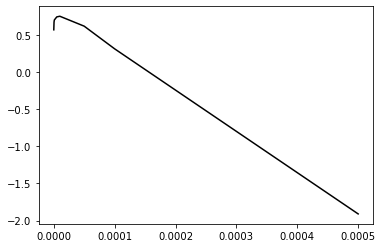

In [ ]:
# Use Support Vector Regressor to fit the data

# gamma : Kernel coefficient

gamma_list = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005]
svr_conf_list = []
for gamma in gamma_list:
    # C : Regularization parameter. The strength of the regularization is inversely proportional to C.
    c = 2400

    # radial basis function kernel
    kernel="rbf"

    svr = SVR(kernel=kernel, C=c, gamma=gamma)
    svr.fit(new_train_X_10, new_train_y)

    svr_prediction = svr.predict(new_valid_X_10)
    svr_confidence = svr.score(new_valid_X_10, new_valid_y)
    print("svr confidence (gamma =", gamma,"):", svr_confidence)
    svr_conf_list.append(svr_confidence)
    
plt.plot(gamma_list, svr_conf_list, label = "gamma to SVR Confid", color = 'Black')

In [ ]:
# Choose gamma = 0.00001

### Model Testing

In [ ]:
# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
c = 2400

# gamma : Kernel coefficient
gamma = 0.00001

# radial basis function kernel
kernel="rbf"

svr = SVR(kernel=kernel, C=c, gamma=gamma)
svr.fit(new_train_X_10, new_train_y)

svr_prediction = svr.predict(new_test_X_10)
svr_confidence = svr.score(new_test_X_10, new_test_y)
print("svr confidence:", svr_confidence)

with open("model/svr_"+str(num_day_to_predict)+"day.pickle", "wb") as f:
    pickle.dump(svr, f)

/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence: 0.5251380467104687


In [ ]:
def convert_prediction(X,y,pred):
    col_list =[] 
    for col in X.columns:
        if "open" in col:
            col_list.append(col)
        
    mean = np.mean(X.loc[:,col_list],axis=1)
    mean.index = y.index
    std = np.std(X.loc[:,col_list],axis=1)
    std.index = y.index
    a = pd.DataFrame(index = y.index,columns=['mean','std','pred'])
    a.loc[:,"mean"] = mean
    a.loc[:,"std"] = std
    a.loc[:,"pred"] = pred
    a.loc[:,"converted"] = pred*std+mean
    return a

## Backtest Result for SVR

In [ ]:
#### SVR Backtest
backtest_summary = pd.DataFrame(columns=backtest_col)
num_day_to_predict = 5
with open("model/svr_"+str(num_day_to_predict)+"day.pickle", "rb") as f:
    svr_test = pickle.load(f)
    
for sector, stocks in stock_list.items():
    for stock in stocks:
        print("Runninng stock: "+ stock)
        stock_data_1 = web.DataReader(stock, "stooq",start=start_date, end=end_date)
        stock_data_1.columns = ["open","high","low","close","volume"]
        x_1 = StockDataFrame(stock_data_1)
        data_1 = x_1[['open','high','low','close','volume',
                      'boll', 'boll_ub', 'boll_lb',
                      'macd', 'macdh', 'macds',
                      'rsi_11', 'rsi_14', 'rsi_21']]
        data_1.index = [int(str(ind)[0:4]+str(ind)[5:7]+str(ind)[8:10]) for ind in data_1.index]
        data_1 = data_1.sort_index()
        print(stock + " Data loaded...")
        
        for k,v in date_range_list.items():
         
            print("Getting Data... - " + stock + " from " + str(k))
            if (data_1.index[0]>v):
                print("No data for this testing period... - " + stock + " from " + str(k))
                continue
            test_X = custom_split(data_1,start = k,end = v)
            if len(test_X) <= num_day_to_predict:
                print("No enoguh data for testing... - " + stock + " from " + str(k))
                continue
                
            print("Transforming Data... - " + stock + " from " + str(k))
            test_y = produce_result_target_price(test_X,num_day_to_predict)
            test_X_10 = transform_x_data_to_one_vector(test_X,num_day_to_predict)
            new_test_X_10  = drop_nan_row_X_10(test_X_10,num_day_to_predict)
            new_test_y = drop_nan_row_y(test_y,num_day_to_predict)
            old_test_X_10 = new_test_X_10.copy()
            old_test_y = new_test_y.copy()
            new_test_X_10,new_test_y = normalize_data_by_row(new_test_X_10,new_test_y)
            
            print("Predicting... - " + stock + " from " + str(k))
            svr_prediction = svr_test.predict(new_test_X_10)
            
            print("Converting... - " + stock + " from " + str(k))
            pred_df = convert_prediction(old_test_X_10,old_test_y,svr_prediction)
            converted_pred = pred_df.loc[:,"converted"]
            pred_df["Action"] = pred_df.apply(lambda row: "Buy" if row["converted"] > row["mean"] else "Sell", axis=1)
            final_pred = pred_df.drop(columns=["mean","std","pred","converted"])
            final_test_y = old_test_y.rename(columns={"result_price":"Open"})
            final_pred = final_pred.sort_index()
            
            print("Backtesting... - " + stock + " from " + str(k))
            back1 = backtest(final_test_y,final_pred,10000,0.0005,period_year)
            back1.clear_trade_record(3)
            
            print("Start Iteration... - " + stock + " from " + str(k))
            back1.start_test()
            
            print("======= from "+ str(k) + " to " + str(v)+" =========")
            back1.print_do_nothing()
            back1.print_profit()
            back1.print_CAGR_performance()
            back1.export_trade_record("["+str(num_day_to_predict)+"]SVR_"+sector+"-"+stock,str(k)+"-to-"+str(v)+"("+str(round(back1.get_diff_in_CAGR()*100,2))+"%)")
            backtest_summary = backtest_summary.append({"Sector":sector,
                                                        "Stock":stock,
                                                        "Range_Start":str(k),
                                                        "Range_End":str(v),
                                                        do_nth_name+"_Profit":round(back1.get_do_nothing(),2),
                                                        model_name+"_Profit":round(back1.get_profit(),2),
                                                        do_nth_name+"_CAGR(in %)":round(back1.get_do_nothing_CAGR()*100,2),
                                                        model_name+"_CAGR(in %)":round(back1.get_model_CAGR()*100,2),
                                                        "CAGR_Performance(in %)":round(back1.get_diff_in_CAGR()*100,2),
                                                        do_nth_name+"_MDD(in %)":round(back1.get_do_nothing_MDD()*100,2),
                                                        model_name+"_MDD(in %)":round(back1.get_model_MDD()*100,2),
                                                        "MDD_Performance(in %)":round(back1.get_diff_in_MDD()*100,2)}, ignore_index=True)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

print("Backtesting ["+str(num_day_to_predict)+"] Completed...")
backtest_summary.to_csv("["+str(num_day_to_predict)+"]backtest_summary_SVR.csv")

In [ ]:

mean_backtest_summary = backtest_summary.groupby("Stock")[["Stock",
                                                          do_nth_name+"_Profit",
                                                          model_name+"_Profit",
                                                          do_nth_name+"_CAGR(in %)",
                                                          model_name+"_CAGR(in %)",
                                                          "CAGR_Performance(in %)",
                                                          do_nth_name+"_MDD(in %)",
                                                          model_name+"_MDD(in %)",
                                                          "MDD_Performance(in %)"]].mean()

mean_backtest_summary = mean_backtest_summary.add_prefix("mean_")

mean_backtest_summary = mean_backtest_summary.round(decimals = 2)
mean_backtest_summary.to_csv("["+str(num_day_to_predict)+"]backtest_summary_SVR_mean.csv")

# Volatility of model

In [ ]:

def get_volatility_by_path(path):
    summary = pd.read_csv(path)
    sd_summary = summary[["mean_"+model_name+"_Profit","mean_CAGR_Performance(in %)","mean_MDD_Performance(in %)"]].std()
    sd_summary = sd_summary.to_frame().transpose()
    sd_summary.columns = map((lambda col: "SD_"+col[5:]),sd_summary.columns)
    return sd_summary

svr_5_sd_summary = get_volatility_by_path("[5]backtest_summary_SVR_mean.csv")
svr_10_sd_summary = get_volatility_by_path("[10]backtest_summary_SVR_mean.csv")
cnn_lstm_reg_sd_summary = get_volatility_by_path("backtest_summary_CNN_LSTM_REG_mean.csv")
cnn_lstm_class_sd_summary = get_volatility_by_path("backtest_summary_CNN_LSTM_CLASS_mean.csv")



In [ ]:
svr_5_sd_summary

,SD_WithModel_Profit,SD_CAGR_Performance(in %),SD_MDD_Performance(in %)
0,2894.370797,22.827452,3.43039


In [ ]:
svr_10_sd_summary

,SD_WithModel_Profit,SD_CAGR_Performance(in %),SD_MDD_Performance(in %)
0,2480.152007,19.514816,4.2564


In [ ]:
cnn_lstm_reg_sd_summary

,SD_WithModel_Profit,SD_CAGR_Performance(in %),SD_MDD_Performance(in %)
0,1408.245475,10.985125,3.520636


In [ ]:
cnn_lstm_class_sd_summary

,SD_WithModel_Profit,SD_CAGR_Performance(in %),SD_MDD_Performance(in %)
0,1320.539532,10.645664,4.387169
